In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
!pip install wandb --quiet
!pip install torch==1.12.1 torchvision==0.13.1 torchaudio==0.12.1
!pip install seaborn
!pip install torchsummaryx==1.3.0
!pip install ipdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.1/267.1 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.3/776.3 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 35.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 55.3 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.2.1+cu121
    Uninstalling torch-2.2.1+cu121:
      Successfully uninstalled torch-2.2.1+cu121
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.17.1+cu121
    Uninstalling torchvision-0.17.1+cu121:
      Successfully uninstalled torchvision-0.17.1+cu121
  Attempting uninstall: torchaudio
    Found existing installation: torchaudi

In [ ]:
# Import the important packages
import torch
from torchsummaryX import summary
import torchvision
import os
import gc
from tqdm import tqdm
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
import glob
import wandb
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.ops import DropBlock2d
import seaborn as sns
from torch.utils.data import DataLoader, TensorDataset
import ipdb
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", DEVICE)

Device:  cpu


In [ ]:
%pdb on

Automatic pdb calling has been turned ON


In [ ]:
!mkdir /content/data

# Prepare Train and Validate Data

In [ ]:
dataDir = "/content/data"

trainData = pd.read_csv(os.path.join(dataDir, "data.csv"))


In [ ]:
trainData.head()
# data.count()

,Unnamed: 0,open,high,low,close,adjusted close,volume,dividend amount,split cf,date
0,0,115.00,116.335,114.56,115.81,115.81,3322012,0.0,1.0,2021-11-26
1,1,116.16,117.270,116.08,116.73,116.73,3220802,0.0,1.0,2021-11-24
2,2,116.79,117.940,116.04,116.79,116.79,4914995,0.0,1.0,2021-11-23
3,3,116.00,118.810,115.19,116.47,116.47,6417218,0.0,1.0,2021-11-22
4,4,116.49,116.560,115.27,116.05,116.05,5384548,0.0,1.0,2021-11-19


In [ ]:
trainData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5555 entries, 0 to 5554
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       5555 non-null   int64  
 1   open             5555 non-null   float64
 2   high             5555 non-null   float64
 3   low              5555 non-null   float64
 4   close            5555 non-null   float64
 5   adjusted close   5555 non-null   float64
 6   volume           5555 non-null   int64  
 7   dividend amount  5555 non-null   float64
 8   split cf         5555 non-null   float64
 9   date             5555 non-null   object 
dtypes: float64(7), int64(2), object(1)
memory usage: 434.1+ KB


In [ ]:
trainData.isnull().sum()

Unnamed: 0         0
open               0
high               0
low                0
close              0
adjusted close     0
volume             0
dividend amount    0
split cf           0
date               0
dtype: int64

In [ ]:
trainData.reset_index(drop=True, inplace=True)
trainData.fillna(trainData.mean(), inplace=True)
trainData.head()

TypeError: Could not convert ['2021-11-262021-11-242021-11-232021-11-222021-11-192021-11-182021-11-172021-11-162021-11-152021-11-122021-11-112021-11-102021-11-092021-11-082021-11-052021-11-042021-11-032021-11-022021-11-012021-10-292021-10-282021-10-272021-10-262021-10-252021-10-222021-10-212021-10-202021-10-192021-10-182021-10-152021-10-142021-10-132021-10-122021-10-112021-10-082021-10-072021-10-062021-10-052021-10-042021-10-012021-09-302021-09-292021-09-282021-09-272021-09-242021-09-232021-09-222021-09-212021-09-202021-09-172021-09-162021-09-152021-09-142021-09-132021-09-102021-09-092021-09-082021-09-072021-09-032021-09-022021-09-012021-08-312021-08-302021-08-272021-08-262021-08-252021-08-242021-08-232021-08-202021-08-192021-08-182021-08-172021-08-162021-08-132021-08-122021-08-112021-08-102021-08-092021-08-062021-08-052021-08-042021-08-032021-08-022021-07-302021-07-292021-07-282021-07-272021-07-262021-07-232021-07-222021-07-212021-07-202021-07-192021-07-162021-07-152021-07-142021-07-132021-07-122021-07-092021-07-082021-07-072021-07-062021-07-022021-07-012021-06-302021-06-292021-06-282021-06-252021-06-242021-06-232021-06-222021-06-212021-06-182021-06-172021-06-162021-06-152021-06-142021-06-112021-06-102021-06-092021-06-082021-06-072021-06-042021-06-032021-06-022021-06-012021-05-282021-05-272021-05-262021-05-252021-05-242021-05-212021-05-202021-05-192021-05-182021-05-172021-05-142021-05-132021-05-122021-05-112021-05-102021-05-072021-05-062021-05-052021-05-042021-05-032021-04-302021-04-292021-04-282021-04-272021-04-262021-04-232021-04-222021-04-212021-04-202021-04-192021-04-162021-04-152021-04-142021-04-132021-04-122021-04-092021-04-082021-04-072021-04-062021-04-052021-04-012021-03-312021-03-302021-03-292021-03-262021-03-252021-03-242021-03-232021-03-222021-03-192021-03-182021-03-172021-03-162021-03-152021-03-122021-03-112021-03-102021-03-092021-03-082021-03-052021-03-042021-03-032021-03-022021-03-012021-02-262021-02-252021-02-242021-02-232021-02-222021-02-192021-02-182021-02-172021-02-162021-02-122021-02-112021-02-102021-02-092021-02-082021-02-052021-02-042021-02-032021-02-022021-02-012021-01-292021-01-282021-01-272021-01-262021-01-252021-01-222021-01-212021-01-202021-01-192021-01-152021-01-142021-01-132021-01-122021-01-112021-01-082021-01-072021-01-062021-01-052021-01-042020-12-312020-12-302020-12-292020-12-282020-12-242020-12-232020-12-222020-12-212020-12-182020-12-172020-12-162020-12-152020-12-142020-12-112020-12-102020-12-092020-12-082020-12-072020-12-042020-12-032020-12-022020-12-012020-11-302020-11-272020-11-252020-11-242020-11-232020-11-202020-11-192020-11-182020-11-172020-11-162020-11-132020-11-122020-11-112020-11-102020-11-092020-11-062020-11-052020-11-042020-11-032020-11-022020-10-302020-10-292020-10-282020-10-272020-10-262020-10-232020-10-222020-10-212020-10-202020-10-192020-10-162020-10-152020-10-142020-10-132020-10-122020-10-092020-10-082020-10-072020-10-062020-10-052020-10-022020-10-012020-09-302020-09-292020-09-282020-09-252020-09-242020-09-232020-09-222020-09-212020-09-182020-09-172020-09-162020-09-152020-09-142020-09-112020-09-102020-09-092020-09-082020-09-042020-09-032020-09-022020-09-012020-08-312020-08-282020-08-272020-08-262020-08-252020-08-242020-08-212020-08-202020-08-192020-08-182020-08-172020-08-142020-08-132020-08-122020-08-112020-08-102020-08-072020-08-062020-08-052020-08-042020-08-032020-07-312020-07-302020-07-292020-07-282020-07-272020-07-242020-07-232020-07-222020-07-212020-07-202020-07-172020-07-162020-07-152020-07-142020-07-132020-07-102020-07-092020-07-082020-07-072020-07-062020-07-022020-07-012020-06-302020-06-292020-06-262020-06-252020-06-242020-06-232020-06-222020-06-192020-06-182020-06-172020-06-162020-06-152020-06-122020-06-112020-06-102020-06-092020-06-082020-06-052020-06-042020-06-032020-06-022020-06-012020-05-292020-05-282020-05-272020-05-262020-05-222020-05-212020-05-202020-05-192020-05-182020-05-152020-05-142020-05-132020-05-122020-05-112020-05-082020-05-072020-05-062020-05-052020-05-042020-05-012020-04-302020-04-292020-04-282020-04-272020-04-242020-04-232020-04-222020-04-212020-04-202020-04-172020-04-162020-04-152020-04-142020-04-132020-04-092020-04-082020-04-072020-04-062020-04-032020-04-022020-04-012020-03-312020-03-302020-03-272020-03-262020-03-252020-03-242020-03-232020-03-202020-03-192020-03-182020-03-172020-03-162020-03-132020-03-122020-03-112020-03-102020-03-092020-03-062020-03-052020-03-042020-03-032020-03-022020-02-282020-02-272020-02-262020-02-252020-02-242020-02-212020-02-202020-02-192020-02-182020-02-142020-02-132020-02-122020-02-112020-02-102020-02-072020-02-062020-02-052020-02-042020-02-032020-01-312020-01-302020-01-292020-01-282020-01-272020-01-242020-01-232020-01-222020-01-212020-01-172020-01-162020-01-152020-01-142020-01-132020-01-102020-01-092020-01-082020-01-072020-01-062020-01-032020-01-022019-12-312019-12-302019-12-272019-12-262019-12-242019-12-232019-12-202019-12-192019-12-182019-12-172019-12-162019-12-132019-12-122019-12-112019-12-102019-12-092019-12-062019-12-052019-12-042019-12-032019-12-022019-11-292019-11-272019-11-262019-11-252019-11-222019-11-212019-11-202019-11-192019-11-182019-11-152019-11-142019-11-132019-11-122019-11-112019-11-082019-11-072019-11-062019-11-052019-11-042019-11-012019-10-312019-10-302019-10-292019-10-282019-10-252019-10-242019-10-232019-10-222019-10-212019-10-182019-10-172019-10-162019-10-152019-10-142019-10-112019-10-102019-10-092019-10-082019-10-072019-10-042019-10-032019-10-022019-10-012019-09-302019-09-272019-09-262019-09-252019-09-242019-09-232019-09-202019-09-192019-09-182019-09-172019-09-162019-09-132019-09-122019-09-112019-09-102019-09-092019-09-062019-09-052019-09-042019-09-032019-08-302019-08-292019-08-282019-08-272019-08-262019-08-232019-08-222019-08-212019-08-202019-08-192019-08-162019-08-152019-08-142019-08-132019-08-122019-08-092019-08-082019-08-072019-08-062019-08-052019-08-022019-08-012019-07-312019-07-302019-07-292019-07-262019-07-252019-07-242019-07-232019-07-222019-07-192019-07-182019-07-172019-07-162019-07-152019-07-122019-07-112019-07-102019-07-092019-07-082019-07-052019-07-032019-07-022019-07-012019-06-282019-06-272019-06-262019-06-252019-06-242019-06-212019-06-202019-06-192019-06-182019-06-172019-06-142019-06-132019-06-122019-06-112019-06-102019-06-072019-06-062019-06-052019-06-042019-06-032019-05-312019-05-302019-05-292019-05-282019-05-242019-05-232019-05-222019-05-212019-05-202019-05-172019-05-162019-05-152019-05-142019-05-132019-05-102019-05-092019-05-082019-05-072019-05-062019-05-032019-05-022019-05-012019-04-302019-04-292019-04-262019-04-252019-04-242019-04-232019-04-222019-04-182019-04-172019-04-162019-04-152019-04-122019-04-112019-04-102019-04-092019-04-082019-04-052019-04-042019-04-032019-04-022019-04-012019-03-292019-03-282019-03-272019-03-262019-03-252019-03-222019-03-212019-03-202019-03-192019-03-182019-03-152019-03-142019-03-132019-03-122019-03-112019-03-082019-03-072019-03-062019-03-052019-03-042019-03-012019-02-282019-02-272019-02-262019-02-252019-02-222019-02-212019-02-202019-02-192019-02-152019-02-142019-02-132019-02-122019-02-112019-02-082019-02-072019-02-062019-02-052019-02-042019-02-012019-01-312019-01-302019-01-292019-01-282019-01-252019-01-242019-01-232019-01-222019-01-182019-01-172019-01-162019-01-152019-01-142019-01-112019-01-102019-01-092019-01-082019-01-072019-01-042019-01-032019-01-022018-12-312018-12-282018-12-272018-12-262018-12-242018-12-212018-12-202018-12-192018-12-182018-12-172018-12-142018-12-132018-12-122018-12-112018-12-102018-12-072018-12-062018-12-042018-12-032018-11-302018-11-292018-11-282018-11-272018-11-262018-11-232018-11-212018-11-202018-11-192018-11-162018-11-152018-11-142018-11-132018-11-122018-11-092018-11-082018-11-072018-11-062018-11-052018-11-022018-11-012018-10-312018-10-302018-10-292018-10-262018-10-252018-10-242018-10-232018-10-222018-10-192018-10-182018-10-172018-10-162018-10-152018-10-122018-10-112018-10-102018-10-092018-10-082018-10-052018-10-042018-10-032018-10-022018-10-012018-09-282018-09-272018-09-262018-09-252018-09-242018-09-212018-09-202018-09-192018-09-182018-09-172018-09-142018-09-132018-09-122018-09-112018-09-102018-09-072018-09-062018-09-052018-09-042018-08-312018-08-302018-08-292018-08-282018-08-272018-08-242018-08-232018-08-222018-08-212018-08-202018-08-172018-08-162018-08-152018-08-142018-08-132018-08-102018-08-092018-08-082018-08-072018-08-062018-08-032018-08-022018-08-012018-07-312018-07-302018-07-272018-07-262018-07-252018-07-242018-07-232018-07-202018-07-192018-07-182018-07-172018-07-162018-07-132018-07-122018-07-112018-07-102018-07-092018-07-062018-07-052018-07-032018-07-022018-06-292018-06-282018-06-272018-06-262018-06-252018-06-222018-06-212018-06-202018-06-192018-06-182018-06-152018-06-142018-06-132018-06-122018-06-112018-06-082018-06-072018-06-062018-06-052018-06-042018-06-012018-05-312018-05-302018-05-292018-05-252018-05-242018-05-232018-05-222018-05-212018-05-182018-05-172018-05-162018-05-152018-05-142018-05-112018-05-102018-05-092018-05-082018-05-072018-05-042018-05-032018-05-022018-05-012018-04-302018-04-272018-04-262018-04-252018-04-242018-04-232018-04-202018-04-192018-04-182018-04-172018-04-162018-04-132018-04-122018-04-112018-04-102018-04-092018-04-062018-04-052018-04-042018-04-032018-04-022018-03-292018-03-282018-03-272018-03-262018-03-232018-03-222018-03-212018-03-202018-03-192018-03-162018-03-152018-03-142018-03-132018-03-122018-03-092018-03-082018-03-072018-03-062018-03-052018-03-022018-03-012018-02-282018-02-272018-02-262018-02-232018-02-222018-02-212018-02-202018-02-162018-02-152018-02-142018-02-132018-02-122018-02-092018-02-082018-02-072018-02-062018-02-052018-02-022018-02-012018-01-312018-01-302018-01-292018-01-262018-01-252018-01-242018-01-232018-01-222018-01-192018-01-182018-01-172018-01-162018-01-122018-01-112018-01-102018-01-092018-01-082018-01-052018-01-042018-01-032018-01-022017-12-292017-12-282017-12-272017-12-262017-12-222017-12-212017-12-202017-12-192017-12-182017-12-152017-12-142017-12-132017-12-122017-12-112017-12-082017-12-072017-12-062017-12-052017-12-042017-12-012017-11-302017-11-292017-11-282017-11-272017-11-242017-11-222017-11-212017-11-202017-11-172017-11-162017-11-152017-11-142017-11-132017-11-102017-11-092017-11-082017-11-072017-11-062017-11-032017-11-022017-11-012017-10-312017-10-302017-10-272017-10-262017-10-252017-10-242017-10-232017-10-202017-10-192017-10-182017-10-172017-10-162017-10-132017-10-122017-10-112017-10-102017-10-092017-10-062017-10-052017-10-042017-10-032017-10-022017-09-292017-09-282017-09-272017-09-262017-09-252017-09-222017-09-212017-09-202017-09-192017-09-182017-09-152017-09-142017-09-132017-09-122017-09-112017-09-082017-09-072017-09-062017-09-052017-09-012017-08-312017-08-302017-08-292017-08-282017-08-252017-08-242017-08-232017-08-222017-08-212017-08-182017-08-172017-08-162017-08-152017-08-142017-08-112017-08-102017-08-092017-08-082017-08-072017-08-042017-08-032017-08-022017-08-012017-07-312017-07-282017-07-272017-07-262017-07-252017-07-242017-07-212017-07-202017-07-192017-07-182017-07-172017-07-142017-07-132017-07-122017-07-112017-07-102017-07-072017-07-062017-07-052017-07-032017-06-302017-06-292017-06-282017-06-272017-06-262017-06-232017-06-222017-06-212017-06-202017-06-192017-06-162017-06-152017-06-142017-06-132017-06-122017-06-092017-06-082017-06-072017-06-062017-06-052017-06-022017-06-012017-05-312017-05-302017-05-262017-05-252017-05-242017-05-232017-05-222017-05-192017-05-182017-05-172017-05-162017-05-152017-05-122017-05-112017-05-102017-05-092017-05-082017-05-052017-05-042017-05-032017-05-022017-05-012017-04-282017-04-272017-04-262017-04-252017-04-242017-04-212017-04-202017-04-192017-04-182017-04-172017-04-132017-04-122017-04-112017-04-102017-04-072017-04-062017-04-052017-04-042017-04-032017-03-312017-03-302017-03-292017-03-282017-03-272017-03-242017-03-232017-03-222017-03-212017-03-202017-03-172017-03-162017-03-152017-03-142017-03-132017-03-102017-03-092017-03-082017-03-072017-03-062017-03-032017-03-022017-03-012017-02-282017-02-272017-02-242017-02-232017-02-222017-02-212017-02-172017-02-162017-02-152017-02-142017-02-132017-02-102017-02-092017-02-082017-02-072017-02-062017-02-032017-02-022017-02-012017-01-312017-01-302017-01-272017-01-262017-01-252017-01-242017-01-232017-01-202017-01-192017-01-182017-01-172017-01-132017-01-122017-01-112017-01-102017-01-092017-01-062017-01-052017-01-042017-01-032016-12-302016-12-292016-12-282016-12-272016-12-232016-12-222016-12-212016-12-202016-12-192016-12-162016-12-152016-12-142016-12-132016-12-122016-12-092016-12-082016-12-072016-12-062016-12-052016-12-022016-12-012016-11-302016-11-292016-11-282016-11-252016-11-232016-11-222016-11-212016-11-182016-11-172016-11-162016-11-152016-11-142016-11-112016-11-102016-11-092016-11-082016-11-072016-11-042016-11-032016-11-022016-11-012016-10-312016-10-282016-10-272016-10-262016-10-252016-10-242016-10-212016-10-202016-10-192016-10-182016-10-172016-10-142016-10-132016-10-122016-10-112016-10-102016-10-072016-10-062016-10-052016-10-042016-10-032016-09-302016-09-292016-09-282016-09-272016-09-262016-09-232016-09-222016-09-212016-09-202016-09-192016-09-162016-09-152016-09-142016-09-132016-09-122016-09-092016-09-082016-09-072016-09-062016-09-022016-09-012016-08-312016-08-302016-08-292016-08-262016-08-252016-08-242016-08-232016-08-222016-08-192016-08-182016-08-172016-08-162016-08-152016-08-122016-08-112016-08-102016-08-092016-08-082016-08-052016-08-042016-08-032016-08-022016-08-012016-07-292016-07-282016-07-272016-07-262016-07-252016-07-222016-07-212016-07-202016-07-192016-07-182016-07-152016-07-142016-07-132016-07-122016-07-112016-07-082016-07-072016-07-062016-07-052016-07-012016-06-302016-06-292016-06-282016-06-272016-06-242016-06-232016-06-222016-06-212016-06-202016-06-172016-06-162016-06-152016-06-142016-06-132016-06-102016-06-092016-06-082016-06-072016-06-062016-06-032016-06-022016-06-012016-05-312016-05-272016-05-262016-05-252016-05-242016-05-232016-05-202016-05-192016-05-182016-05-172016-05-162016-05-132016-05-122016-05-112016-05-102016-05-092016-05-062016-05-052016-05-042016-05-032016-05-022016-04-292016-04-282016-04-272016-04-262016-04-252016-04-222016-04-212016-04-202016-04-192016-04-182016-04-152016-04-142016-04-132016-04-122016-04-112016-04-082016-04-072016-04-062016-04-052016-04-042016-04-012016-03-312016-03-302016-03-292016-03-282016-03-242016-03-232016-03-222016-03-212016-03-182016-03-172016-03-162016-03-152016-03-142016-03-112016-03-102016-03-092016-03-082016-03-072016-03-042016-03-032016-03-022016-03-012016-02-292016-02-262016-02-252016-02-242016-02-232016-02-222016-02-192016-02-182016-02-172016-02-162016-02-122016-02-112016-02-102016-02-092016-02-082016-02-052016-02-042016-02-032016-02-022016-02-012016-01-292016-01-282016-01-272016-01-262016-01-252016-01-222016-01-212016-01-202016-01-192016-01-152016-01-142016-01-132016-01-122016-01-112016-01-082016-01-072016-01-062016-01-052016-01-042015-12-312015-12-302015-12-292015-12-282015-12-242015-12-232015-12-222015-12-212015-12-182015-12-172015-12-162015-12-152015-12-142015-12-112015-12-102015-12-092015-12-082015-12-072015-12-042015-12-032015-12-022015-12-012015-11-302015-11-272015-11-252015-11-242015-11-232015-11-202015-11-192015-11-182015-11-172015-11-162015-11-132015-11-122015-11-112015-11-102015-11-092015-11-062015-11-052015-11-042015-11-032015-11-022015-10-302015-10-292015-10-282015-10-272015-10-262015-10-232015-10-222015-10-212015-10-202015-10-192015-10-162015-10-152015-10-142015-10-132015-10-122015-10-092015-10-082015-10-072015-10-062015-10-052015-10-022015-10-012015-09-302015-09-292015-09-282015-09-252015-09-242015-09-232015-09-222015-09-212015-09-182015-09-172015-09-162015-09-152015-09-142015-09-112015-09-102015-09-092015-09-082015-09-042015-09-032015-09-022015-09-012015-08-312015-08-282015-08-272015-08-262015-08-252015-08-242015-08-212015-08-202015-08-192015-08-182015-08-172015-08-142015-08-132015-08-122015-08-112015-08-102015-08-072015-08-062015-08-052015-08-042015-08-032015-07-312015-07-302015-07-292015-07-282015-07-272015-07-242015-07-232015-07-222015-07-212015-07-202015-07-172015-07-162015-07-152015-07-142015-07-132015-07-102015-07-092015-07-082015-07-072015-07-062015-07-022015-07-012015-06-302015-06-292015-06-262015-06-252015-06-242015-06-232015-06-222015-06-192015-06-182015-06-172015-06-162015-06-152015-06-122015-06-112015-06-102015-06-092015-06-082015-06-052015-06-042015-06-032015-06-022015-06-012015-05-292015-05-282015-05-272015-05-262015-05-222015-05-212015-05-202015-05-192015-05-182015-05-152015-05-142015-05-132015-05-122015-05-112015-05-082015-05-072015-05-062015-05-052015-05-042015-05-012015-04-302015-04-292015-04-282015-04-272015-04-242015-04-232015-04-222015-04-212015-04-202015-04-172015-04-162015-04-152015-04-142015-04-132015-04-102015-04-092015-04-082015-04-072015-04-062015-04-022015-04-012015-03-312015-03-302015-03-272015-03-262015-03-252015-03-242015-03-232015-03-202015-03-192015-03-182015-03-172015-03-162015-03-132015-03-122015-03-112015-03-102015-03-092015-03-062015-03-052015-03-042015-03-032015-03-022015-02-272015-02-262015-02-252015-02-242015-02-232015-02-202015-02-192015-02-182015-02-172015-02-132015-02-122015-02-112015-02-102015-02-092015-02-062015-02-052015-02-042015-02-032015-02-022015-01-302015-01-292015-01-282015-01-272015-01-262015-01-232015-01-222015-01-212015-01-202015-01-162015-01-152015-01-142015-01-132015-01-122015-01-092015-01-082015-01-072015-01-062015-01-052015-01-022014-12-312014-12-302014-12-292014-12-262014-12-242014-12-232014-12-222014-12-192014-12-182014-12-172014-12-162014-12-152014-12-122014-12-112014-12-102014-12-092014-12-082014-12-052014-12-042014-12-032014-12-022014-12-012014-11-282014-11-262014-11-252014-11-242014-11-212014-11-202014-11-192014-11-182014-11-172014-11-142014-11-132014-11-122014-11-112014-11-102014-11-072014-11-062014-11-052014-11-042014-11-032014-10-312014-10-302014-10-292014-10-282014-10-272014-10-242014-10-232014-10-222014-10-212014-10-202014-10-172014-10-162014-10-152014-10-142014-10-132014-10-102014-10-092014-10-082014-10-072014-10-062014-10-032014-10-022014-10-012014-09-302014-09-292014-09-262014-09-252014-09-242014-09-232014-09-222014-09-192014-09-182014-09-172014-09-162014-09-152014-09-122014-09-112014-09-102014-09-092014-09-082014-09-052014-09-042014-09-032014-09-022014-08-292014-08-282014-08-272014-08-262014-08-252014-08-222014-08-212014-08-202014-08-192014-08-182014-08-152014-08-142014-08-132014-08-122014-08-112014-08-082014-08-072014-08-062014-08-052014-08-042014-08-012014-07-312014-07-302014-07-292014-07-282014-07-252014-07-242014-07-232014-07-222014-07-212014-07-182014-07-172014-07-162014-07-152014-07-142014-07-112014-07-102014-07-092014-07-082014-07-072014-07-032014-07-022014-07-012014-06-302014-06-272014-06-262014-06-252014-06-242014-06-232014-06-202014-06-192014-06-182014-06-172014-06-162014-06-132014-06-122014-06-112014-06-102014-06-092014-06-062014-06-052014-06-042014-06-032014-06-022014-05-302014-05-292014-05-282014-05-272014-05-232014-05-222014-05-212014-05-202014-05-192014-05-162014-05-152014-05-142014-05-132014-05-122014-05-092014-05-082014-05-072014-05-062014-05-052014-05-022014-05-012014-04-302014-04-292014-04-282014-04-252014-04-242014-04-232014-04-222014-04-212014-04-172014-04-162014-04-152014-04-142014-04-112014-04-102014-04-092014-04-082014-04-072014-04-042014-04-032014-04-022014-04-012014-03-312014-03-282014-03-272014-03-262014-03-252014-03-242014-03-212014-03-202014-03-192014-03-182014-03-172014-03-142014-03-132014-03-122014-03-112014-03-102014-03-072014-03-062014-03-052014-03-042014-03-032014-02-282014-02-272014-02-262014-02-252014-02-242014-02-212014-02-202014-02-192014-02-182014-02-142014-02-132014-02-122014-02-112014-02-102014-02-072014-02-062014-02-052014-02-042014-02-032014-01-312014-01-302014-01-292014-01-282014-01-272014-01-242014-01-232014-01-222014-01-212014-01-172014-01-162014-01-152014-01-142014-01-132014-01-102014-01-092014-01-082014-01-072014-01-062014-01-032014-01-022013-12-312013-12-302013-12-272013-12-262013-12-242013-12-232013-12-202013-12-192013-12-182013-12-172013-12-162013-12-132013-12-122013-12-112013-12-102013-12-092013-12-062013-12-052013-12-042013-12-032013-12-022013-11-292013-11-272013-11-262013-11-252013-11-222013-11-212013-11-202013-11-192013-11-182013-11-152013-11-142013-11-132013-11-122013-11-112013-11-082013-11-072013-11-062013-11-052013-11-042013-11-012013-10-312013-10-302013-10-292013-10-282013-10-252013-10-242013-10-232013-10-222013-10-212013-10-182013-10-172013-10-162013-10-152013-10-142013-10-112013-10-102013-10-092013-10-082013-10-072013-10-042013-10-032013-10-022013-10-012013-09-302013-09-272013-09-262013-09-252013-09-242013-09-232013-09-202013-09-192013-09-182013-09-172013-09-162013-09-132013-09-122013-09-112013-09-102013-09-092013-09-062013-09-052013-09-042013-09-032013-08-302013-08-292013-08-282013-08-272013-08-262013-08-232013-08-222013-08-212013-08-202013-08-192013-08-162013-08-152013-08-142013-08-132013-08-122013-08-092013-08-082013-08-072013-08-062013-08-052013-08-022013-08-012013-07-312013-07-302013-07-292013-07-262013-07-252013-07-242013-07-232013-07-222013-07-192013-07-182013-07-172013-07-162013-07-152013-07-122013-07-112013-07-102013-07-092013-07-082013-07-052013-07-032013-07-022013-07-012013-06-282013-06-272013-06-262013-06-252013-06-242013-06-212013-06-202013-06-192013-06-182013-06-172013-06-142013-06-132013-06-122013-06-112013-06-102013-06-072013-06-062013-06-052013-06-042013-06-032013-05-312013-05-302013-05-292013-05-282013-05-242013-05-232013-05-222013-05-212013-05-202013-05-172013-05-162013-05-152013-05-142013-05-132013-05-102013-05-092013-05-082013-05-072013-05-062013-05-032013-05-022013-05-012013-04-302013-04-292013-04-262013-04-252013-04-242013-04-232013-04-222013-04-192013-04-182013-04-172013-04-162013-04-152013-04-122013-04-112013-04-102013-04-092013-04-082013-04-052013-04-042013-04-032013-04-022013-04-012013-03-282013-03-272013-03-262013-03-252013-03-222013-03-212013-03-202013-03-192013-03-182013-03-152013-03-142013-03-132013-03-122013-03-112013-03-082013-03-072013-03-062013-03-052013-03-042013-03-012013-02-282013-02-272013-02-262013-02-252013-02-222013-02-212013-02-202013-02-192013-02-152013-02-142013-02-132013-02-122013-02-112013-02-082013-02-072013-02-062013-02-052013-02-042013-02-012013-01-312013-01-302013-01-292013-01-282013-01-252013-01-242013-01-232013-01-222013-01-182013-01-172013-01-162013-01-152013-01-142013-01-112013-01-102013-01-092013-01-082013-01-072013-01-042013-01-032013-01-022012-12-312012-12-282012-12-272012-12-262012-12-242012-12-212012-12-202012-12-192012-12-182012-12-172012-12-142012-12-132012-12-122012-12-112012-12-102012-12-072012-12-062012-12-052012-12-042012-12-032012-11-302012-11-292012-11-282012-11-272012-11-262012-11-232012-11-212012-11-202012-11-192012-11-162012-11-152012-11-142012-11-132012-11-122012-11-092012-11-082012-11-072012-11-062012-11-052012-11-022012-11-012012-10-312012-10-262012-10-252012-10-242012-10-232012-10-222012-10-192012-10-182012-10-172012-10-162012-10-152012-10-122012-10-112012-10-102012-10-092012-10-082012-10-052012-10-042012-10-032012-10-022012-10-012012-09-282012-09-272012-09-262012-09-252012-09-242012-09-212012-09-202012-09-192012-09-182012-09-172012-09-142012-09-132012-09-122012-09-112012-09-102012-09-072012-09-062012-09-052012-09-042012-08-312012-08-302012-08-292012-08-282012-08-272012-08-242012-08-232012-08-222012-08-212012-08-202012-08-172012-08-162012-08-152012-08-142012-08-132012-08-102012-08-092012-08-082012-08-072012-08-062012-08-032012-08-022012-08-012012-07-312012-07-302012-07-272012-07-262012-07-252012-07-242012-07-232012-07-202012-07-192012-07-182012-07-172012-07-162012-07-132012-07-122012-07-112012-07-102012-07-092012-07-062012-07-052012-07-032012-07-022012-06-292012-06-282012-06-272012-06-262012-06-252012-06-222012-06-212012-06-202012-06-192012-06-182012-06-152012-06-142012-06-132012-06-122012-06-112012-06-082012-06-072012-06-062012-06-052012-06-042012-06-012012-05-312012-05-302012-05-292012-05-252012-05-242012-05-232012-05-222012-05-212012-05-182012-05-172012-05-162012-05-152012-05-142012-05-112012-05-102012-05-092012-05-082012-05-072012-05-042012-05-032012-05-022012-05-012012-04-302012-04-272012-04-262012-04-252012-04-242012-04-232012-04-202012-04-192012-04-182012-04-172012-04-162012-04-132012-04-122012-04-112012-04-102012-04-092012-04-052012-04-042012-04-032012-04-022012-03-302012-03-292012-03-282012-03-272012-03-262012-03-232012-03-222012-03-212012-03-202012-03-192012-03-162012-03-152012-03-142012-03-132012-03-122012-03-092012-03-082012-03-072012-03-062012-03-052012-03-022012-03-012012-02-292012-02-282012-02-272012-02-242012-02-232012-02-222012-02-212012-02-172012-02-162012-02-152012-02-142012-02-132012-02-102012-02-092012-02-082012-02-072012-02-062012-02-032012-02-022012-02-012012-01-312012-01-302012-01-272012-01-262012-01-252012-01-242012-01-232012-01-202012-01-192012-01-182012-01-172012-01-132012-01-122012-01-112012-01-102012-01-092012-01-062012-01-052012-01-042012-01-032011-12-302011-12-292011-12-282011-12-272011-12-232011-12-222011-12-212011-12-202011-12-192011-12-162011-12-152011-12-142011-12-132011-12-122011-12-092011-12-082011-12-072011-12-062011-12-052011-12-022011-12-012011-11-302011-11-292011-11-282011-11-252011-11-232011-11-222011-11-212011-11-182011-11-172011-11-162011-11-152011-11-142011-11-112011-11-102011-11-092011-11-082011-11-072011-11-042011-11-032011-11-022011-11-012011-10-312011-10-282011-10-272011-10-262011-10-252011-10-242011-10-212011-10-202011-10-192011-10-182011-10-172011-10-142011-10-132011-10-122011-10-112011-10-102011-10-072011-10-062011-10-052011-10-042011-10-032011-09-302011-09-292011-09-282011-09-272011-09-262011-09-232011-09-222011-09-212011-09-202011-09-192011-09-162011-09-152011-09-142011-09-132011-09-122011-09-092011-09-082011-09-072011-09-062011-09-022011-09-012011-08-312011-08-302011-08-292011-08-262011-08-252011-08-242011-08-232011-08-222011-08-192011-08-182011-08-172011-08-162011-08-152011-08-122011-08-112011-08-102011-08-092011-08-082011-08-052011-08-042011-08-032011-08-022011-08-012011-07-292011-07-282011-07-272011-07-262011-07-252011-07-222011-07-212011-07-202011-07-192011-07-182011-07-152011-07-142011-07-132011-07-122011-07-112011-07-082011-07-072011-07-062011-07-052011-07-012011-06-302011-06-292011-06-282011-06-272011-06-242011-06-232011-06-222011-06-212011-06-202011-06-172011-06-162011-06-152011-06-142011-06-132011-06-102011-06-092011-06-082011-06-072011-06-062011-06-032011-06-022011-06-012011-05-312011-05-272011-05-262011-05-252011-05-242011-05-232011-05-202011-05-192011-05-182011-05-172011-05-162011-05-132011-05-122011-05-112011-05-102011-05-092011-05-062011-05-052011-05-042011-05-032011-05-022011-04-292011-04-282011-04-272011-04-262011-04-252011-04-212011-04-202011-04-192011-04-182011-04-152011-04-142011-04-132011-04-122011-04-112011-04-082011-04-072011-04-062011-04-052011-04-042011-04-012011-03-312011-03-302011-03-292011-03-282011-03-252011-03-242011-03-232011-03-222011-03-212011-03-182011-03-172011-03-162011-03-152011-03-142011-03-112011-03-102011-03-092011-03-082011-03-072011-03-042011-03-032011-03-022011-03-012011-02-282011-02-252011-02-242011-02-232011-02-222011-02-182011-02-172011-02-162011-02-152011-02-142011-02-112011-02-102011-02-092011-02-082011-02-072011-02-042011-02-032011-02-022011-02-012011-01-312011-01-282011-01-272011-01-262011-01-252011-01-242011-01-212011-01-202011-01-192011-01-182011-01-142011-01-132011-01-122011-01-112011-01-102011-01-072011-01-062011-01-052011-01-042011-01-032010-12-312010-12-302010-12-292010-12-282010-12-272010-12-232010-12-222010-12-212010-12-202010-12-172010-12-162010-12-152010-12-142010-12-132010-12-102010-12-092010-12-082010-12-072010-12-062010-12-032010-12-022010-12-012010-11-302010-11-292010-11-262010-11-242010-11-232010-11-222010-11-192010-11-182010-11-172010-11-162010-11-152010-11-122010-11-112010-11-102010-11-092010-11-082010-11-052010-11-042010-11-032010-11-022010-11-012010-10-292010-10-282010-10-272010-10-262010-10-252010-10-222010-10-212010-10-202010-10-192010-10-182010-10-152010-10-142010-10-132010-10-122010-10-112010-10-082010-10-072010-10-062010-10-052010-10-042010-10-012010-09-302010-09-292010-09-282010-09-272010-09-242010-09-232010-09-222010-09-212010-09-202010-09-172010-09-162010-09-152010-09-142010-09-132010-09-102010-09-092010-09-082010-09-072010-09-032010-09-022010-09-012010-08-312010-08-302010-08-272010-08-262010-08-252010-08-242010-08-232010-08-202010-08-192010-08-182010-08-172010-08-162010-08-132010-08-122010-08-112010-08-102010-08-092010-08-062010-08-052010-08-042010-08-032010-08-022010-07-302010-07-292010-07-282010-07-272010-07-262010-07-232010-07-222010-07-212010-07-202010-07-192010-07-162010-07-152010-07-142010-07-132010-07-122010-07-092010-07-082010-07-072010-07-062010-07-022010-07-012010-06-302010-06-292010-06-282010-06-252010-06-242010-06-232010-06-222010-06-212010-06-182010-06-172010-06-162010-06-152010-06-142010-06-112010-06-102010-06-092010-06-082010-06-072010-06-042010-06-032010-06-022010-06-012010-05-282010-05-272010-05-262010-05-252010-05-242010-05-212010-05-202010-05-192010-05-182010-05-172010-05-142010-05-132010-05-122010-05-112010-05-102010-05-072010-05-062010-05-052010-05-042010-05-032010-04-302010-04-292010-04-282010-04-272010-04-262010-04-232010-04-222010-04-212010-04-202010-04-192010-04-162010-04-152010-04-142010-04-132010-04-122010-04-092010-04-082010-04-072010-04-062010-04-052010-04-012010-03-312010-03-302010-03-292010-03-262010-03-252010-03-242010-03-232010-03-222010-03-192010-03-182010-03-172010-03-162010-03-152010-03-122010-03-112010-03-102010-03-092010-03-082010-03-052010-03-042010-03-032010-03-022010-03-012010-02-262010-02-252010-02-242010-02-232010-02-222010-02-192010-02-182010-02-172010-02-162010-02-122010-02-112010-02-102010-02-092010-02-082010-02-052010-02-042010-02-032010-02-022010-02-012010-01-292010-01-282010-01-272010-01-262010-01-252010-01-222010-01-212010-01-202010-01-192010-01-152010-01-142010-01-132010-01-122010-01-112010-01-082010-01-072010-01-062010-01-052010-01-042009-12-312009-12-302009-12-292009-12-282009-12-242009-12-232009-12-222009-12-212009-12-182009-12-172009-12-162009-12-152009-12-142009-12-112009-12-102009-12-092009-12-082009-12-072009-12-042009-12-032009-12-022009-12-012009-11-302009-11-272009-11-252009-11-242009-11-232009-11-202009-11-192009-11-182009-11-172009-11-162009-11-132009-11-122009-11-112009-11-102009-11-092009-11-062009-11-052009-11-042009-11-032009-11-022009-10-302009-10-292009-10-282009-10-272009-10-262009-10-232009-10-222009-10-212009-10-202009-10-192009-10-162009-10-152009-10-142009-10-132009-10-122009-10-092009-10-082009-10-072009-10-062009-10-052009-10-022009-10-012009-09-302009-09-292009-09-282009-09-252009-09-242009-09-232009-09-222009-09-212009-09-182009-09-172009-09-162009-09-152009-09-142009-09-112009-09-102009-09-092009-09-082009-09-042009-09-032009-09-022009-09-012009-08-312009-08-282009-08-272009-08-262009-08-252009-08-242009-08-212009-08-202009-08-192009-08-182009-08-172009-08-142009-08-132009-08-122009-08-112009-08-102009-08-072009-08-062009-08-052009-08-042009-08-032009-07-312009-07-302009-07-292009-07-282009-07-272009-07-242009-07-232009-07-222009-07-212009-07-202009-07-172009-07-162009-07-152009-07-142009-07-132009-07-102009-07-092009-07-082009-07-072009-07-062009-07-022009-07-012009-06-302009-06-292009-06-262009-06-252009-06-242009-06-232009-06-222009-06-192009-06-182009-06-172009-06-162009-06-152009-06-122009-06-112009-06-102009-06-092009-06-082009-06-052009-06-042009-06-032009-06-022009-06-012009-05-292009-05-282009-05-272009-05-262009-05-222009-05-212009-05-202009-05-192009-05-182009-05-152009-05-142009-05-132009-05-122009-05-112009-05-082009-05-072009-05-062009-05-052009-05-042009-05-012009-04-302009-04-292009-04-282009-04-272009-04-242009-04-232009-04-222009-04-212009-04-202009-04-172009-04-162009-04-152009-04-142009-04-132009-04-092009-04-082009-04-072009-04-062009-04-032009-04-022009-04-012009-03-312009-03-302009-03-272009-03-262009-03-252009-03-242009-03-232009-03-202009-03-192009-03-182009-03-172009-03-162009-03-132009-03-122009-03-112009-03-102009-03-092009-03-062009-03-052009-03-042009-03-032009-03-022009-02-272009-02-262009-02-252009-02-242009-02-232009-02-202009-02-192009-02-182009-02-172009-02-132009-02-122009-02-112009-02-102009-02-092009-02-062009-02-052009-02-042009-02-032009-02-022009-01-302009-01-292009-01-282009-01-272009-01-262009-01-232009-01-222009-01-212009-01-202009-01-162009-01-152009-01-142009-01-132009-01-122009-01-092009-01-082009-01-072009-01-062009-01-052009-01-022008-12-312008-12-302008-12-292008-12-262008-12-242008-12-232008-12-222008-12-192008-12-182008-12-172008-12-162008-12-152008-12-122008-12-112008-12-102008-12-092008-12-082008-12-052008-12-042008-12-032008-12-022008-12-012008-11-282008-11-262008-11-252008-11-242008-11-212008-11-202008-11-192008-11-182008-11-172008-11-142008-11-132008-11-122008-11-112008-11-102008-11-072008-11-062008-11-052008-11-042008-11-032008-10-312008-10-302008-10-292008-10-282008-10-272008-10-242008-10-232008-10-222008-10-212008-10-202008-10-172008-10-162008-10-152008-10-142008-10-132008-10-102008-10-092008-10-082008-10-072008-10-062008-10-032008-10-022008-10-012008-09-302008-09-292008-09-262008-09-252008-09-242008-09-232008-09-222008-09-192008-09-182008-09-172008-09-162008-09-152008-09-122008-09-112008-09-102008-09-092008-09-082008-09-052008-09-042008-09-032008-09-022008-08-292008-08-282008-08-272008-08-262008-08-252008-08-222008-08-212008-08-202008-08-192008-08-182008-08-152008-08-142008-08-132008-08-122008-08-112008-08-082008-08-072008-08-062008-08-052008-08-042008-08-012008-07-312008-07-302008-07-292008-07-282008-07-252008-07-242008-07-232008-07-222008-07-212008-07-182008-07-172008-07-162008-07-152008-07-142008-07-112008-07-102008-07-092008-07-082008-07-072008-07-032008-07-022008-07-012008-06-302008-06-272008-06-262008-06-252008-06-242008-06-232008-06-202008-06-192008-06-182008-06-172008-06-162008-06-132008-06-122008-06-112008-06-102008-06-092008-06-062008-06-052008-06-042008-06-032008-06-022008-05-302008-05-292008-05-282008-05-272008-05-232008-05-222008-05-212008-05-202008-05-192008-05-162008-05-152008-05-142008-05-132008-05-122008-05-092008-05-082008-05-072008-05-062008-05-052008-05-022008-05-012008-04-302008-04-292008-04-282008-04-252008-04-242008-04-232008-04-222008-04-212008-04-182008-04-172008-04-162008-04-152008-04-142008-04-112008-04-102008-04-092008-04-082008-04-072008-04-042008-04-032008-04-022008-04-012008-03-312008-03-282008-03-272008-03-262008-03-252008-03-242008-03-202008-03-192008-03-182008-03-172008-03-142008-03-132008-03-122008-03-112008-03-102008-03-072008-03-062008-03-052008-03-042008-03-032008-02-292008-02-282008-02-272008-02-262008-02-252008-02-222008-02-212008-02-202008-02-192008-02-152008-02-142008-02-132008-02-122008-02-112008-02-082008-02-072008-02-062008-02-052008-02-042008-02-012008-01-312008-01-302008-01-292008-01-282008-01-252008-01-242008-01-232008-01-222008-01-182008-01-172008-01-162008-01-152008-01-142008-01-112008-01-102008-01-092008-01-082008-01-072008-01-042008-01-032008-01-022007-12-312007-12-282007-12-272007-12-262007-12-242007-12-212007-12-202007-12-192007-12-182007-12-172007-12-142007-12-132007-12-122007-12-112007-12-102007-12-072007-12-062007-12-052007-12-042007-12-032007-11-302007-11-292007-11-282007-11-272007-11-262007-11-232007-11-212007-11-202007-11-192007-11-162007-11-152007-11-142007-11-132007-11-122007-11-092007-11-082007-11-072007-11-062007-11-052007-11-022007-11-012007-10-312007-10-302007-10-292007-10-262007-10-252007-10-242007-10-232007-10-222007-10-192007-10-182007-10-172007-10-162007-10-152007-10-122007-10-112007-10-102007-10-092007-10-082007-10-052007-10-042007-10-032007-10-022007-10-012007-09-282007-09-272007-09-262007-09-252007-09-242007-09-212007-09-202007-09-192007-09-182007-09-172007-09-142007-09-132007-09-122007-09-112007-09-102007-09-072007-09-062007-09-052007-09-042007-08-312007-08-302007-08-292007-08-282007-08-272007-08-242007-08-232007-08-222007-08-212007-08-202007-08-172007-08-162007-08-152007-08-142007-08-132007-08-102007-08-092007-08-082007-08-072007-08-062007-08-032007-08-022007-08-012007-07-312007-07-302007-07-272007-07-262007-07-252007-07-242007-07-232007-07-202007-07-192007-07-182007-07-172007-07-162007-07-132007-07-122007-07-112007-07-102007-07-092007-07-062007-07-052007-07-032007-07-022007-06-292007-06-282007-06-272007-06-262007-06-252007-06-222007-06-212007-06-202007-06-192007-06-182007-06-152007-06-142007-06-132007-06-122007-06-112007-06-082007-06-072007-06-062007-06-052007-06-042007-06-012007-05-312007-05-302007-05-292007-05-252007-05-242007-05-232007-05-222007-05-212007-05-182007-05-172007-05-162007-05-152007-05-142007-05-112007-05-102007-05-092007-05-082007-05-072007-05-042007-05-032007-05-022007-05-012007-04-302007-04-272007-04-262007-04-252007-04-242007-04-232007-04-202007-04-192007-04-182007-04-172007-04-162007-04-132007-04-122007-04-112007-04-102007-04-092007-04-052007-04-042007-04-032007-04-022007-03-302007-03-292007-03-282007-03-272007-03-262007-03-232007-03-222007-03-212007-03-202007-03-192007-03-162007-03-152007-03-142007-03-132007-03-122007-03-092007-03-082007-03-072007-03-062007-03-052007-03-022007-03-012007-02-282007-02-272007-02-262007-02-232007-02-222007-02-212007-02-202007-02-162007-02-152007-02-142007-02-132007-02-122007-02-092007-02-082007-02-072007-02-062007-02-052007-02-022007-02-012007-01-312007-01-302007-01-292007-01-262007-01-252007-01-242007-01-232007-01-222007-01-192007-01-182007-01-172007-01-162007-01-122007-01-112007-01-102007-01-092007-01-082007-01-052007-01-042007-01-032006-12-292006-12-282006-12-272006-12-262006-12-222006-12-212006-12-202006-12-192006-12-182006-12-152006-12-142006-12-132006-12-122006-12-112006-12-082006-12-072006-12-062006-12-052006-12-042006-12-012006-11-302006-11-292006-11-282006-11-272006-11-242006-11-222006-11-212006-11-202006-11-172006-11-162006-11-152006-11-142006-11-132006-11-102006-11-092006-11-082006-11-072006-11-062006-11-032006-11-022006-11-012006-10-312006-10-302006-10-272006-10-262006-10-252006-10-242006-10-232006-10-202006-10-192006-10-182006-10-172006-10-162006-10-132006-10-122006-10-112006-10-102006-10-092006-10-062006-10-052006-10-042006-10-032006-10-022006-09-292006-09-282006-09-272006-09-262006-09-252006-09-222006-09-212006-09-202006-09-192006-09-182006-09-152006-09-142006-09-132006-09-122006-09-112006-09-082006-09-072006-09-062006-09-052006-09-012006-08-312006-08-302006-08-292006-08-282006-08-252006-08-242006-08-232006-08-222006-08-212006-08-182006-08-172006-08-162006-08-152006-08-142006-08-112006-08-102006-08-092006-08-082006-08-072006-08-042006-08-032006-08-022006-08-012006-07-312006-07-282006-07-272006-07-262006-07-252006-07-242006-07-212006-07-202006-07-192006-07-182006-07-172006-07-142006-07-132006-07-122006-07-112006-07-102006-07-072006-07-062006-07-052006-07-032006-06-302006-06-292006-06-282006-06-272006-06-262006-06-232006-06-222006-06-212006-06-202006-06-192006-06-162006-06-152006-06-142006-06-132006-06-122006-06-092006-06-082006-06-072006-06-062006-06-052006-06-022006-06-012006-05-312006-05-302006-05-262006-05-252006-05-242006-05-232006-05-222006-05-192006-05-182006-05-172006-05-162006-05-152006-05-122006-05-112006-05-102006-05-092006-05-082006-05-052006-05-042006-05-032006-05-022006-05-012006-04-282006-04-272006-04-262006-04-252006-04-242006-04-212006-04-202006-04-192006-04-182006-04-172006-04-132006-04-122006-04-112006-04-102006-04-072006-04-062006-04-052006-04-042006-04-032006-03-312006-03-302006-03-292006-03-282006-03-272006-03-242006-03-232006-03-222006-03-212006-03-202006-03-172006-03-162006-03-152006-03-142006-03-132006-03-102006-03-092006-03-082006-03-072006-03-062006-03-032006-03-022006-03-012006-02-282006-02-272006-02-242006-02-232006-02-222006-02-212006-02-172006-02-162006-02-152006-02-142006-02-132006-02-102006-02-092006-02-082006-02-072006-02-062006-02-032006-02-022006-02-012006-01-312006-01-302006-01-272006-01-262006-01-252006-01-242006-01-232006-01-202006-01-192006-01-182006-01-172006-01-132006-01-122006-01-112006-01-102006-01-092006-01-062006-01-052006-01-042006-01-032005-12-302005-12-292005-12-282005-12-272005-12-232005-12-222005-12-212005-12-202005-12-192005-12-162005-12-152005-12-142005-12-132005-12-122005-12-092005-12-082005-12-072005-12-062005-12-052005-12-022005-12-012005-11-302005-11-292005-11-282005-11-252005-11-232005-11-222005-11-212005-11-182005-11-172005-11-162005-11-152005-11-142005-11-112005-11-102005-11-092005-11-082005-11-072005-11-042005-11-032005-11-022005-11-012005-10-312005-10-282005-10-272005-10-262005-10-252005-10-242005-10-212005-10-202005-10-192005-10-182005-10-172005-10-142005-10-132005-10-122005-10-112005-10-102005-10-072005-10-062005-10-052005-10-042005-10-032005-09-302005-09-292005-09-282005-09-272005-09-262005-09-232005-09-222005-09-212005-09-202005-09-192005-09-162005-09-152005-09-142005-09-132005-09-122005-09-092005-09-082005-09-072005-09-062005-09-022005-09-012005-08-312005-08-302005-08-292005-08-262005-08-252005-08-242005-08-232005-08-222005-08-192005-08-182005-08-172005-08-162005-08-152005-08-122005-08-112005-08-102005-08-092005-08-082005-08-052005-08-042005-08-032005-08-022005-08-012005-07-292005-07-282005-07-272005-07-262005-07-252005-07-222005-07-212005-07-202005-07-192005-07-182005-07-152005-07-142005-07-132005-07-122005-07-112005-07-082005-07-072005-07-062005-07-052005-07-012005-06-302005-06-292005-06-282005-06-272005-06-242005-06-232005-06-222005-06-212005-06-202005-06-172005-06-162005-06-152005-06-142005-06-132005-06-102005-06-092005-06-082005-06-072005-06-062005-06-032005-06-022005-06-012005-05-312005-05-272005-05-262005-05-252005-05-242005-05-232005-05-202005-05-192005-05-182005-05-172005-05-162005-05-132005-05-122005-05-112005-05-102005-05-092005-05-062005-05-052005-05-042005-05-032005-05-022005-04-292005-04-282005-04-272005-04-262005-04-252005-04-222005-04-212005-04-202005-04-192005-04-182005-04-152005-04-142005-04-132005-04-122005-04-112005-04-082005-04-072005-04-062005-04-052005-04-042005-04-012005-03-312005-03-302005-03-292005-03-282005-03-242005-03-232005-03-222005-03-212005-03-182005-03-172005-03-162005-03-152005-03-142005-03-112005-03-102005-03-092005-03-082005-03-072005-03-042005-03-032005-03-022005-03-012005-02-282005-02-252005-02-242005-02-232005-02-222005-02-182005-02-172005-02-162005-02-152005-02-142005-02-112005-02-102005-02-092005-02-082005-02-072005-02-042005-02-032005-02-022005-02-012005-01-312005-01-282005-01-272005-01-262005-01-252005-01-242005-01-212005-01-202005-01-192005-01-182005-01-142005-01-132005-01-122005-01-112005-01-102005-01-072005-01-062005-01-052005-01-042005-01-032004-12-312004-12-302004-12-292004-12-282004-12-272004-12-232004-12-222004-12-212004-12-202004-12-172004-12-162004-12-152004-12-142004-12-132004-12-102004-12-092004-12-082004-12-072004-12-062004-12-032004-12-022004-12-012004-11-302004-11-292004-11-262004-11-242004-11-232004-11-222004-11-192004-11-182004-11-172004-11-162004-11-152004-11-122004-11-112004-11-102004-11-092004-11-082004-11-052004-11-042004-11-032004-11-022004-11-012004-10-292004-10-282004-10-272004-10-262004-10-252004-10-222004-10-212004-10-202004-10-192004-10-182004-10-152004-10-142004-10-132004-10-122004-10-112004-10-082004-10-072004-10-062004-10-052004-10-042004-10-012004-09-302004-09-292004-09-282004-09-272004-09-242004-09-232004-09-222004-09-212004-09-202004-09-172004-09-162004-09-152004-09-142004-09-132004-09-102004-09-092004-09-082004-09-072004-09-032004-09-022004-09-012004-08-312004-08-302004-08-272004-08-262004-08-252004-08-242004-08-232004-08-202004-08-192004-08-182004-08-172004-08-162004-08-132004-08-122004-08-112004-08-102004-08-092004-08-062004-08-052004-08-042004-08-032004-08-022004-07-302004-07-292004-07-282004-07-272004-07-262004-07-232004-07-222004-07-212004-07-202004-07-192004-07-162004-07-152004-07-142004-07-132004-07-122004-07-092004-07-082004-07-072004-07-062004-07-022004-07-012004-06-302004-06-292004-06-282004-06-252004-06-242004-06-232004-06-222004-06-212004-06-182004-06-172004-06-162004-06-152004-06-142004-06-102004-06-092004-06-082004-06-072004-06-042004-06-032004-06-022004-06-012004-05-282004-05-272004-05-262004-05-252004-05-242004-05-212004-05-202004-05-192004-05-182004-05-172004-05-142004-05-132004-05-122004-05-112004-05-102004-05-072004-05-062004-05-052004-05-042004-05-032004-04-302004-04-292004-04-282004-04-272004-04-262004-04-232004-04-222004-04-212004-04-202004-04-192004-04-162004-04-152004-04-142004-04-132004-04-122004-04-082004-04-072004-04-062004-04-052004-04-022004-04-012004-03-312004-03-302004-03-292004-03-262004-03-252004-03-242004-03-232004-03-222004-03-192004-03-182004-03-172004-03-162004-03-152004-03-122004-03-112004-03-102004-03-092004-03-082004-03-052004-03-042004-03-032004-03-022004-03-012004-02-272004-02-262004-02-252004-02-242004-02-232004-02-202004-02-192004-02-182004-02-172004-02-132004-02-122004-02-112004-02-102004-02-092004-02-062004-02-052004-02-042004-02-032004-02-022004-01-302004-01-292004-01-282004-01-272004-01-262004-01-232004-01-222004-01-212004-01-202004-01-162004-01-152004-01-142004-01-132004-01-122004-01-092004-01-082004-01-072004-01-062004-01-052004-01-022003-12-312003-12-302003-12-292003-12-262003-12-242003-12-232003-12-222003-12-192003-12-182003-12-172003-12-162003-12-152003-12-122003-12-112003-12-102003-12-092003-12-082003-12-052003-12-042003-12-032003-12-022003-12-012003-11-282003-11-262003-11-252003-11-242003-11-212003-11-202003-11-192003-11-182003-11-172003-11-142003-11-132003-11-122003-11-112003-11-102003-11-072003-11-062003-11-052003-11-042003-11-032003-10-312003-10-302003-10-292003-10-282003-10-272003-10-242003-10-232003-10-222003-10-212003-10-202003-10-172003-10-162003-10-152003-10-142003-10-132003-10-102003-10-092003-10-082003-10-072003-10-062003-10-032003-10-022003-10-012003-09-302003-09-292003-09-262003-09-252003-09-242003-09-232003-09-222003-09-192003-09-182003-09-172003-09-162003-09-152003-09-122003-09-112003-09-102003-09-092003-09-082003-09-052003-09-042003-09-032003-09-022003-08-292003-08-282003-08-272003-08-262003-08-252003-08-222003-08-212003-08-202003-08-192003-08-182003-08-152003-08-142003-08-132003-08-122003-08-112003-08-082003-08-072003-08-062003-08-052003-08-042003-08-012003-07-312003-07-302003-07-292003-07-282003-07-252003-07-242003-07-232003-07-222003-07-212003-07-182003-07-172003-07-162003-07-152003-07-142003-07-112003-07-102003-07-092003-07-082003-07-072003-07-032003-07-022003-07-012003-06-302003-06-272003-06-262003-06-252003-06-242003-06-232003-06-202003-06-192003-06-182003-06-172003-06-162003-06-132003-06-122003-06-112003-06-102003-06-092003-06-062003-06-052003-06-042003-06-032003-06-022003-05-302003-05-292003-05-282003-05-272003-05-232003-05-222003-05-212003-05-202003-05-192003-05-162003-05-152003-05-142003-05-132003-05-122003-05-092003-05-082003-05-072003-05-062003-05-052003-05-022003-05-012003-04-302003-04-292003-04-282003-04-252003-04-242003-04-232003-04-222003-04-212003-04-172003-04-162003-04-152003-04-142003-04-112003-04-102003-04-092003-04-082003-04-072003-04-042003-04-032003-04-022003-04-012003-03-312003-03-282003-03-272003-03-262003-03-252003-03-242003-03-212003-03-202003-03-192003-03-182003-03-172003-03-142003-03-132003-03-122003-03-112003-03-102003-03-072003-03-062003-03-052003-03-042003-03-032003-02-282003-02-272003-02-262003-02-252003-02-242003-02-212003-02-202003-02-192003-02-182003-02-142003-02-132003-02-122003-02-112003-02-102003-02-072003-02-062003-02-052003-02-042003-02-032003-01-312003-01-302003-01-292003-01-282003-01-272003-01-242003-01-232003-01-222003-01-212003-01-172003-01-162003-01-152003-01-142003-01-132003-01-102003-01-092003-01-082003-01-072003-01-062003-01-032003-01-022002-12-312002-12-302002-12-272002-12-262002-12-242002-12-232002-12-202002-12-192002-12-182002-12-172002-12-162002-12-132002-12-122002-12-112002-12-102002-12-092002-12-062002-12-052002-12-042002-12-032002-12-022002-11-292002-11-272002-11-262002-11-252002-11-222002-11-212002-11-202002-11-192002-11-182002-11-152002-11-142002-11-132002-11-122002-11-112002-11-082002-11-072002-11-062002-11-052002-11-042002-11-012002-10-312002-10-302002-10-292002-10-282002-10-252002-10-242002-10-232002-10-222002-10-212002-10-182002-10-172002-10-162002-10-152002-10-142002-10-112002-10-102002-10-092002-10-082002-10-072002-10-042002-10-032002-10-022002-10-012002-09-302002-09-272002-09-262002-09-252002-09-242002-09-232002-09-202002-09-192002-09-182002-09-172002-09-162002-09-132002-09-122002-09-112002-09-102002-09-092002-09-062002-09-052002-09-042002-09-032002-08-302002-08-292002-08-282002-08-272002-08-262002-08-232002-08-222002-08-212002-08-202002-08-192002-08-162002-08-152002-08-142002-08-132002-08-122002-08-092002-08-082002-08-072002-08-062002-08-052002-08-022002-08-012002-07-312002-07-302002-07-292002-07-262002-07-252002-07-242002-07-232002-07-222002-07-192002-07-182002-07-172002-07-162002-07-152002-07-122002-07-112002-07-102002-07-092002-07-082002-07-052002-07-032002-07-022002-07-012002-06-282002-06-272002-06-262002-06-252002-06-242002-06-212002-06-202002-06-192002-06-182002-06-172002-06-142002-06-132002-06-122002-06-112002-06-102002-06-072002-06-062002-06-052002-06-042002-06-032002-05-312002-05-302002-05-292002-05-282002-05-242002-05-232002-05-222002-05-212002-05-202002-05-172002-05-162002-05-152002-05-142002-05-132002-05-102002-05-092002-05-082002-05-072002-05-062002-05-032002-05-022002-05-012002-04-302002-04-292002-04-262002-04-252002-04-242002-04-232002-04-222002-04-192002-04-182002-04-172002-04-162002-04-152002-04-122002-04-112002-04-102002-04-092002-04-082002-04-052002-04-042002-04-032002-04-022002-04-012002-03-282002-03-272002-03-262002-03-252002-03-222002-03-212002-03-202002-03-192002-03-182002-03-152002-03-142002-03-132002-03-122002-03-112002-03-082002-03-072002-03-062002-03-052002-03-042002-03-012002-02-282002-02-272002-02-262002-02-252002-02-222002-02-212002-02-202002-02-192002-02-152002-02-142002-02-132002-02-122002-02-112002-02-082002-02-072002-02-062002-02-052002-02-042002-02-012002-01-312002-01-302002-01-292002-01-282002-01-252002-01-242002-01-232002-01-222002-01-182002-01-172002-01-162002-01-152002-01-142002-01-112002-01-102002-01-092002-01-082002-01-072002-01-042002-01-032002-01-022001-12-312001-12-282001-12-272001-12-262001-12-242001-12-212001-12-202001-12-192001-12-182001-12-172001-12-142001-12-132001-12-122001-12-112001-12-102001-12-072001-12-062001-12-052001-12-042001-12-032001-11-302001-11-292001-11-282001-11-272001-11-262001-11-232001-11-212001-11-202001-11-192001-11-162001-11-152001-11-142001-11-132001-11-122001-11-092001-11-082001-11-072001-11-062001-11-052001-11-022001-11-012001-10-312001-10-302001-10-292001-10-262001-10-252001-10-242001-10-232001-10-222001-10-192001-10-182001-10-172001-10-162001-10-152001-10-122001-10-112001-10-102001-10-092001-10-082001-10-052001-10-042001-10-032001-10-022001-10-012001-09-282001-09-272001-09-262001-09-252001-09-242001-09-212001-09-202001-09-192001-09-182001-09-172001-09-102001-09-072001-09-062001-09-052001-09-042001-08-312001-08-302001-08-292001-08-282001-08-272001-08-242001-08-232001-08-222001-08-212001-08-202001-08-172001-08-162001-08-152001-08-142001-08-132001-08-102001-08-092001-08-082001-08-072001-08-062001-08-032001-08-022001-08-012001-07-312001-07-302001-07-272001-07-262001-07-252001-07-242001-07-232001-07-202001-07-192001-07-182001-07-172001-07-162001-07-132001-07-122001-07-112001-07-102001-07-092001-07-062001-07-052001-07-032001-07-022001-06-292001-06-282001-06-272001-06-262001-06-252001-06-222001-06-212001-06-202001-06-192001-06-182001-06-152001-06-142001-06-132001-06-122001-06-112001-06-082001-06-072001-06-062001-06-052001-06-042001-06-012001-05-312001-05-302001-05-292001-05-252001-05-242001-05-232001-05-222001-05-212001-05-182001-05-172001-05-162001-05-152001-05-142001-05-112001-05-102001-05-092001-05-082001-05-072001-05-042001-05-032001-05-022001-05-012001-04-302001-04-272001-04-262001-04-252001-04-242001-04-232001-04-202001-04-192001-04-182001-04-172001-04-162001-04-122001-04-112001-04-102001-04-092001-04-062001-04-052001-04-042001-04-032001-04-022001-03-302001-03-292001-03-282001-03-272001-03-262001-03-232001-03-222001-03-212001-03-202001-03-192001-03-162001-03-152001-03-142001-03-132001-03-122001-03-092001-03-082001-03-072001-03-062001-03-052001-03-022001-03-012001-02-282001-02-272001-02-262001-02-232001-02-222001-02-212001-02-202001-02-162001-02-152001-02-142001-02-132001-02-122001-02-092001-02-082001-02-072001-02-062001-02-052001-02-022001-02-012001-01-312001-01-302001-01-292001-01-262001-01-252001-01-242001-01-232001-01-222001-01-192001-01-182001-01-172001-01-162001-01-122001-01-112001-01-102001-01-092001-01-082001-01-052001-01-042001-01-032001-01-022000-12-292000-12-282000-12-272000-12-262000-12-222000-12-212000-12-202000-12-192000-12-182000-12-152000-12-142000-12-132000-12-122000-12-112000-12-082000-12-072000-12-062000-12-052000-12-042000-12-012000-11-302000-11-292000-11-282000-11-272000-11-242000-11-222000-11-212000-11-202000-11-172000-11-162000-11-152000-11-142000-11-132000-11-102000-11-092000-11-082000-11-072000-11-062000-11-032000-11-022000-11-012000-10-312000-10-302000-10-272000-10-262000-10-252000-10-242000-10-232000-10-202000-10-192000-10-182000-10-172000-10-162000-10-132000-10-122000-10-112000-10-102000-10-092000-10-062000-10-052000-10-042000-10-032000-10-022000-09-292000-09-282000-09-272000-09-262000-09-252000-09-222000-09-212000-09-202000-09-192000-09-182000-09-152000-09-142000-09-132000-09-122000-09-112000-09-082000-09-072000-09-062000-09-052000-09-012000-08-312000-08-302000-08-292000-08-282000-08-252000-08-242000-08-232000-08-222000-08-212000-08-182000-08-172000-08-162000-08-152000-08-142000-08-112000-08-102000-08-092000-08-082000-08-072000-08-042000-08-032000-08-022000-08-012000-07-312000-07-282000-07-272000-07-262000-07-252000-07-242000-07-212000-07-202000-07-192000-07-182000-07-172000-07-142000-07-132000-07-122000-07-112000-07-102000-07-072000-07-062000-07-052000-07-032000-06-302000-06-292000-06-282000-06-272000-06-262000-06-232000-06-222000-06-212000-06-202000-06-192000-06-162000-06-152000-06-142000-06-132000-06-122000-06-092000-06-082000-06-072000-06-062000-06-052000-06-022000-06-012000-05-312000-05-302000-05-262000-05-252000-05-242000-05-232000-05-222000-05-192000-05-182000-05-172000-05-162000-05-152000-05-122000-05-112000-05-102000-05-092000-05-082000-05-052000-05-042000-05-032000-05-022000-05-012000-04-282000-04-272000-04-262000-04-252000-04-242000-04-202000-04-192000-04-182000-04-172000-04-142000-04-132000-04-122000-04-112000-04-102000-04-072000-04-062000-04-052000-04-042000-04-032000-03-312000-03-302000-03-292000-03-282000-03-272000-03-242000-03-232000-03-222000-03-212000-03-202000-03-172000-03-162000-03-152000-03-142000-03-132000-03-102000-03-092000-03-082000-03-072000-03-062000-03-032000-03-022000-03-012000-02-292000-02-282000-02-252000-02-242000-02-232000-02-222000-02-182000-02-172000-02-162000-02-152000-02-142000-02-112000-02-102000-02-092000-02-082000-02-072000-02-042000-02-032000-02-022000-02-012000-01-312000-01-282000-01-272000-01-262000-01-252000-01-242000-01-212000-01-202000-01-192000-01-182000-01-142000-01-132000-01-122000-01-112000-01-102000-01-072000-01-062000-01-052000-01-042000-01-031999-12-311999-12-301999-12-291999-12-281999-12-271999-12-231999-12-221999-12-211999-12-201999-12-171999-12-161999-12-151999-12-141999-12-131999-12-101999-12-091999-12-081999-12-071999-12-061999-12-031999-12-021999-12-011999-11-301999-11-291999-11-261999-11-241999-11-231999-11-221999-11-191999-11-181999-11-171999-11-161999-11-151999-11-121999-11-111999-11-101999-11-091999-11-081999-11-051999-11-041999-11-031999-11-021999-11-01'] to numeric

> /usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py(1686)_ensure_numeric()
   1684                 except ValueError as err:
   1685                     # GH#29941 we get here with object arrays containing strs
-> 1686                     raise TypeError(f"Could not convert {x} to numeric") from err
   1687             else:
   1688                 if not np.any(np.imag(x)):




PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/lib/python3.10/bdb.py", line 361, in set_quit
    sys.settrace(None)


PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/debugger.py", line 1075, in cmdloop
    sys.settrace(None)



--KeyboardInterrupt--

KeyboardInterrupt: Interrupted by user


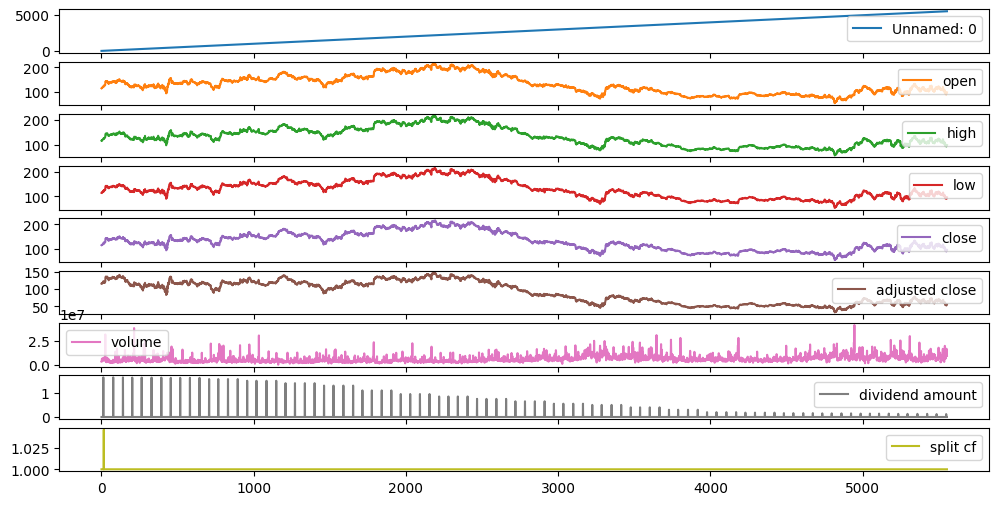

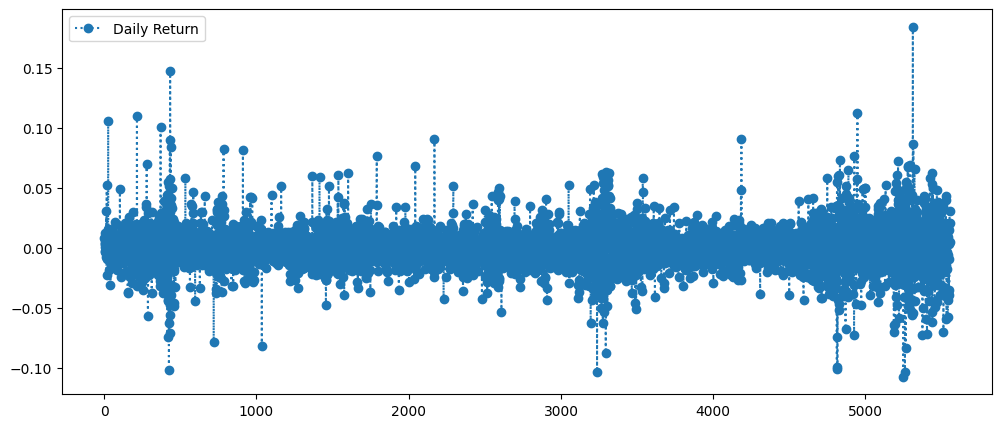

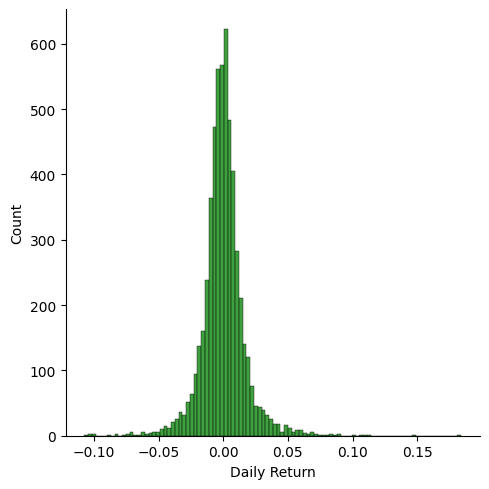

TypeError: Could not convert ['2021-11-262021-11-242021-11-232021-11-222021-11-192021-11-182021-11-172021-11-162021-11-152021-11-122021-11-112021-11-102021-11-092021-11-082021-11-052021-11-042021-11-032021-11-022021-11-012021-10-292021-10-282021-10-272021-10-262021-10-252021-10-222021-10-212021-10-202021-10-192021-10-182021-10-152021-10-142021-10-132021-10-122021-10-112021-10-082021-10-072021-10-062021-10-052021-10-042021-10-012021-09-302021-09-292021-09-282021-09-272021-09-242021-09-232021-09-222021-09-212021-09-202021-09-172021-09-162021-09-152021-09-142021-09-132021-09-102021-09-092021-09-082021-09-072021-09-032021-09-022021-09-012021-08-312021-08-302021-08-272021-08-262021-08-252021-08-242021-08-232021-08-202021-08-192021-08-182021-08-172021-08-162021-08-132021-08-122021-08-112021-08-102021-08-092021-08-062021-08-052021-08-042021-08-032021-08-022021-07-302021-07-292021-07-282021-07-272021-07-262021-07-232021-07-222021-07-212021-07-202021-07-192021-07-162021-07-152021-07-142021-07-132021-07-122021-07-092021-07-082021-07-072021-07-062021-07-022021-07-012021-06-302021-06-292021-06-282021-06-252021-06-242021-06-232021-06-222021-06-212021-06-182021-06-172021-06-162021-06-152021-06-142021-06-112021-06-102021-06-092021-06-082021-06-072021-06-042021-06-032021-06-022021-06-012021-05-282021-05-272021-05-262021-05-252021-05-242021-05-212021-05-202021-05-192021-05-182021-05-172021-05-142021-05-132021-05-122021-05-112021-05-102021-05-072021-05-062021-05-052021-05-042021-05-032021-04-302021-04-292021-04-282021-04-272021-04-262021-04-232021-04-222021-04-212021-04-202021-04-192021-04-162021-04-152021-04-142021-04-132021-04-122021-04-092021-04-082021-04-072021-04-062021-04-052021-04-012021-03-312021-03-302021-03-292021-03-262021-03-252021-03-242021-03-232021-03-222021-03-192021-03-182021-03-172021-03-162021-03-152021-03-122021-03-112021-03-102021-03-092021-03-082021-03-052021-03-042021-03-032021-03-022021-03-012021-02-262021-02-252021-02-242021-02-232021-02-222021-02-192021-02-182021-02-172021-02-162021-02-122021-02-112021-02-102021-02-092021-02-082021-02-052021-02-042021-02-032021-02-022021-02-012021-01-292021-01-282021-01-272021-01-262021-01-252021-01-222021-01-212021-01-202021-01-192021-01-152021-01-142021-01-132021-01-122021-01-112021-01-082021-01-072021-01-062021-01-052021-01-042020-12-312020-12-302020-12-292020-12-282020-12-242020-12-232020-12-222020-12-212020-12-182020-12-172020-12-162020-12-152020-12-142020-12-112020-12-102020-12-092020-12-082020-12-072020-12-042020-12-032020-12-022020-12-012020-11-302020-11-272020-11-252020-11-242020-11-232020-11-202020-11-192020-11-182020-11-172020-11-162020-11-132020-11-122020-11-112020-11-102020-11-092020-11-062020-11-052020-11-042020-11-032020-11-022020-10-302020-10-292020-10-282020-10-272020-10-262020-10-232020-10-222020-10-212020-10-202020-10-192020-10-162020-10-152020-10-142020-10-132020-10-122020-10-092020-10-082020-10-072020-10-062020-10-052020-10-022020-10-012020-09-302020-09-292020-09-282020-09-252020-09-242020-09-232020-09-222020-09-212020-09-182020-09-172020-09-162020-09-152020-09-142020-09-112020-09-102020-09-092020-09-082020-09-042020-09-032020-09-022020-09-012020-08-312020-08-282020-08-272020-08-262020-08-252020-08-242020-08-212020-08-202020-08-192020-08-182020-08-172020-08-142020-08-132020-08-122020-08-112020-08-102020-08-072020-08-062020-08-052020-08-042020-08-032020-07-312020-07-302020-07-292020-07-282020-07-272020-07-242020-07-232020-07-222020-07-212020-07-202020-07-172020-07-162020-07-152020-07-142020-07-132020-07-102020-07-092020-07-082020-07-072020-07-062020-07-022020-07-012020-06-302020-06-292020-06-262020-06-252020-06-242020-06-232020-06-222020-06-192020-06-182020-06-172020-06-162020-06-152020-06-122020-06-112020-06-102020-06-092020-06-082020-06-052020-06-042020-06-032020-06-022020-06-012020-05-292020-05-282020-05-272020-05-262020-05-222020-05-212020-05-202020-05-192020-05-182020-05-152020-05-142020-05-132020-05-122020-05-112020-05-082020-05-072020-05-062020-05-052020-05-042020-05-012020-04-302020-04-292020-04-282020-04-272020-04-242020-04-232020-04-222020-04-212020-04-202020-04-172020-04-162020-04-152020-04-142020-04-132020-04-092020-04-082020-04-072020-04-062020-04-032020-04-022020-04-012020-03-312020-03-302020-03-272020-03-262020-03-252020-03-242020-03-232020-03-202020-03-192020-03-182020-03-172020-03-162020-03-132020-03-122020-03-112020-03-102020-03-092020-03-062020-03-052020-03-042020-03-032020-03-022020-02-282020-02-272020-02-262020-02-252020-02-242020-02-212020-02-202020-02-192020-02-182020-02-142020-02-132020-02-122020-02-112020-02-102020-02-072020-02-062020-02-052020-02-042020-02-032020-01-312020-01-302020-01-292020-01-282020-01-272020-01-242020-01-232020-01-222020-01-212020-01-172020-01-162020-01-152020-01-142020-01-132020-01-102020-01-092020-01-082020-01-072020-01-062020-01-032020-01-022019-12-312019-12-302019-12-272019-12-262019-12-242019-12-232019-12-202019-12-192019-12-182019-12-172019-12-162019-12-132019-12-122019-12-112019-12-102019-12-092019-12-062019-12-052019-12-042019-12-032019-12-022019-11-292019-11-272019-11-262019-11-252019-11-222019-11-212019-11-202019-11-192019-11-182019-11-152019-11-142019-11-132019-11-122019-11-112019-11-082019-11-072019-11-062019-11-052019-11-042019-11-012019-10-312019-10-302019-10-292019-10-282019-10-252019-10-242019-10-232019-10-222019-10-212019-10-182019-10-172019-10-162019-10-152019-10-142019-10-112019-10-102019-10-092019-10-082019-10-072019-10-042019-10-032019-10-022019-10-012019-09-302019-09-272019-09-262019-09-252019-09-242019-09-232019-09-202019-09-192019-09-182019-09-172019-09-162019-09-132019-09-122019-09-112019-09-102019-09-092019-09-062019-09-052019-09-042019-09-032019-08-302019-08-292019-08-282019-08-272019-08-262019-08-232019-08-222019-08-212019-08-202019-08-192019-08-162019-08-152019-08-142019-08-132019-08-122019-08-092019-08-082019-08-072019-08-062019-08-052019-08-022019-08-012019-07-312019-07-302019-07-292019-07-262019-07-252019-07-242019-07-232019-07-222019-07-192019-07-182019-07-172019-07-162019-07-152019-07-122019-07-112019-07-102019-07-092019-07-082019-07-052019-07-032019-07-022019-07-012019-06-282019-06-272019-06-262019-06-252019-06-242019-06-212019-06-202019-06-192019-06-182019-06-172019-06-142019-06-132019-06-122019-06-112019-06-102019-06-072019-06-062019-06-052019-06-042019-06-032019-05-312019-05-302019-05-292019-05-282019-05-242019-05-232019-05-222019-05-212019-05-202019-05-172019-05-162019-05-152019-05-142019-05-132019-05-102019-05-092019-05-082019-05-072019-05-062019-05-032019-05-022019-05-012019-04-302019-04-292019-04-262019-04-252019-04-242019-04-232019-04-222019-04-182019-04-172019-04-162019-04-152019-04-122019-04-112019-04-102019-04-092019-04-082019-04-052019-04-042019-04-032019-04-022019-04-012019-03-292019-03-282019-03-272019-03-262019-03-252019-03-222019-03-212019-03-202019-03-192019-03-182019-03-152019-03-142019-03-132019-03-122019-03-112019-03-082019-03-072019-03-062019-03-052019-03-042019-03-012019-02-282019-02-272019-02-262019-02-252019-02-222019-02-212019-02-202019-02-192019-02-152019-02-142019-02-132019-02-122019-02-112019-02-082019-02-072019-02-062019-02-052019-02-042019-02-012019-01-312019-01-302019-01-292019-01-282019-01-252019-01-242019-01-232019-01-222019-01-182019-01-172019-01-162019-01-152019-01-142019-01-112019-01-102019-01-092019-01-082019-01-072019-01-042019-01-032019-01-022018-12-312018-12-282018-12-272018-12-262018-12-242018-12-212018-12-202018-12-192018-12-182018-12-172018-12-142018-12-132018-12-122018-12-112018-12-102018-12-072018-12-062018-12-042018-12-032018-11-302018-11-292018-11-282018-11-272018-11-262018-11-232018-11-212018-11-202018-11-192018-11-162018-11-152018-11-142018-11-132018-11-122018-11-092018-11-082018-11-072018-11-062018-11-052018-11-022018-11-012018-10-312018-10-302018-10-292018-10-262018-10-252018-10-242018-10-232018-10-222018-10-192018-10-182018-10-172018-10-162018-10-152018-10-122018-10-112018-10-102018-10-092018-10-082018-10-052018-10-042018-10-032018-10-022018-10-012018-09-282018-09-272018-09-262018-09-252018-09-242018-09-212018-09-202018-09-192018-09-182018-09-172018-09-142018-09-132018-09-122018-09-112018-09-102018-09-072018-09-062018-09-052018-09-042018-08-312018-08-302018-08-292018-08-282018-08-272018-08-242018-08-232018-08-222018-08-212018-08-202018-08-172018-08-162018-08-152018-08-142018-08-132018-08-102018-08-092018-08-082018-08-072018-08-062018-08-032018-08-022018-08-012018-07-312018-07-302018-07-272018-07-262018-07-252018-07-242018-07-232018-07-202018-07-192018-07-182018-07-172018-07-162018-07-132018-07-122018-07-112018-07-102018-07-092018-07-062018-07-052018-07-032018-07-022018-06-292018-06-282018-06-272018-06-262018-06-252018-06-222018-06-212018-06-202018-06-192018-06-182018-06-152018-06-142018-06-132018-06-122018-06-112018-06-082018-06-072018-06-062018-06-052018-06-042018-06-012018-05-312018-05-302018-05-292018-05-252018-05-242018-05-232018-05-222018-05-212018-05-182018-05-172018-05-162018-05-152018-05-142018-05-112018-05-102018-05-092018-05-082018-05-072018-05-042018-05-032018-05-022018-05-012018-04-302018-04-272018-04-262018-04-252018-04-242018-04-232018-04-202018-04-192018-04-182018-04-172018-04-162018-04-132018-04-122018-04-112018-04-102018-04-092018-04-062018-04-052018-04-042018-04-032018-04-022018-03-292018-03-282018-03-272018-03-262018-03-232018-03-222018-03-212018-03-202018-03-192018-03-162018-03-152018-03-142018-03-132018-03-122018-03-092018-03-082018-03-072018-03-062018-03-052018-03-022018-03-012018-02-282018-02-272018-02-262018-02-232018-02-222018-02-212018-02-202018-02-162018-02-152018-02-142018-02-132018-02-122018-02-092018-02-082018-02-072018-02-062018-02-052018-02-022018-02-012018-01-312018-01-302018-01-292018-01-262018-01-252018-01-242018-01-232018-01-222018-01-192018-01-182018-01-172018-01-162018-01-122018-01-112018-01-102018-01-092018-01-082018-01-052018-01-042018-01-032018-01-022017-12-292017-12-282017-12-272017-12-262017-12-222017-12-212017-12-202017-12-192017-12-182017-12-152017-12-142017-12-132017-12-122017-12-112017-12-082017-12-072017-12-062017-12-052017-12-042017-12-012017-11-302017-11-292017-11-282017-11-272017-11-242017-11-222017-11-212017-11-202017-11-172017-11-162017-11-152017-11-142017-11-132017-11-102017-11-092017-11-082017-11-072017-11-062017-11-032017-11-022017-11-012017-10-312017-10-302017-10-272017-10-262017-10-252017-10-242017-10-232017-10-202017-10-192017-10-182017-10-172017-10-162017-10-132017-10-122017-10-112017-10-102017-10-092017-10-062017-10-052017-10-042017-10-032017-10-022017-09-292017-09-282017-09-272017-09-262017-09-252017-09-222017-09-212017-09-202017-09-192017-09-182017-09-152017-09-142017-09-132017-09-122017-09-112017-09-082017-09-072017-09-062017-09-052017-09-012017-08-312017-08-302017-08-292017-08-282017-08-252017-08-242017-08-232017-08-222017-08-212017-08-182017-08-172017-08-162017-08-152017-08-142017-08-112017-08-102017-08-092017-08-082017-08-072017-08-042017-08-032017-08-022017-08-012017-07-312017-07-282017-07-272017-07-262017-07-252017-07-242017-07-212017-07-202017-07-192017-07-182017-07-172017-07-142017-07-132017-07-122017-07-112017-07-102017-07-072017-07-062017-07-052017-07-032017-06-302017-06-292017-06-282017-06-272017-06-262017-06-232017-06-222017-06-212017-06-202017-06-192017-06-162017-06-152017-06-142017-06-132017-06-122017-06-092017-06-082017-06-072017-06-062017-06-052017-06-022017-06-012017-05-312017-05-302017-05-262017-05-252017-05-242017-05-232017-05-222017-05-192017-05-182017-05-172017-05-162017-05-152017-05-122017-05-112017-05-102017-05-092017-05-082017-05-052017-05-042017-05-032017-05-022017-05-012017-04-282017-04-272017-04-262017-04-252017-04-242017-04-212017-04-202017-04-192017-04-182017-04-172017-04-132017-04-122017-04-112017-04-102017-04-072017-04-062017-04-052017-04-042017-04-032017-03-312017-03-302017-03-292017-03-282017-03-272017-03-242017-03-232017-03-222017-03-212017-03-202017-03-172017-03-162017-03-152017-03-142017-03-132017-03-102017-03-092017-03-082017-03-072017-03-062017-03-032017-03-022017-03-012017-02-282017-02-272017-02-242017-02-232017-02-222017-02-212017-02-172017-02-162017-02-152017-02-142017-02-132017-02-102017-02-092017-02-082017-02-072017-02-062017-02-032017-02-022017-02-012017-01-312017-01-302017-01-272017-01-262017-01-252017-01-242017-01-232017-01-202017-01-192017-01-182017-01-172017-01-132017-01-122017-01-112017-01-102017-01-092017-01-062017-01-052017-01-042017-01-032016-12-302016-12-292016-12-282016-12-272016-12-232016-12-222016-12-212016-12-202016-12-192016-12-162016-12-152016-12-142016-12-132016-12-122016-12-092016-12-082016-12-072016-12-062016-12-052016-12-022016-12-012016-11-302016-11-292016-11-282016-11-252016-11-232016-11-222016-11-212016-11-182016-11-172016-11-162016-11-152016-11-142016-11-112016-11-102016-11-092016-11-082016-11-072016-11-042016-11-032016-11-022016-11-012016-10-312016-10-282016-10-272016-10-262016-10-252016-10-242016-10-212016-10-202016-10-192016-10-182016-10-172016-10-142016-10-132016-10-122016-10-112016-10-102016-10-072016-10-062016-10-052016-10-042016-10-032016-09-302016-09-292016-09-282016-09-272016-09-262016-09-232016-09-222016-09-212016-09-202016-09-192016-09-162016-09-152016-09-142016-09-132016-09-122016-09-092016-09-082016-09-072016-09-062016-09-022016-09-012016-08-312016-08-302016-08-292016-08-262016-08-252016-08-242016-08-232016-08-222016-08-192016-08-182016-08-172016-08-162016-08-152016-08-122016-08-112016-08-102016-08-092016-08-082016-08-052016-08-042016-08-032016-08-022016-08-012016-07-292016-07-282016-07-272016-07-262016-07-252016-07-222016-07-212016-07-202016-07-192016-07-182016-07-152016-07-142016-07-132016-07-122016-07-112016-07-082016-07-072016-07-062016-07-052016-07-012016-06-302016-06-292016-06-282016-06-272016-06-242016-06-232016-06-222016-06-212016-06-202016-06-172016-06-162016-06-152016-06-142016-06-132016-06-102016-06-092016-06-082016-06-072016-06-062016-06-032016-06-022016-06-012016-05-312016-05-272016-05-262016-05-252016-05-242016-05-232016-05-202016-05-192016-05-182016-05-172016-05-162016-05-132016-05-122016-05-112016-05-102016-05-092016-05-062016-05-052016-05-042016-05-032016-05-022016-04-292016-04-282016-04-272016-04-262016-04-252016-04-222016-04-212016-04-202016-04-192016-04-182016-04-152016-04-142016-04-132016-04-122016-04-112016-04-082016-04-072016-04-062016-04-052016-04-042016-04-012016-03-312016-03-302016-03-292016-03-282016-03-242016-03-232016-03-222016-03-212016-03-182016-03-172016-03-162016-03-152016-03-142016-03-112016-03-102016-03-092016-03-082016-03-072016-03-042016-03-032016-03-022016-03-012016-02-292016-02-262016-02-252016-02-242016-02-232016-02-222016-02-192016-02-182016-02-172016-02-162016-02-122016-02-112016-02-102016-02-092016-02-082016-02-052016-02-042016-02-032016-02-022016-02-012016-01-292016-01-282016-01-272016-01-262016-01-252016-01-222016-01-212016-01-202016-01-192016-01-152016-01-142016-01-132016-01-122016-01-112016-01-082016-01-072016-01-062016-01-052016-01-042015-12-312015-12-302015-12-292015-12-282015-12-242015-12-232015-12-222015-12-212015-12-182015-12-172015-12-162015-12-152015-12-142015-12-112015-12-102015-12-092015-12-082015-12-072015-12-042015-12-032015-12-022015-12-012015-11-302015-11-272015-11-252015-11-242015-11-232015-11-202015-11-192015-11-182015-11-172015-11-162015-11-132015-11-122015-11-112015-11-102015-11-092015-11-062015-11-052015-11-042015-11-032015-11-022015-10-302015-10-292015-10-282015-10-272015-10-262015-10-232015-10-222015-10-212015-10-202015-10-192015-10-162015-10-152015-10-142015-10-132015-10-122015-10-092015-10-082015-10-072015-10-062015-10-052015-10-022015-10-012015-09-302015-09-292015-09-282015-09-252015-09-242015-09-232015-09-222015-09-212015-09-182015-09-172015-09-162015-09-152015-09-142015-09-112015-09-102015-09-092015-09-082015-09-042015-09-032015-09-022015-09-012015-08-312015-08-282015-08-272015-08-262015-08-252015-08-242015-08-212015-08-202015-08-192015-08-182015-08-172015-08-142015-08-132015-08-122015-08-112015-08-102015-08-072015-08-062015-08-052015-08-042015-08-032015-07-312015-07-302015-07-292015-07-282015-07-272015-07-242015-07-232015-07-222015-07-212015-07-202015-07-172015-07-162015-07-152015-07-142015-07-132015-07-102015-07-092015-07-082015-07-072015-07-062015-07-022015-07-012015-06-302015-06-292015-06-262015-06-252015-06-242015-06-232015-06-222015-06-192015-06-182015-06-172015-06-162015-06-152015-06-122015-06-112015-06-102015-06-092015-06-082015-06-052015-06-042015-06-032015-06-022015-06-012015-05-292015-05-282015-05-272015-05-262015-05-222015-05-212015-05-202015-05-192015-05-182015-05-152015-05-142015-05-132015-05-122015-05-112015-05-082015-05-072015-05-062015-05-052015-05-042015-05-012015-04-302015-04-292015-04-282015-04-272015-04-242015-04-232015-04-222015-04-212015-04-202015-04-172015-04-162015-04-152015-04-142015-04-132015-04-102015-04-092015-04-082015-04-072015-04-062015-04-022015-04-012015-03-312015-03-302015-03-272015-03-262015-03-252015-03-242015-03-232015-03-202015-03-192015-03-182015-03-172015-03-162015-03-132015-03-122015-03-112015-03-102015-03-092015-03-062015-03-052015-03-042015-03-032015-03-022015-02-272015-02-262015-02-252015-02-242015-02-232015-02-202015-02-192015-02-182015-02-172015-02-132015-02-122015-02-112015-02-102015-02-092015-02-062015-02-052015-02-042015-02-032015-02-022015-01-302015-01-292015-01-282015-01-272015-01-262015-01-232015-01-222015-01-212015-01-202015-01-162015-01-152015-01-142015-01-132015-01-122015-01-092015-01-082015-01-072015-01-062015-01-052015-01-022014-12-312014-12-302014-12-292014-12-262014-12-242014-12-232014-12-222014-12-192014-12-182014-12-172014-12-162014-12-152014-12-122014-12-112014-12-102014-12-092014-12-082014-12-052014-12-042014-12-032014-12-022014-12-012014-11-282014-11-262014-11-252014-11-242014-11-212014-11-202014-11-192014-11-182014-11-172014-11-142014-11-132014-11-122014-11-112014-11-102014-11-072014-11-062014-11-052014-11-042014-11-032014-10-312014-10-302014-10-292014-10-282014-10-272014-10-242014-10-232014-10-222014-10-212014-10-202014-10-172014-10-162014-10-152014-10-142014-10-132014-10-102014-10-092014-10-082014-10-072014-10-062014-10-032014-10-022014-10-012014-09-302014-09-292014-09-262014-09-252014-09-242014-09-232014-09-222014-09-192014-09-182014-09-172014-09-162014-09-152014-09-122014-09-112014-09-102014-09-092014-09-082014-09-052014-09-042014-09-032014-09-022014-08-292014-08-282014-08-272014-08-262014-08-252014-08-222014-08-212014-08-202014-08-192014-08-182014-08-152014-08-142014-08-132014-08-122014-08-112014-08-082014-08-072014-08-062014-08-052014-08-042014-08-012014-07-312014-07-302014-07-292014-07-282014-07-252014-07-242014-07-232014-07-222014-07-212014-07-182014-07-172014-07-162014-07-152014-07-142014-07-112014-07-102014-07-092014-07-082014-07-072014-07-032014-07-022014-07-012014-06-302014-06-272014-06-262014-06-252014-06-242014-06-232014-06-202014-06-192014-06-182014-06-172014-06-162014-06-132014-06-122014-06-112014-06-102014-06-092014-06-062014-06-052014-06-042014-06-032014-06-022014-05-302014-05-292014-05-282014-05-272014-05-232014-05-222014-05-212014-05-202014-05-192014-05-162014-05-152014-05-142014-05-132014-05-122014-05-092014-05-082014-05-072014-05-062014-05-052014-05-022014-05-012014-04-302014-04-292014-04-282014-04-252014-04-242014-04-232014-04-222014-04-212014-04-172014-04-162014-04-152014-04-142014-04-112014-04-102014-04-092014-04-082014-04-072014-04-042014-04-032014-04-022014-04-012014-03-312014-03-282014-03-272014-03-262014-03-252014-03-242014-03-212014-03-202014-03-192014-03-182014-03-172014-03-142014-03-132014-03-122014-03-112014-03-102014-03-072014-03-062014-03-052014-03-042014-03-032014-02-282014-02-272014-02-262014-02-252014-02-242014-02-212014-02-202014-02-192014-02-182014-02-142014-02-132014-02-122014-02-112014-02-102014-02-072014-02-062014-02-052014-02-042014-02-032014-01-312014-01-302014-01-292014-01-282014-01-272014-01-242014-01-232014-01-222014-01-212014-01-172014-01-162014-01-152014-01-142014-01-132014-01-102014-01-092014-01-082014-01-072014-01-062014-01-032014-01-022013-12-312013-12-302013-12-272013-12-262013-12-242013-12-232013-12-202013-12-192013-12-182013-12-172013-12-162013-12-132013-12-122013-12-112013-12-102013-12-092013-12-062013-12-052013-12-042013-12-032013-12-022013-11-292013-11-272013-11-262013-11-252013-11-222013-11-212013-11-202013-11-192013-11-182013-11-152013-11-142013-11-132013-11-122013-11-112013-11-082013-11-072013-11-062013-11-052013-11-042013-11-012013-10-312013-10-302013-10-292013-10-282013-10-252013-10-242013-10-232013-10-222013-10-212013-10-182013-10-172013-10-162013-10-152013-10-142013-10-112013-10-102013-10-092013-10-082013-10-072013-10-042013-10-032013-10-022013-10-012013-09-302013-09-272013-09-262013-09-252013-09-242013-09-232013-09-202013-09-192013-09-182013-09-172013-09-162013-09-132013-09-122013-09-112013-09-102013-09-092013-09-062013-09-052013-09-042013-09-032013-08-302013-08-292013-08-282013-08-272013-08-262013-08-232013-08-222013-08-212013-08-202013-08-192013-08-162013-08-152013-08-142013-08-132013-08-122013-08-092013-08-082013-08-072013-08-062013-08-052013-08-022013-08-012013-07-312013-07-302013-07-292013-07-262013-07-252013-07-242013-07-232013-07-222013-07-192013-07-182013-07-172013-07-162013-07-152013-07-122013-07-112013-07-102013-07-092013-07-082013-07-052013-07-032013-07-022013-07-012013-06-282013-06-272013-06-262013-06-252013-06-242013-06-212013-06-202013-06-192013-06-182013-06-172013-06-142013-06-132013-06-122013-06-112013-06-102013-06-072013-06-062013-06-052013-06-042013-06-032013-05-312013-05-302013-05-292013-05-282013-05-242013-05-232013-05-222013-05-212013-05-202013-05-172013-05-162013-05-152013-05-142013-05-132013-05-102013-05-092013-05-082013-05-072013-05-062013-05-032013-05-022013-05-012013-04-302013-04-292013-04-262013-04-252013-04-242013-04-232013-04-222013-04-192013-04-182013-04-172013-04-162013-04-152013-04-122013-04-112013-04-102013-04-092013-04-082013-04-052013-04-042013-04-032013-04-022013-04-012013-03-282013-03-272013-03-262013-03-252013-03-222013-03-212013-03-202013-03-192013-03-182013-03-152013-03-142013-03-132013-03-122013-03-112013-03-082013-03-072013-03-062013-03-052013-03-042013-03-012013-02-282013-02-272013-02-262013-02-252013-02-222013-02-212013-02-202013-02-192013-02-152013-02-142013-02-132013-02-122013-02-112013-02-082013-02-072013-02-062013-02-052013-02-042013-02-012013-01-312013-01-302013-01-292013-01-282013-01-252013-01-242013-01-232013-01-222013-01-182013-01-172013-01-162013-01-152013-01-142013-01-112013-01-102013-01-092013-01-082013-01-072013-01-042013-01-032013-01-022012-12-312012-12-282012-12-272012-12-262012-12-242012-12-212012-12-202012-12-192012-12-182012-12-172012-12-142012-12-132012-12-122012-12-112012-12-102012-12-072012-12-062012-12-052012-12-042012-12-032012-11-302012-11-292012-11-282012-11-272012-11-262012-11-232012-11-212012-11-202012-11-192012-11-162012-11-152012-11-142012-11-132012-11-122012-11-092012-11-082012-11-072012-11-062012-11-052012-11-022012-11-012012-10-312012-10-262012-10-252012-10-242012-10-232012-10-222012-10-192012-10-182012-10-172012-10-162012-10-152012-10-122012-10-112012-10-102012-10-092012-10-082012-10-052012-10-042012-10-032012-10-022012-10-012012-09-282012-09-272012-09-262012-09-252012-09-242012-09-212012-09-202012-09-192012-09-182012-09-172012-09-142012-09-132012-09-122012-09-112012-09-102012-09-072012-09-062012-09-052012-09-042012-08-312012-08-302012-08-292012-08-282012-08-272012-08-242012-08-232012-08-222012-08-212012-08-202012-08-172012-08-162012-08-152012-08-142012-08-132012-08-102012-08-092012-08-082012-08-072012-08-062012-08-032012-08-022012-08-012012-07-312012-07-302012-07-272012-07-262012-07-252012-07-242012-07-232012-07-202012-07-192012-07-182012-07-172012-07-162012-07-132012-07-122012-07-112012-07-102012-07-092012-07-062012-07-052012-07-032012-07-022012-06-292012-06-282012-06-272012-06-262012-06-252012-06-222012-06-212012-06-202012-06-192012-06-182012-06-152012-06-142012-06-132012-06-122012-06-112012-06-082012-06-072012-06-062012-06-052012-06-042012-06-012012-05-312012-05-302012-05-292012-05-252012-05-242012-05-232012-05-222012-05-212012-05-182012-05-172012-05-162012-05-152012-05-142012-05-112012-05-102012-05-092012-05-082012-05-072012-05-042012-05-032012-05-022012-05-012012-04-302012-04-272012-04-262012-04-252012-04-242012-04-232012-04-202012-04-192012-04-182012-04-172012-04-162012-04-132012-04-122012-04-112012-04-102012-04-092012-04-052012-04-042012-04-032012-04-022012-03-302012-03-292012-03-282012-03-272012-03-262012-03-232012-03-222012-03-212012-03-202012-03-192012-03-162012-03-152012-03-142012-03-132012-03-122012-03-092012-03-082012-03-072012-03-062012-03-052012-03-022012-03-012012-02-292012-02-282012-02-272012-02-242012-02-232012-02-222012-02-212012-02-172012-02-162012-02-152012-02-142012-02-132012-02-102012-02-092012-02-082012-02-072012-02-062012-02-032012-02-022012-02-012012-01-312012-01-302012-01-272012-01-262012-01-252012-01-242012-01-232012-01-202012-01-192012-01-182012-01-172012-01-132012-01-122012-01-112012-01-102012-01-092012-01-062012-01-052012-01-042012-01-032011-12-302011-12-292011-12-282011-12-272011-12-232011-12-222011-12-212011-12-202011-12-192011-12-162011-12-152011-12-142011-12-132011-12-122011-12-092011-12-082011-12-072011-12-062011-12-052011-12-022011-12-012011-11-302011-11-292011-11-282011-11-252011-11-232011-11-222011-11-212011-11-182011-11-172011-11-162011-11-152011-11-142011-11-112011-11-102011-11-092011-11-082011-11-072011-11-042011-11-032011-11-022011-11-012011-10-312011-10-282011-10-272011-10-262011-10-252011-10-242011-10-212011-10-202011-10-192011-10-182011-10-172011-10-142011-10-132011-10-122011-10-112011-10-102011-10-072011-10-062011-10-052011-10-042011-10-032011-09-302011-09-292011-09-282011-09-272011-09-262011-09-232011-09-222011-09-212011-09-202011-09-192011-09-162011-09-152011-09-142011-09-132011-09-122011-09-092011-09-082011-09-072011-09-062011-09-022011-09-012011-08-312011-08-302011-08-292011-08-262011-08-252011-08-242011-08-232011-08-222011-08-192011-08-182011-08-172011-08-162011-08-152011-08-122011-08-112011-08-102011-08-092011-08-082011-08-052011-08-042011-08-032011-08-022011-08-012011-07-292011-07-282011-07-272011-07-262011-07-252011-07-222011-07-212011-07-202011-07-192011-07-182011-07-152011-07-142011-07-132011-07-122011-07-112011-07-082011-07-072011-07-062011-07-052011-07-012011-06-302011-06-292011-06-282011-06-272011-06-242011-06-232011-06-222011-06-212011-06-202011-06-172011-06-162011-06-152011-06-142011-06-132011-06-102011-06-092011-06-082011-06-072011-06-062011-06-032011-06-022011-06-012011-05-312011-05-272011-05-262011-05-252011-05-242011-05-232011-05-202011-05-192011-05-182011-05-172011-05-162011-05-132011-05-122011-05-112011-05-102011-05-092011-05-062011-05-052011-05-042011-05-032011-05-022011-04-292011-04-282011-04-272011-04-262011-04-252011-04-212011-04-202011-04-192011-04-182011-04-152011-04-142011-04-132011-04-122011-04-112011-04-082011-04-072011-04-062011-04-052011-04-042011-04-012011-03-312011-03-302011-03-292011-03-282011-03-252011-03-242011-03-232011-03-222011-03-212011-03-182011-03-172011-03-162011-03-152011-03-142011-03-112011-03-102011-03-092011-03-082011-03-072011-03-042011-03-032011-03-022011-03-012011-02-282011-02-252011-02-242011-02-232011-02-222011-02-182011-02-172011-02-162011-02-152011-02-142011-02-112011-02-102011-02-092011-02-082011-02-072011-02-042011-02-032011-02-022011-02-012011-01-312011-01-282011-01-272011-01-262011-01-252011-01-242011-01-212011-01-202011-01-192011-01-182011-01-142011-01-132011-01-122011-01-112011-01-102011-01-072011-01-062011-01-052011-01-042011-01-032010-12-312010-12-302010-12-292010-12-282010-12-272010-12-232010-12-222010-12-212010-12-202010-12-172010-12-162010-12-152010-12-142010-12-132010-12-102010-12-092010-12-082010-12-072010-12-062010-12-032010-12-022010-12-012010-11-302010-11-292010-11-262010-11-242010-11-232010-11-222010-11-192010-11-182010-11-172010-11-162010-11-152010-11-122010-11-112010-11-102010-11-092010-11-082010-11-052010-11-042010-11-032010-11-022010-11-012010-10-292010-10-282010-10-272010-10-262010-10-252010-10-222010-10-212010-10-202010-10-192010-10-182010-10-152010-10-142010-10-132010-10-122010-10-112010-10-082010-10-072010-10-062010-10-052010-10-042010-10-012010-09-302010-09-292010-09-282010-09-272010-09-242010-09-232010-09-222010-09-212010-09-202010-09-172010-09-162010-09-152010-09-142010-09-132010-09-102010-09-092010-09-082010-09-072010-09-032010-09-022010-09-012010-08-312010-08-302010-08-272010-08-262010-08-252010-08-242010-08-232010-08-202010-08-192010-08-182010-08-172010-08-162010-08-132010-08-122010-08-112010-08-102010-08-092010-08-062010-08-052010-08-042010-08-032010-08-022010-07-302010-07-292010-07-282010-07-272010-07-262010-07-232010-07-222010-07-212010-07-202010-07-192010-07-162010-07-152010-07-142010-07-132010-07-122010-07-092010-07-082010-07-072010-07-062010-07-022010-07-012010-06-302010-06-292010-06-282010-06-252010-06-242010-06-232010-06-222010-06-212010-06-182010-06-172010-06-162010-06-152010-06-142010-06-112010-06-102010-06-092010-06-082010-06-072010-06-042010-06-032010-06-022010-06-012010-05-282010-05-272010-05-262010-05-252010-05-242010-05-212010-05-202010-05-192010-05-182010-05-172010-05-142010-05-132010-05-122010-05-112010-05-102010-05-072010-05-062010-05-052010-05-042010-05-032010-04-302010-04-292010-04-282010-04-272010-04-262010-04-232010-04-222010-04-212010-04-202010-04-192010-04-162010-04-152010-04-142010-04-132010-04-122010-04-092010-04-082010-04-072010-04-062010-04-052010-04-012010-03-312010-03-302010-03-292010-03-262010-03-252010-03-242010-03-232010-03-222010-03-192010-03-182010-03-172010-03-162010-03-152010-03-122010-03-112010-03-102010-03-092010-03-082010-03-052010-03-042010-03-032010-03-022010-03-012010-02-262010-02-252010-02-242010-02-232010-02-222010-02-192010-02-182010-02-172010-02-162010-02-122010-02-112010-02-102010-02-092010-02-082010-02-052010-02-042010-02-032010-02-022010-02-012010-01-292010-01-282010-01-272010-01-262010-01-252010-01-222010-01-212010-01-202010-01-192010-01-152010-01-142010-01-132010-01-122010-01-112010-01-082010-01-072010-01-062010-01-052010-01-042009-12-312009-12-302009-12-292009-12-282009-12-242009-12-232009-12-222009-12-212009-12-182009-12-172009-12-162009-12-152009-12-142009-12-112009-12-102009-12-092009-12-082009-12-072009-12-042009-12-032009-12-022009-12-012009-11-302009-11-272009-11-252009-11-242009-11-232009-11-202009-11-192009-11-182009-11-172009-11-162009-11-132009-11-122009-11-112009-11-102009-11-092009-11-062009-11-052009-11-042009-11-032009-11-022009-10-302009-10-292009-10-282009-10-272009-10-262009-10-232009-10-222009-10-212009-10-202009-10-192009-10-162009-10-152009-10-142009-10-132009-10-122009-10-092009-10-082009-10-072009-10-062009-10-052009-10-022009-10-012009-09-302009-09-292009-09-282009-09-252009-09-242009-09-232009-09-222009-09-212009-09-182009-09-172009-09-162009-09-152009-09-142009-09-112009-09-102009-09-092009-09-082009-09-042009-09-032009-09-022009-09-012009-08-312009-08-282009-08-272009-08-262009-08-252009-08-242009-08-212009-08-202009-08-192009-08-182009-08-172009-08-142009-08-132009-08-122009-08-112009-08-102009-08-072009-08-062009-08-052009-08-042009-08-032009-07-312009-07-302009-07-292009-07-282009-07-272009-07-242009-07-232009-07-222009-07-212009-07-202009-07-172009-07-162009-07-152009-07-142009-07-132009-07-102009-07-092009-07-082009-07-072009-07-062009-07-022009-07-012009-06-302009-06-292009-06-262009-06-252009-06-242009-06-232009-06-222009-06-192009-06-182009-06-172009-06-162009-06-152009-06-122009-06-112009-06-102009-06-092009-06-082009-06-052009-06-042009-06-032009-06-022009-06-012009-05-292009-05-282009-05-272009-05-262009-05-222009-05-212009-05-202009-05-192009-05-182009-05-152009-05-142009-05-132009-05-122009-05-112009-05-082009-05-072009-05-062009-05-052009-05-042009-05-012009-04-302009-04-292009-04-282009-04-272009-04-242009-04-232009-04-222009-04-212009-04-202009-04-172009-04-162009-04-152009-04-142009-04-132009-04-092009-04-082009-04-072009-04-062009-04-032009-04-022009-04-012009-03-312009-03-302009-03-272009-03-262009-03-252009-03-242009-03-232009-03-202009-03-192009-03-182009-03-172009-03-162009-03-132009-03-122009-03-112009-03-102009-03-092009-03-062009-03-052009-03-042009-03-032009-03-022009-02-272009-02-262009-02-252009-02-242009-02-232009-02-202009-02-192009-02-182009-02-172009-02-132009-02-122009-02-112009-02-102009-02-092009-02-062009-02-052009-02-042009-02-032009-02-022009-01-302009-01-292009-01-282009-01-272009-01-262009-01-232009-01-222009-01-212009-01-202009-01-162009-01-152009-01-142009-01-132009-01-122009-01-092009-01-082009-01-072009-01-062009-01-052009-01-022008-12-312008-12-302008-12-292008-12-262008-12-242008-12-232008-12-222008-12-192008-12-182008-12-172008-12-162008-12-152008-12-122008-12-112008-12-102008-12-092008-12-082008-12-052008-12-042008-12-032008-12-022008-12-012008-11-282008-11-262008-11-252008-11-242008-11-212008-11-202008-11-192008-11-182008-11-172008-11-142008-11-132008-11-122008-11-112008-11-102008-11-072008-11-062008-11-052008-11-042008-11-032008-10-312008-10-302008-10-292008-10-282008-10-272008-10-242008-10-232008-10-222008-10-212008-10-202008-10-172008-10-162008-10-152008-10-142008-10-132008-10-102008-10-092008-10-082008-10-072008-10-062008-10-032008-10-022008-10-012008-09-302008-09-292008-09-262008-09-252008-09-242008-09-232008-09-222008-09-192008-09-182008-09-172008-09-162008-09-152008-09-122008-09-112008-09-102008-09-092008-09-082008-09-052008-09-042008-09-032008-09-022008-08-292008-08-282008-08-272008-08-262008-08-252008-08-222008-08-212008-08-202008-08-192008-08-182008-08-152008-08-142008-08-132008-08-122008-08-112008-08-082008-08-072008-08-062008-08-052008-08-042008-08-012008-07-312008-07-302008-07-292008-07-282008-07-252008-07-242008-07-232008-07-222008-07-212008-07-182008-07-172008-07-162008-07-152008-07-142008-07-112008-07-102008-07-092008-07-082008-07-072008-07-032008-07-022008-07-012008-06-302008-06-272008-06-262008-06-252008-06-242008-06-232008-06-202008-06-192008-06-182008-06-172008-06-162008-06-132008-06-122008-06-112008-06-102008-06-092008-06-062008-06-052008-06-042008-06-032008-06-022008-05-302008-05-292008-05-282008-05-272008-05-232008-05-222008-05-212008-05-202008-05-192008-05-162008-05-152008-05-142008-05-132008-05-122008-05-092008-05-082008-05-072008-05-062008-05-052008-05-022008-05-012008-04-302008-04-292008-04-282008-04-252008-04-242008-04-232008-04-222008-04-212008-04-182008-04-172008-04-162008-04-152008-04-142008-04-112008-04-102008-04-092008-04-082008-04-072008-04-042008-04-032008-04-022008-04-012008-03-312008-03-282008-03-272008-03-262008-03-252008-03-242008-03-202008-03-192008-03-182008-03-172008-03-142008-03-132008-03-122008-03-112008-03-102008-03-072008-03-062008-03-052008-03-042008-03-032008-02-292008-02-282008-02-272008-02-262008-02-252008-02-222008-02-212008-02-202008-02-192008-02-152008-02-142008-02-132008-02-122008-02-112008-02-082008-02-072008-02-062008-02-052008-02-042008-02-012008-01-312008-01-302008-01-292008-01-282008-01-252008-01-242008-01-232008-01-222008-01-182008-01-172008-01-162008-01-152008-01-142008-01-112008-01-102008-01-092008-01-082008-01-072008-01-042008-01-032008-01-022007-12-312007-12-282007-12-272007-12-262007-12-242007-12-212007-12-202007-12-192007-12-182007-12-172007-12-142007-12-132007-12-122007-12-112007-12-102007-12-072007-12-062007-12-052007-12-042007-12-032007-11-302007-11-292007-11-282007-11-272007-11-262007-11-232007-11-212007-11-202007-11-192007-11-162007-11-152007-11-142007-11-132007-11-122007-11-092007-11-082007-11-072007-11-062007-11-052007-11-022007-11-012007-10-312007-10-302007-10-292007-10-262007-10-252007-10-242007-10-232007-10-222007-10-192007-10-182007-10-172007-10-162007-10-152007-10-122007-10-112007-10-102007-10-092007-10-082007-10-052007-10-042007-10-032007-10-022007-10-012007-09-282007-09-272007-09-262007-09-252007-09-242007-09-212007-09-202007-09-192007-09-182007-09-172007-09-142007-09-132007-09-122007-09-112007-09-102007-09-072007-09-062007-09-052007-09-042007-08-312007-08-302007-08-292007-08-282007-08-272007-08-242007-08-232007-08-222007-08-212007-08-202007-08-172007-08-162007-08-152007-08-142007-08-132007-08-102007-08-092007-08-082007-08-072007-08-062007-08-032007-08-022007-08-012007-07-312007-07-302007-07-272007-07-262007-07-252007-07-242007-07-232007-07-202007-07-192007-07-182007-07-172007-07-162007-07-132007-07-122007-07-112007-07-102007-07-092007-07-062007-07-052007-07-032007-07-022007-06-292007-06-282007-06-272007-06-262007-06-252007-06-222007-06-212007-06-202007-06-192007-06-182007-06-152007-06-142007-06-132007-06-122007-06-112007-06-082007-06-072007-06-062007-06-052007-06-042007-06-012007-05-312007-05-302007-05-292007-05-252007-05-242007-05-232007-05-222007-05-212007-05-182007-05-172007-05-162007-05-152007-05-142007-05-112007-05-102007-05-092007-05-082007-05-072007-05-042007-05-032007-05-022007-05-012007-04-302007-04-272007-04-262007-04-252007-04-242007-04-232007-04-202007-04-192007-04-182007-04-172007-04-162007-04-132007-04-122007-04-112007-04-102007-04-092007-04-052007-04-042007-04-032007-04-022007-03-302007-03-292007-03-282007-03-272007-03-262007-03-232007-03-222007-03-212007-03-202007-03-192007-03-162007-03-152007-03-142007-03-132007-03-122007-03-092007-03-082007-03-072007-03-062007-03-052007-03-022007-03-012007-02-282007-02-272007-02-262007-02-232007-02-222007-02-212007-02-202007-02-162007-02-152007-02-142007-02-132007-02-122007-02-092007-02-082007-02-072007-02-062007-02-052007-02-022007-02-012007-01-312007-01-302007-01-292007-01-262007-01-252007-01-242007-01-232007-01-222007-01-192007-01-182007-01-172007-01-162007-01-122007-01-112007-01-102007-01-092007-01-082007-01-052007-01-042007-01-032006-12-292006-12-282006-12-272006-12-262006-12-222006-12-212006-12-202006-12-192006-12-182006-12-152006-12-142006-12-132006-12-122006-12-112006-12-082006-12-072006-12-062006-12-052006-12-042006-12-012006-11-302006-11-292006-11-282006-11-272006-11-242006-11-222006-11-212006-11-202006-11-172006-11-162006-11-152006-11-142006-11-132006-11-102006-11-092006-11-082006-11-072006-11-062006-11-032006-11-022006-11-012006-10-312006-10-302006-10-272006-10-262006-10-252006-10-242006-10-232006-10-202006-10-192006-10-182006-10-172006-10-162006-10-132006-10-122006-10-112006-10-102006-10-092006-10-062006-10-052006-10-042006-10-032006-10-022006-09-292006-09-282006-09-272006-09-262006-09-252006-09-222006-09-212006-09-202006-09-192006-09-182006-09-152006-09-142006-09-132006-09-122006-09-112006-09-082006-09-072006-09-062006-09-052006-09-012006-08-312006-08-302006-08-292006-08-282006-08-252006-08-242006-08-232006-08-222006-08-212006-08-182006-08-172006-08-162006-08-152006-08-142006-08-112006-08-102006-08-092006-08-082006-08-072006-08-042006-08-032006-08-022006-08-012006-07-312006-07-282006-07-272006-07-262006-07-252006-07-242006-07-212006-07-202006-07-192006-07-182006-07-172006-07-142006-07-132006-07-122006-07-112006-07-102006-07-072006-07-062006-07-052006-07-032006-06-302006-06-292006-06-282006-06-272006-06-262006-06-232006-06-222006-06-212006-06-202006-06-192006-06-162006-06-152006-06-142006-06-132006-06-122006-06-092006-06-082006-06-072006-06-062006-06-052006-06-022006-06-012006-05-312006-05-302006-05-262006-05-252006-05-242006-05-232006-05-222006-05-192006-05-182006-05-172006-05-162006-05-152006-05-122006-05-112006-05-102006-05-092006-05-082006-05-052006-05-042006-05-032006-05-022006-05-012006-04-282006-04-272006-04-262006-04-252006-04-242006-04-212006-04-202006-04-192006-04-182006-04-172006-04-132006-04-122006-04-112006-04-102006-04-072006-04-062006-04-052006-04-042006-04-032006-03-312006-03-302006-03-292006-03-282006-03-272006-03-242006-03-232006-03-222006-03-212006-03-202006-03-172006-03-162006-03-152006-03-142006-03-132006-03-102006-03-092006-03-082006-03-072006-03-062006-03-032006-03-022006-03-012006-02-282006-02-272006-02-242006-02-232006-02-222006-02-212006-02-172006-02-162006-02-152006-02-142006-02-132006-02-102006-02-092006-02-082006-02-072006-02-062006-02-032006-02-022006-02-012006-01-312006-01-302006-01-272006-01-262006-01-252006-01-242006-01-232006-01-202006-01-192006-01-182006-01-172006-01-132006-01-122006-01-112006-01-102006-01-092006-01-062006-01-052006-01-042006-01-032005-12-302005-12-292005-12-282005-12-272005-12-232005-12-222005-12-212005-12-202005-12-192005-12-162005-12-152005-12-142005-12-132005-12-122005-12-092005-12-082005-12-072005-12-062005-12-052005-12-022005-12-012005-11-302005-11-292005-11-282005-11-252005-11-232005-11-222005-11-212005-11-182005-11-172005-11-162005-11-152005-11-142005-11-112005-11-102005-11-092005-11-082005-11-072005-11-042005-11-032005-11-022005-11-012005-10-312005-10-282005-10-272005-10-262005-10-252005-10-242005-10-212005-10-202005-10-192005-10-182005-10-172005-10-142005-10-132005-10-122005-10-112005-10-102005-10-072005-10-062005-10-052005-10-042005-10-032005-09-302005-09-292005-09-282005-09-272005-09-262005-09-232005-09-222005-09-212005-09-202005-09-192005-09-162005-09-152005-09-142005-09-132005-09-122005-09-092005-09-082005-09-072005-09-062005-09-022005-09-012005-08-312005-08-302005-08-292005-08-262005-08-252005-08-242005-08-232005-08-222005-08-192005-08-182005-08-172005-08-162005-08-152005-08-122005-08-112005-08-102005-08-092005-08-082005-08-052005-08-042005-08-032005-08-022005-08-012005-07-292005-07-282005-07-272005-07-262005-07-252005-07-222005-07-212005-07-202005-07-192005-07-182005-07-152005-07-142005-07-132005-07-122005-07-112005-07-082005-07-072005-07-062005-07-052005-07-012005-06-302005-06-292005-06-282005-06-272005-06-242005-06-232005-06-222005-06-212005-06-202005-06-172005-06-162005-06-152005-06-142005-06-132005-06-102005-06-092005-06-082005-06-072005-06-062005-06-032005-06-022005-06-012005-05-312005-05-272005-05-262005-05-252005-05-242005-05-232005-05-202005-05-192005-05-182005-05-172005-05-162005-05-132005-05-122005-05-112005-05-102005-05-092005-05-062005-05-052005-05-042005-05-032005-05-022005-04-292005-04-282005-04-272005-04-262005-04-252005-04-222005-04-212005-04-202005-04-192005-04-182005-04-152005-04-142005-04-132005-04-122005-04-112005-04-082005-04-072005-04-062005-04-052005-04-042005-04-012005-03-312005-03-302005-03-292005-03-282005-03-242005-03-232005-03-222005-03-212005-03-182005-03-172005-03-162005-03-152005-03-142005-03-112005-03-102005-03-092005-03-082005-03-072005-03-042005-03-032005-03-022005-03-012005-02-282005-02-252005-02-242005-02-232005-02-222005-02-182005-02-172005-02-162005-02-152005-02-142005-02-112005-02-102005-02-092005-02-082005-02-072005-02-042005-02-032005-02-022005-02-012005-01-312005-01-282005-01-272005-01-262005-01-252005-01-242005-01-212005-01-202005-01-192005-01-182005-01-142005-01-132005-01-122005-01-112005-01-102005-01-072005-01-062005-01-052005-01-042005-01-032004-12-312004-12-302004-12-292004-12-282004-12-272004-12-232004-12-222004-12-212004-12-202004-12-172004-12-162004-12-152004-12-142004-12-132004-12-102004-12-092004-12-082004-12-072004-12-062004-12-032004-12-022004-12-012004-11-302004-11-292004-11-262004-11-242004-11-232004-11-222004-11-192004-11-182004-11-172004-11-162004-11-152004-11-122004-11-112004-11-102004-11-092004-11-082004-11-052004-11-042004-11-032004-11-022004-11-012004-10-292004-10-282004-10-272004-10-262004-10-252004-10-222004-10-212004-10-202004-10-192004-10-182004-10-152004-10-142004-10-132004-10-122004-10-112004-10-082004-10-072004-10-062004-10-052004-10-042004-10-012004-09-302004-09-292004-09-282004-09-272004-09-242004-09-232004-09-222004-09-212004-09-202004-09-172004-09-162004-09-152004-09-142004-09-132004-09-102004-09-092004-09-082004-09-072004-09-032004-09-022004-09-012004-08-312004-08-302004-08-272004-08-262004-08-252004-08-242004-08-232004-08-202004-08-192004-08-182004-08-172004-08-162004-08-132004-08-122004-08-112004-08-102004-08-092004-08-062004-08-052004-08-042004-08-032004-08-022004-07-302004-07-292004-07-282004-07-272004-07-262004-07-232004-07-222004-07-212004-07-202004-07-192004-07-162004-07-152004-07-142004-07-132004-07-122004-07-092004-07-082004-07-072004-07-062004-07-022004-07-012004-06-302004-06-292004-06-282004-06-252004-06-242004-06-232004-06-222004-06-212004-06-182004-06-172004-06-162004-06-152004-06-142004-06-102004-06-092004-06-082004-06-072004-06-042004-06-032004-06-022004-06-012004-05-282004-05-272004-05-262004-05-252004-05-242004-05-212004-05-202004-05-192004-05-182004-05-172004-05-142004-05-132004-05-122004-05-112004-05-102004-05-072004-05-062004-05-052004-05-042004-05-032004-04-302004-04-292004-04-282004-04-272004-04-262004-04-232004-04-222004-04-212004-04-202004-04-192004-04-162004-04-152004-04-142004-04-132004-04-122004-04-082004-04-072004-04-062004-04-052004-04-022004-04-012004-03-312004-03-302004-03-292004-03-262004-03-252004-03-242004-03-232004-03-222004-03-192004-03-182004-03-172004-03-162004-03-152004-03-122004-03-112004-03-102004-03-092004-03-082004-03-052004-03-042004-03-032004-03-022004-03-012004-02-272004-02-262004-02-252004-02-242004-02-232004-02-202004-02-192004-02-182004-02-172004-02-132004-02-122004-02-112004-02-102004-02-092004-02-062004-02-052004-02-042004-02-032004-02-022004-01-302004-01-292004-01-282004-01-272004-01-262004-01-232004-01-222004-01-212004-01-202004-01-162004-01-152004-01-142004-01-132004-01-122004-01-092004-01-082004-01-072004-01-062004-01-052004-01-022003-12-312003-12-302003-12-292003-12-262003-12-242003-12-232003-12-222003-12-192003-12-182003-12-172003-12-162003-12-152003-12-122003-12-112003-12-102003-12-092003-12-082003-12-052003-12-042003-12-032003-12-022003-12-012003-11-282003-11-262003-11-252003-11-242003-11-212003-11-202003-11-192003-11-182003-11-172003-11-142003-11-132003-11-122003-11-112003-11-102003-11-072003-11-062003-11-052003-11-042003-11-032003-10-312003-10-302003-10-292003-10-282003-10-272003-10-242003-10-232003-10-222003-10-212003-10-202003-10-172003-10-162003-10-152003-10-142003-10-132003-10-102003-10-092003-10-082003-10-072003-10-062003-10-032003-10-022003-10-012003-09-302003-09-292003-09-262003-09-252003-09-242003-09-232003-09-222003-09-192003-09-182003-09-172003-09-162003-09-152003-09-122003-09-112003-09-102003-09-092003-09-082003-09-052003-09-042003-09-032003-09-022003-08-292003-08-282003-08-272003-08-262003-08-252003-08-222003-08-212003-08-202003-08-192003-08-182003-08-152003-08-142003-08-132003-08-122003-08-112003-08-082003-08-072003-08-062003-08-052003-08-042003-08-012003-07-312003-07-302003-07-292003-07-282003-07-252003-07-242003-07-232003-07-222003-07-212003-07-182003-07-172003-07-162003-07-152003-07-142003-07-112003-07-102003-07-092003-07-082003-07-072003-07-032003-07-022003-07-012003-06-302003-06-272003-06-262003-06-252003-06-242003-06-232003-06-202003-06-192003-06-182003-06-172003-06-162003-06-132003-06-122003-06-112003-06-102003-06-092003-06-062003-06-052003-06-042003-06-032003-06-022003-05-302003-05-292003-05-282003-05-272003-05-232003-05-222003-05-212003-05-202003-05-192003-05-162003-05-152003-05-142003-05-132003-05-122003-05-092003-05-082003-05-072003-05-062003-05-052003-05-022003-05-012003-04-302003-04-292003-04-282003-04-252003-04-242003-04-232003-04-222003-04-212003-04-172003-04-162003-04-152003-04-142003-04-112003-04-102003-04-092003-04-082003-04-072003-04-042003-04-032003-04-022003-04-012003-03-312003-03-282003-03-272003-03-262003-03-252003-03-242003-03-212003-03-202003-03-192003-03-182003-03-172003-03-142003-03-132003-03-122003-03-112003-03-102003-03-072003-03-062003-03-052003-03-042003-03-032003-02-282003-02-272003-02-262003-02-252003-02-242003-02-212003-02-202003-02-192003-02-182003-02-142003-02-132003-02-122003-02-112003-02-102003-02-072003-02-062003-02-052003-02-042003-02-032003-01-312003-01-302003-01-292003-01-282003-01-272003-01-242003-01-232003-01-222003-01-212003-01-172003-01-162003-01-152003-01-142003-01-132003-01-102003-01-092003-01-082003-01-072003-01-062003-01-032003-01-022002-12-312002-12-302002-12-272002-12-262002-12-242002-12-232002-12-202002-12-192002-12-182002-12-172002-12-162002-12-132002-12-122002-12-112002-12-102002-12-092002-12-062002-12-052002-12-042002-12-032002-12-022002-11-292002-11-272002-11-262002-11-252002-11-222002-11-212002-11-202002-11-192002-11-182002-11-152002-11-142002-11-132002-11-122002-11-112002-11-082002-11-072002-11-062002-11-052002-11-042002-11-012002-10-312002-10-302002-10-292002-10-282002-10-252002-10-242002-10-232002-10-222002-10-212002-10-182002-10-172002-10-162002-10-152002-10-142002-10-112002-10-102002-10-092002-10-082002-10-072002-10-042002-10-032002-10-022002-10-012002-09-302002-09-272002-09-262002-09-252002-09-242002-09-232002-09-202002-09-192002-09-182002-09-172002-09-162002-09-132002-09-122002-09-112002-09-102002-09-092002-09-062002-09-052002-09-042002-09-032002-08-302002-08-292002-08-282002-08-272002-08-262002-08-232002-08-222002-08-212002-08-202002-08-192002-08-162002-08-152002-08-142002-08-132002-08-122002-08-092002-08-082002-08-072002-08-062002-08-052002-08-022002-08-012002-07-312002-07-302002-07-292002-07-262002-07-252002-07-242002-07-232002-07-222002-07-192002-07-182002-07-172002-07-162002-07-152002-07-122002-07-112002-07-102002-07-092002-07-082002-07-052002-07-032002-07-022002-07-012002-06-282002-06-272002-06-262002-06-252002-06-242002-06-212002-06-202002-06-192002-06-182002-06-172002-06-142002-06-132002-06-122002-06-112002-06-102002-06-072002-06-062002-06-052002-06-042002-06-032002-05-312002-05-302002-05-292002-05-282002-05-242002-05-232002-05-222002-05-212002-05-202002-05-172002-05-162002-05-152002-05-142002-05-132002-05-102002-05-092002-05-082002-05-072002-05-062002-05-032002-05-022002-05-012002-04-302002-04-292002-04-262002-04-252002-04-242002-04-232002-04-222002-04-192002-04-182002-04-172002-04-162002-04-152002-04-122002-04-112002-04-102002-04-092002-04-082002-04-052002-04-042002-04-032002-04-022002-04-012002-03-282002-03-272002-03-262002-03-252002-03-222002-03-212002-03-202002-03-192002-03-182002-03-152002-03-142002-03-132002-03-122002-03-112002-03-082002-03-072002-03-062002-03-052002-03-042002-03-012002-02-282002-02-272002-02-262002-02-252002-02-222002-02-212002-02-202002-02-192002-02-152002-02-142002-02-132002-02-122002-02-112002-02-082002-02-072002-02-062002-02-052002-02-042002-02-012002-01-312002-01-302002-01-292002-01-282002-01-252002-01-242002-01-232002-01-222002-01-182002-01-172002-01-162002-01-152002-01-142002-01-112002-01-102002-01-092002-01-082002-01-072002-01-042002-01-032002-01-022001-12-312001-12-282001-12-272001-12-262001-12-242001-12-212001-12-202001-12-192001-12-182001-12-172001-12-142001-12-132001-12-122001-12-112001-12-102001-12-072001-12-062001-12-052001-12-042001-12-032001-11-302001-11-292001-11-282001-11-272001-11-262001-11-232001-11-212001-11-202001-11-192001-11-162001-11-152001-11-142001-11-132001-11-122001-11-092001-11-082001-11-072001-11-062001-11-052001-11-022001-11-012001-10-312001-10-302001-10-292001-10-262001-10-252001-10-242001-10-232001-10-222001-10-192001-10-182001-10-172001-10-162001-10-152001-10-122001-10-112001-10-102001-10-092001-10-082001-10-052001-10-042001-10-032001-10-022001-10-012001-09-282001-09-272001-09-262001-09-252001-09-242001-09-212001-09-202001-09-192001-09-182001-09-172001-09-102001-09-072001-09-062001-09-052001-09-042001-08-312001-08-302001-08-292001-08-282001-08-272001-08-242001-08-232001-08-222001-08-212001-08-202001-08-172001-08-162001-08-152001-08-142001-08-132001-08-102001-08-092001-08-082001-08-072001-08-062001-08-032001-08-022001-08-012001-07-312001-07-302001-07-272001-07-262001-07-252001-07-242001-07-232001-07-202001-07-192001-07-182001-07-172001-07-162001-07-132001-07-122001-07-112001-07-102001-07-092001-07-062001-07-052001-07-032001-07-022001-06-292001-06-282001-06-272001-06-262001-06-252001-06-222001-06-212001-06-202001-06-192001-06-182001-06-152001-06-142001-06-132001-06-122001-06-112001-06-082001-06-072001-06-062001-06-052001-06-042001-06-012001-05-312001-05-302001-05-292001-05-252001-05-242001-05-232001-05-222001-05-212001-05-182001-05-172001-05-162001-05-152001-05-142001-05-112001-05-102001-05-092001-05-082001-05-072001-05-042001-05-032001-05-022001-05-012001-04-302001-04-272001-04-262001-04-252001-04-242001-04-232001-04-202001-04-192001-04-182001-04-172001-04-162001-04-122001-04-112001-04-102001-04-092001-04-062001-04-052001-04-042001-04-032001-04-022001-03-302001-03-292001-03-282001-03-272001-03-262001-03-232001-03-222001-03-212001-03-202001-03-192001-03-162001-03-152001-03-142001-03-132001-03-122001-03-092001-03-082001-03-072001-03-062001-03-052001-03-022001-03-012001-02-282001-02-272001-02-262001-02-232001-02-222001-02-212001-02-202001-02-162001-02-152001-02-142001-02-132001-02-122001-02-092001-02-082001-02-072001-02-062001-02-052001-02-022001-02-012001-01-312001-01-302001-01-292001-01-262001-01-252001-01-242001-01-232001-01-222001-01-192001-01-182001-01-172001-01-162001-01-122001-01-112001-01-102001-01-092001-01-082001-01-052001-01-042001-01-032001-01-022000-12-292000-12-282000-12-272000-12-262000-12-222000-12-212000-12-202000-12-192000-12-182000-12-152000-12-142000-12-132000-12-122000-12-112000-12-082000-12-072000-12-062000-12-052000-12-042000-12-012000-11-302000-11-292000-11-282000-11-272000-11-242000-11-222000-11-212000-11-202000-11-172000-11-162000-11-152000-11-142000-11-132000-11-102000-11-092000-11-082000-11-072000-11-062000-11-032000-11-022000-11-012000-10-312000-10-302000-10-272000-10-262000-10-252000-10-242000-10-232000-10-202000-10-192000-10-182000-10-172000-10-162000-10-132000-10-122000-10-112000-10-102000-10-092000-10-062000-10-052000-10-042000-10-032000-10-022000-09-292000-09-282000-09-272000-09-262000-09-252000-09-222000-09-212000-09-202000-09-192000-09-182000-09-152000-09-142000-09-132000-09-122000-09-112000-09-082000-09-072000-09-062000-09-052000-09-012000-08-312000-08-302000-08-292000-08-282000-08-252000-08-242000-08-232000-08-222000-08-212000-08-182000-08-172000-08-162000-08-152000-08-142000-08-112000-08-102000-08-092000-08-082000-08-072000-08-042000-08-032000-08-022000-08-012000-07-312000-07-282000-07-272000-07-262000-07-252000-07-242000-07-212000-07-202000-07-192000-07-182000-07-172000-07-142000-07-132000-07-122000-07-112000-07-102000-07-072000-07-062000-07-052000-07-032000-06-302000-06-292000-06-282000-06-272000-06-262000-06-232000-06-222000-06-212000-06-202000-06-192000-06-162000-06-152000-06-142000-06-132000-06-122000-06-092000-06-082000-06-072000-06-062000-06-052000-06-022000-06-012000-05-312000-05-302000-05-262000-05-252000-05-242000-05-232000-05-222000-05-192000-05-182000-05-172000-05-162000-05-152000-05-122000-05-112000-05-102000-05-092000-05-082000-05-052000-05-042000-05-032000-05-022000-05-012000-04-282000-04-272000-04-262000-04-252000-04-242000-04-202000-04-192000-04-182000-04-172000-04-142000-04-132000-04-122000-04-112000-04-102000-04-072000-04-062000-04-052000-04-042000-04-032000-03-312000-03-302000-03-292000-03-282000-03-272000-03-242000-03-232000-03-222000-03-212000-03-202000-03-172000-03-162000-03-152000-03-142000-03-132000-03-102000-03-092000-03-082000-03-072000-03-062000-03-032000-03-022000-03-012000-02-292000-02-282000-02-252000-02-242000-02-232000-02-222000-02-182000-02-172000-02-162000-02-152000-02-142000-02-112000-02-102000-02-092000-02-082000-02-072000-02-042000-02-032000-02-022000-02-012000-01-312000-01-282000-01-272000-01-262000-01-252000-01-242000-01-212000-01-202000-01-192000-01-182000-01-142000-01-132000-01-122000-01-112000-01-102000-01-072000-01-062000-01-052000-01-042000-01-031999-12-311999-12-301999-12-291999-12-281999-12-271999-12-231999-12-221999-12-211999-12-201999-12-171999-12-161999-12-151999-12-141999-12-131999-12-101999-12-091999-12-081999-12-071999-12-061999-12-031999-12-021999-12-011999-11-301999-11-291999-11-261999-11-241999-11-231999-11-221999-11-191999-11-181999-11-171999-11-161999-11-151999-11-121999-11-111999-11-101999-11-091999-11-081999-11-051999-11-041999-11-031999-11-021999-11-01'] to numeric

> /usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py(1686)_ensure_numeric()
   1684                 except ValueError as err:
   1685                     # GH#29941 we get here with object arrays containing strs
-> 1686                     raise TypeError(f"Could not convert {x} to numeric") from err
   1687             else:
   1688                 if not np.any(np.imag(x)):

ipdb> q


In [ ]:
trainData.plot(legend=True,subplots=True, figsize = (12, 6))
plt.show()
#data['Close'].plot(legend=True, figsize = (12, 6))
#plt.show()
#data['Volume'].plot(legend=True,figsize=(12,7))
#plt.show()

trainData.shape
trainData.size
trainData.describe(include='all').T
trainData.dtypes
trainData.nunique()
ma_day = [10,50,100]

for ma in ma_day:
    column_name = "MA for %s days" %(str(ma))
    trainData[column_name] = trainData['close'].rolling(window=ma).mean()

trainData['Daily Return'] = trainData['close'].pct_change()
# plot the daily return percentage
trainData['Daily Return'].plot(figsize=(12,5),legend=True,linestyle=':',marker='o')
plt.show()

sns.displot(trainData['Daily Return'].dropna(),bins=100,color='green')
plt.show()

date=pd.DataFrame(trainData['date'])
closing_df1 = pd.DataFrame(trainData['close'])
close1  = closing_df1.rename(columns={"close": "data_close"})
close2=pd.concat([date,close1],axis=1)
close2.head()

trainData.reset_index(drop=True, inplace=True)
trainData.fillna(trainData.mean(), inplace=True)
trainData.head()

trainData.nunique()

trainData.sort_index(axis=1,ascending=True)

cols_plot = ['open', 'high', 'low','close','volume','MA for 10 days','MA for 50 days','MA for 100 days','Daily Return']
axes = trainData[cols_plot].plot(marker='.', alpha=0.7, linestyle='None', figsize=(11, 9), subplots=True)
for ax in axes:
    ax.set_ylabel('Daily trade')

plt.plot(trainData['close'], label="Close price")
plt.xlabel("Timestamp")
plt.ylabel("Closing price")
df = trainData
print(df)

trainData.isnull().sum()

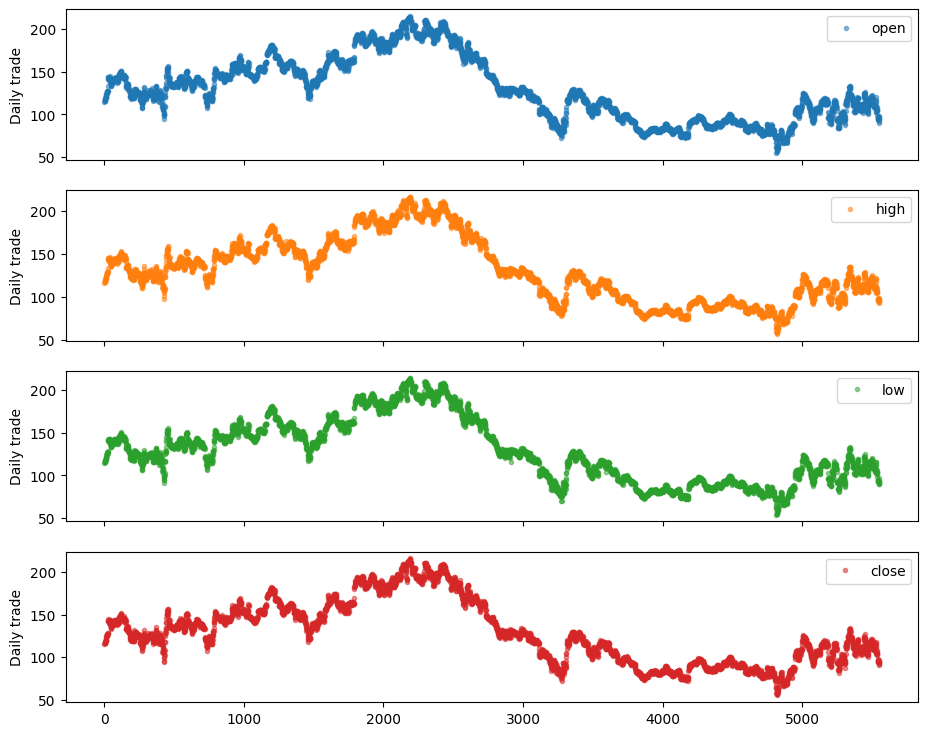

In [ ]:
cols_plot = ['open', 'high', 'low','close']
axes = trainData[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True)
for ax in axes:
    ax.set_ylabel('Daily trade')

      Unnamed: 0    open     high     low   close  adjusted close    volume  \
0              0  115.00  116.335  114.56  115.81      115.810000   3322012   
1              1  116.16  117.270  116.08  116.73      116.730000   3220802   
2              2  116.79  117.940  116.04  116.79      116.790000   4914995   
3              3  116.00  118.810  115.19  116.47      116.470000   6417218   
4              4  116.49  116.560  115.27  116.05      116.050000   5384548   
...          ...     ...      ...     ...     ...             ...       ...   
5550        5550   92.75   92.940   90.19   90.25       52.226608  13737600   
5551        5551   94.44   94.440   90.00   91.56       52.984689  16697600   
5552        5552   95.87   95.940   93.50   94.37       54.610803  10369100   
5553        5553   96.75   96.810   93.69   94.81       54.865426  11105400   
5554        5554   98.50   98.810   96.37   96.75       55.988081   9551800   

      dividend amount  split cf        date  MA for

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,5555.0,2.777000e+03,1.603735e+03,0.000000,1.388500e+03,2.777000e+03,4.165500e+03,5.554000e+03
open,5555.0,1.292537e+02,3.676820e+01,54.650000,9.654500e+01,1.250800e+02,1.549250e+02,2.153800e+02
high,5555.0,1.304287e+02,3.682377e+01,56.700000,9.789000e+01,1.263900e+02,1.559600e+02,2.159000e+02
low,5555.0,1.281585e+02,3.671867e+01,54.010000,9.570500e+01,1.240300e+02,1.538050e+02,2.143000e+02
close,5555.0,1.293074e+02,3.677710e+01,55.070000,9.677000e+01,1.251000e+02,1.550500e+02,2.158000e+02
adjusted close,5555.0,9.018515e+01,3.182330e+01,32.383320,5.810611e+01,9.137930e+01,1.190654e+02,1.471306e+02
volume,5555.0,6.069019e+06,3.331583e+06,192843.000000,3.843918e+06,5.244594e+06,7.333746e+06,4.120730e+07
dividend amount,5555.0,1.247165e-02,1.207171e-01,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.640000e+00
split cf,5555.0,1.000008e+00,6.171856e-04,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.046000e+00
MA for 10 days,5546.0,1.293462e+02,3.670709e+01,58.263000,9.691900e+01,1.252315e+02,1.550027e+02,2.131930e+02


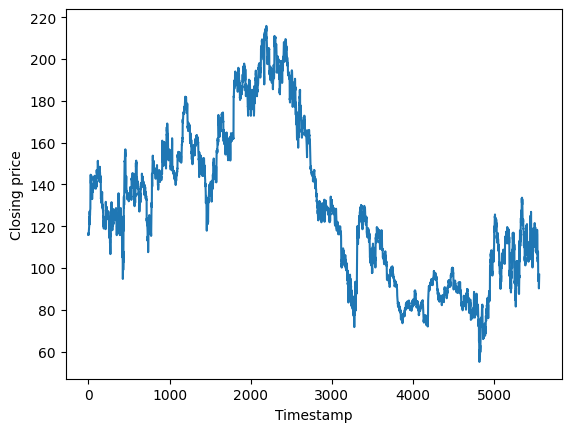

In [ ]:
plt.plot(trainData['close'], label="Close price")
plt.xlabel("Timestamp")
plt.ylabel("Closing price")
df = trainData
print(df)

df.describe().transpose()

In [130]:
from sklearn.model_selection import train_test_split

X = []
Y = []
window_size=100
for i in range(1 , len(df) - window_size -1 , 1):
    # ipdb.set_trace()
    first = df.iloc[i,2]
    temp = []
    temp2 = []
    for j in range(window_size):
        temp.append((df.iloc[i + j, 2] - first) / first)
    temp2.append((df.iloc[i + window_size, 2] - first) / first)
    X.append(np.array(temp).reshape(100, 1))
    Y.append(np.array(temp2))

x_train, x_temp, y_train, y_temp = train_test_split(X, Y, test_size=0.3, shuffle=False)

x_valid, x_test, y_valid, y_test = train_test_split(x_temp, y_temp, test_size=1/3, shuffle=False)

train_X = np.array(x_train)
valid_X = np.array(x_valid)
train_Y = np.array(y_train)
valid_Y = np.array(y_valid)
test_X = np.array(x_test)
test_Y = np.array(y_test)

print((train_X.shape))
print((train_Y.shape))

train_X = train_X.reshape(train_X.shape[0],100,1)
valid_X = valid_X.reshape(valid_X.shape[0],100,1)
test_X = test_X.reshape(test_X.shape[0],100,1)
print((train_X.shape))
print((valid_X.shape))
print((test_X.shape))

(3817, 100, 1)
(3817, 1)
(3817, 100, 1)
(1090, 100, 1)
(546, 100, 1)


In [131]:
# Assuming train_X, train_Y, test_X, test_Y are already loaded and converted to PyTorch tensors
train_dataset = TensorDataset(torch.tensor(train_X), torch.tensor(train_Y))
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataset = TensorDataset(torch.tensor(valid_X), torch.tensor(valid_Y))
valid_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

test_dataset = TensorDataset(torch.tensor(test_X), torch.tensor(test_Y))
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

train_X[0].shape

(100, 1)

# Prepare Test Data

In [ ]:
testData = pd.read_csv(os.path.join(dataDir, "data2.csv"))


In [ ]:
testData.head()
testData.count()

Unnamed: 0         4174
open               4174
high               4174
low                4174
close              4174
adjusted close     4174
volume             4174
dividend amount    4174
split cf           4174
date               4174
dtype: int64

In [ ]:
testData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4174 entries, 0 to 4173
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       4174 non-null   int64  
 1   open             4174 non-null   float64
 2   high             4174 non-null   float64
 3   low              4174 non-null   float64
 4   close            4174 non-null   float64
 5   adjusted close   4174 non-null   float64
 6   volume           4174 non-null   int64  
 7   dividend amount  4174 non-null   float64
 8   split cf         4174 non-null   float64
 9   date             4174 non-null   object 
dtypes: float64(7), int64(2), object(1)
memory usage: 326.2+ KB


In [ ]:
testData.isnull().sum()

Unnamed: 0         0
open               0
high               0
low                0
close              0
adjusted close     0
volume             0
dividend amount    0
split cf           0
date               0
dtype: int64

In [ ]:
testData.reset_index(drop=True, inplace=True)
testData.fillna(testData.mean(), inplace=True)
testData.head()

<ipython-input-20-e26a51f13531>:2: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  testData.fillna(testData.mean(), inplace=True)


,Unnamed: 0,open,high,low,close,adjusted close,volume,dividend amount,split cf,date
0,0,2470.0000,2474.5000,2405.0000,2409.8000,2409.8000,285664,0.0,1.0,2021-12-13
1,1,2444.0000,2466.1001,2430.5000,2458.9500,2458.9500,127783,0.0,1.0,2021-12-10
2,2,2431.1001,2474.8999,2425.4500,2455.8501,2455.8501,170477,0.0,1.0,2021-12-09
3,3,2427.0000,2431.4500,2407.1001,2417.3999,2417.3999,655272,0.0,1.0,2021-12-08
4,4,2381.7000,2403.7500,2373.5500,2381.6001,2381.6001,243374,0.0,1.0,2021-12-07


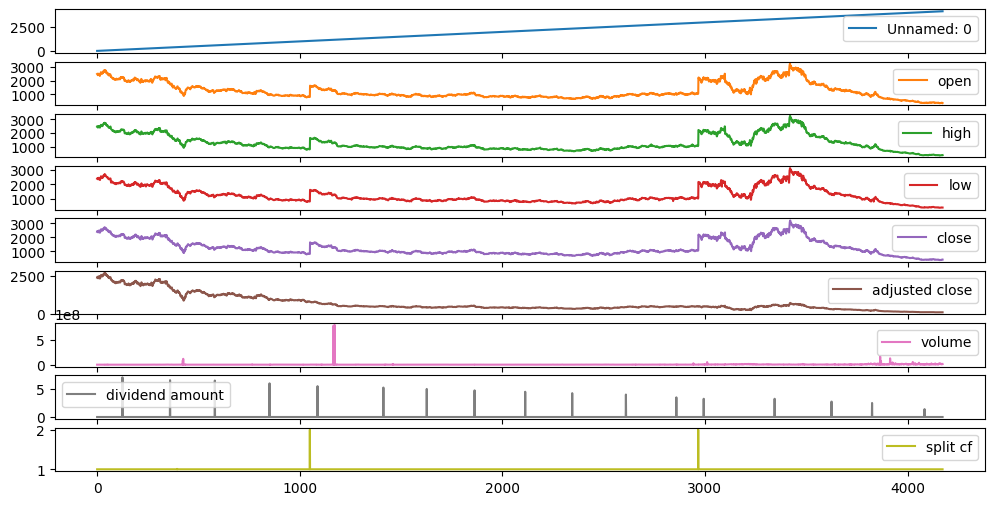

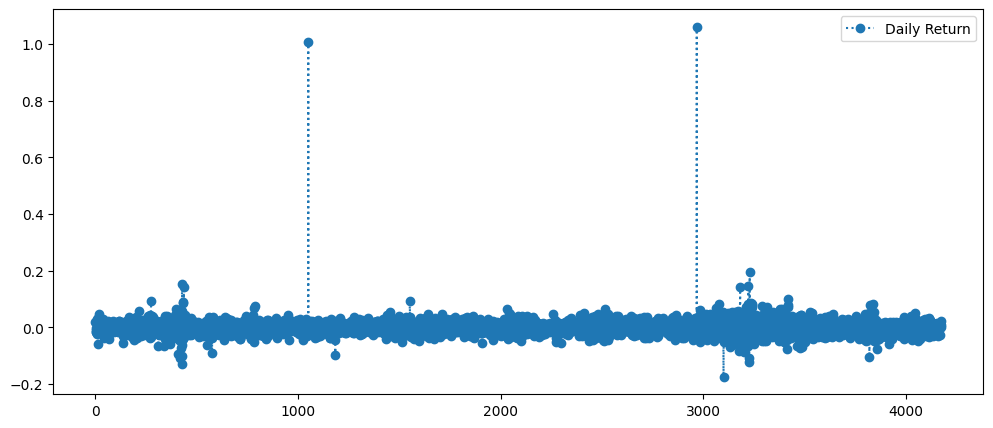

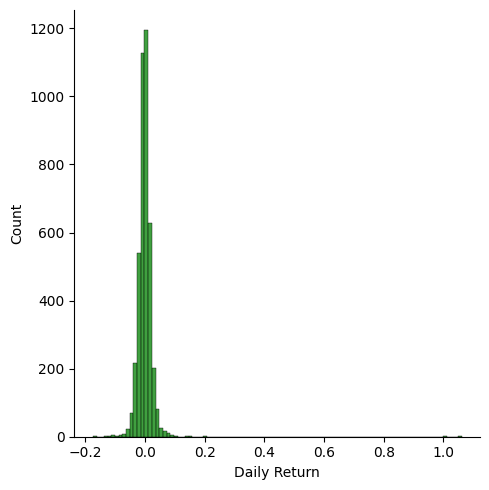

<ipython-input-21-c4da6437941b>:34: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  testData.fillna(testData.mean(), inplace=True)


      Unnamed: 0       open       high        low      close  adjusted close  \
0              0  2470.0000  2474.5000  2405.0000  2409.8000       2409.8000   
1              1  2444.0000  2466.1001  2430.5000  2458.9500       2458.9500   
2              2  2431.1001  2474.8999  2425.4500  2455.8501       2455.8501   
3              3  2427.0000  2431.4500  2407.1001  2417.3999       2417.3999   
4              4  2381.7000  2403.7500  2373.5500  2381.6001       2381.6001   
...          ...        ...        ...        ...        ...             ...   
4169        4169   394.7115   409.2889   394.3751   404.3176         87.1294   
4170        4170   392.4690   401.0658   390.6747   393.1791         84.7290   
4171        4171   392.8427   399.1970   385.9277   396.1319         85.3654   
4172        4172   399.9444   407.3827   395.8329   396.8048         85.5104   
4173        4173   388.7685   407.0464   388.7685   405.9997         87.4919   

        volume  dividend amount  split 

Unnamed: 0         0
open               0
high               0
low                0
close              0
adjusted close     0
volume             0
dividend amount    0
split cf           0
date               0
MA for 10 days     0
MA for 50 days     0
MA for 100 days    0
Daily Return       0
dtype: int64

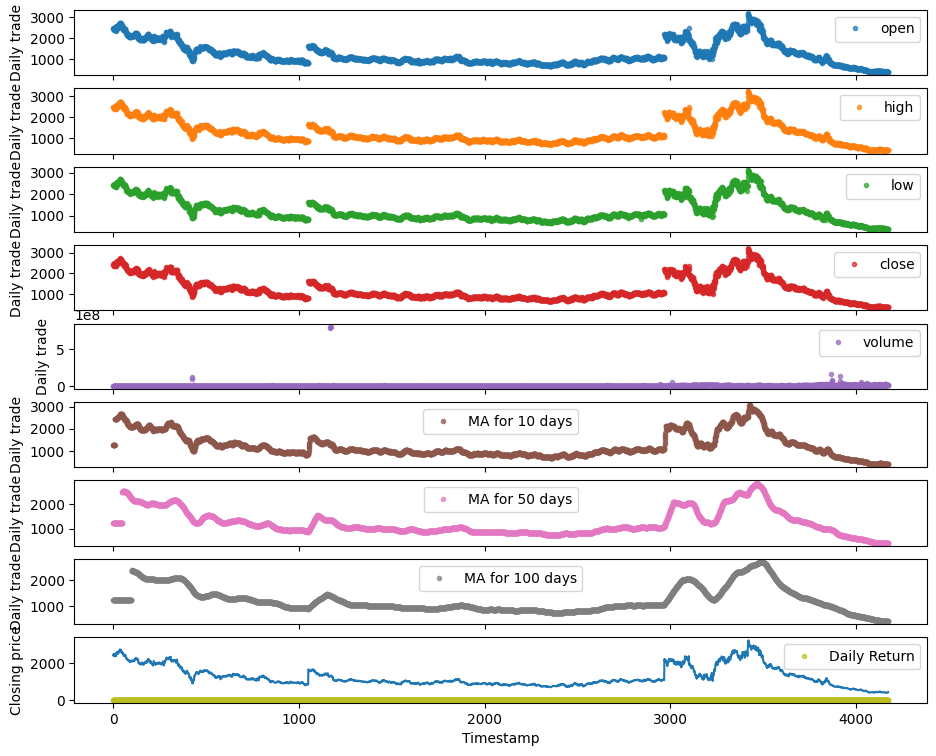

In [ ]:
testData.plot(legend=True,subplots=True, figsize = (12, 6))
plt.show()
#data['Close'].plot(legend=True, figsize = (12, 6))
#plt.show()
#data['Volume'].plot(legend=True,figsize=(12,7))
#plt.show()

testData.shape
testData.size
testData.describe(include='all').T
testData.dtypes
testData.nunique()
ma_day = [10,50,100]

for ma in ma_day:
    column_name = "MA for %s days" %(str(ma))
    testData[column_name] = testData['close'].rolling(window=ma).mean()

testData['Daily Return'] = testData['close'].pct_change()
# plot the daily return percentage
testData['Daily Return'].plot(figsize=(12,5),legend=True,linestyle=':',marker='o')
plt.show()

sns.displot(testData['Daily Return'].dropna(),bins=100,color='green')
plt.show()

date=pd.DataFrame(testData['date'])
closing_df1 = pd.DataFrame(testData['close'])
close1  = closing_df1.rename(columns={"close": "data_close"})
close2=pd.concat([date,close1],axis=1)
close2.head()

testData.reset_index(drop=True, inplace=True)
testData.fillna(testData.mean(), inplace=True)
testData.head()

testData.nunique()

testData.sort_index(axis=1,ascending=True)

cols_plot = ['open', 'high', 'low','close','volume','MA for 10 days','MA for 50 days','MA for 100 days','Daily Return']
axes = testData[cols_plot].plot(marker='.', alpha=0.7, linestyle='None', figsize=(11, 9), subplots=True)
for ax in axes:
    ax.set_ylabel('Daily trade')

plt.plot(testData['close'], label="Close price")
plt.xlabel("Timestamp")
plt.ylabel("Closing price")
df = testData
print(df)

testData.isnull().sum()

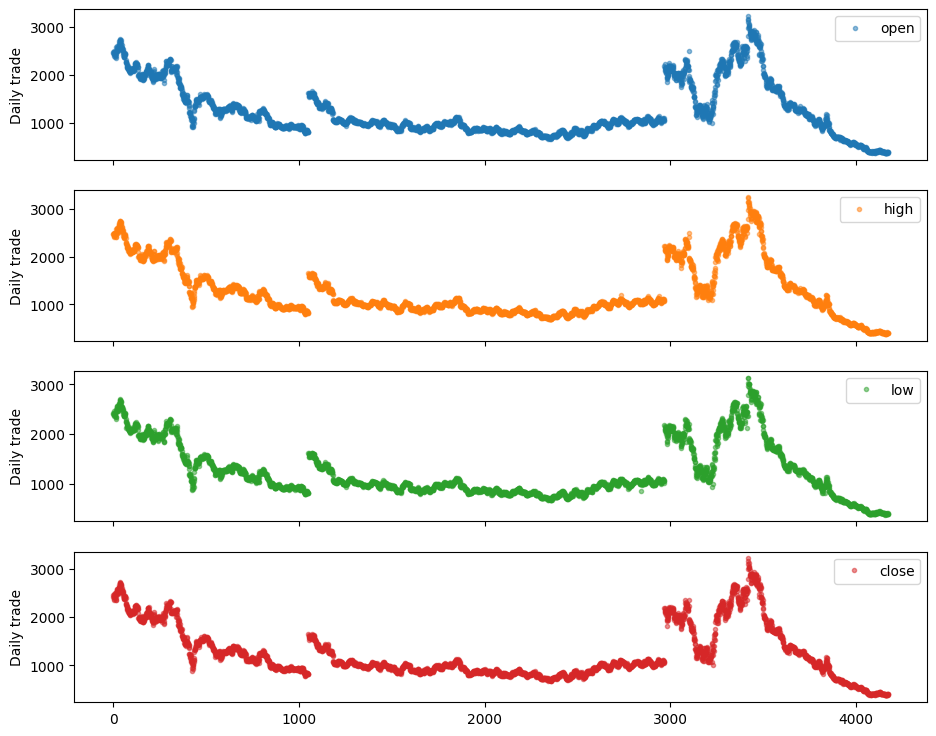

In [ ]:
cols_plot = ['open', 'high', 'low','close']
axes = testData[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True)
for ax in axes:
    ax.set_ylabel('Daily trade')

      Unnamed: 0       open       high        low      close  adjusted close  \
0              0  2470.0000  2474.5000  2405.0000  2409.8000       2409.8000   
1              1  2444.0000  2466.1001  2430.5000  2458.9500       2458.9500   
2              2  2431.1001  2474.8999  2425.4500  2455.8501       2455.8501   
3              3  2427.0000  2431.4500  2407.1001  2417.3999       2417.3999   
4              4  2381.7000  2403.7500  2373.5500  2381.6001       2381.6001   
...          ...        ...        ...        ...        ...             ...   
4169        4169   394.7115   409.2889   394.3751   404.3176         87.1294   
4170        4170   392.4690   401.0658   390.6747   393.1791         84.7290   
4171        4171   392.8427   399.1970   385.9277   396.1319         85.3654   
4172        4172   399.9444   407.3827   395.8329   396.8048         85.5104   
4173        4173   388.7685   407.0464   388.7685   405.9997         87.4919   

        volume  dividend amount  split 

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,4174.0,2.086500e+03,1.205074e+03,0.000000,1043.250000,2.086500e+03,3.129750e+03,4.173000e+03
open,4174.0,1.242971e+03,5.479572e+02,377.517600,881.074700,1.035500e+03,1.454950e+03,3.215999e+03
high,4174.0,1.260199e+03,5.583723e+02,381.517100,892.024775,1.049000e+03,1.474412e+03,3.252099e+03
low,4174.0,1.225259e+03,5.376021e+02,372.434300,870.999700,1.022300e+03,1.439900e+03,3.135249e+03
close,4174.0,1.242168e+03,5.479695e+02,374.826500,879.974725,1.034725e+03,1.457187e+03,3.216299e+03
adjusted close,4174.0,6.770600e+02,5.551478e+02,80.774100,378.554500,4.623361e+02,7.965003e+02,2.731500e+03
volume,4174.0,3.315318e+06,2.196122e+07,64847.000000,512955.250000,1.040084e+06,3.033747e+06,8.021841e+08
dividend amount,4174.0,1.804348e-02,2.984077e-01,0.000000,0.000000,0.000000e+00,0.000000e+00,7.000000e+00
split cf,4174.0,1.000481e+00,2.188747e-02,1.000000,1.000000,1.000000e+00,1.000000e+00,2.000000e+00
MA for 10 days,4174.0,1.241804e+03,5.437865e+02,382.227300,879.668465,1.036402e+03,1.453037e+03,3.071199e+03


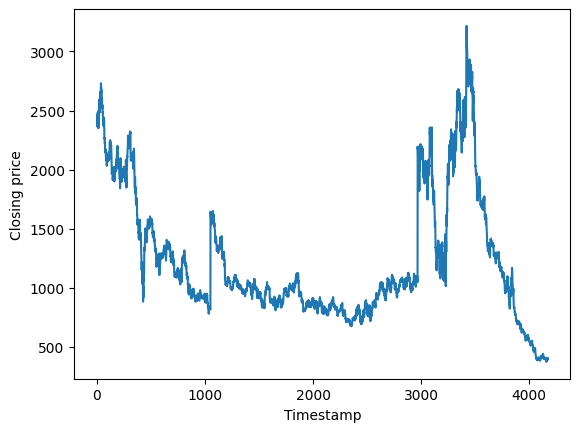

In [ ]:
plt.plot(testData['close'], label="Close price")
plt.xlabel("Timestamp")
plt.ylabel("Closing price")
df = testData
print(df)

df.describe().transpose()

In [ ]:
from sklearn.model_selection import train_test_split

X = []
Y = []
window_size=100
for i in range(1 , len(df) - window_size -1 , 1):
    first = df.iloc[i,2]
    temp = []
    temp2 = []
    for j in range(window_size):
        temp.append((df.iloc[i + j, 2] - first) / first)
    temp2.append((df.iloc[i + window_size, 2] - first) / first)
    X.append(np.array(temp).reshape(100, 1))
    Y.append(np.array(temp2).reshape(1, 1))

x_test1, x_test2, y_test1, y_test2 = train_test_split(X, Y, test_size=0.2, shuffle=True)

test1_X = np.array(x_test1)
test2_X = np.array(x_test2)
test1_Y = np.array(y_test1)
test2_Y = np.array(y_test2)

test1_X = test1_X.reshape(test1_X.shape[0],1,100,1)
test2_X = test2_X.reshape(test2_X.shape[0],1,100,1)

print((test1_X.shape))
print((test2_X.shape))

(3257, 1, 100, 1)
(815, 1, 100, 1)


In [ ]:
# Assuming train_X, train_Y, test_X, test_Y are already loaded and converted to PyTorch tensors
test1_dataset = TensorDataset(torch.tensor(test1_X), torch.tensor(test1_Y))
test1_loader = DataLoader(test1_dataset, batch_size=40, shuffle=True)

test2_dataset = TensorDataset(torch.tensor(test2_X), torch.tensor(test2_Y))
test2_loader = DataLoader(test2_dataset, batch_size=40, shuffle=False)

test1_X[0].shape

(1, 100, 1)

# Model Architecture

In [136]:
class CNNBlock(torch.nn.Module):
    def __init__(self):
        super(CNNBlock, self).__init__()
        self.conv1 = torch.nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3, padding = 1)
        self.pool = torch.nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv2 = torch.nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding = 1)
        self.conv3 = torch.nn.Conv1d(in_channels=128, out_channels=64, kernel_size=3, padding = 1)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        # x expected to be of shape [batch, seq_len, channels, width]
        # batch_size, seq_len, channels, width = x.size()
        # Merge batch and seq_len to apply convolutions

        # print (batch_size, seq_len, channels, width)
        # x = x.view(batch_size * seq_len, channels, width)
        # ipdb.set_trace()
        # x = torch.squeeze(x, 1)
        x = x.transpose(1, 2)
        # print (x.shape)
        x = self.conv1(x)

        x = self.relu(x)

        x = self.pool(x)

        x = self.conv2(x)

        x = self.relu(x)

        x = self.pool(x)

        x = self.conv3(x)

        x = self.relu(x)

        x = self.pool(x)
        # Prepare output shape [batch, seq_len, features]
        # print ("before flatten", x.shape)
        # x = x.view(batch_size, seq_len, -1)
        return x


In [153]:
class MyModel(torch.nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.cnn_block = CNNBlock()
        self.lstm1 = torch.nn.LSTM(input_size = 64, hidden_size = 256, batch_first=True, bidirectional=True)
        self.dropout = torch.nn.Dropout(0.2)
        self.lstm2 = torch.nn.LSTM(input_size=512, hidden_size=256, bidirectional=True, batch_first=True)
        self.final_dense = torch.nn.Linear(512, 1)
        self.flatten = torch.nn.Flatten()

    def forward(self, x):

        # ipdb.set_trace()

        # print (x.shape)
        # CNN part
        x = self.cnn_block(x)
        # ipdb.set_trace()

        # print ("After CNN", x.shape)
        # LSTM part
        x = x.transpose(1, 2)
        batch_size = x.shape[0]

        # x = self.flatten(x)
        # x = x.reshape(batch_size, -1)

        # print (x.shape)
        x, _ = self.lstm1(x)
        # print (x.shape)
        x = self.dropout(x)
        x, _ = self.lstm2(x)
        x = self.dropout(x)
        # Assuming x is [batch, seq_len, features] and you want features from the last time step
        # x = x[:, :]


        # Final Dense layer
        x = self.final_dense(x)
        # print ("Here", x.shape)
        return x[:, -1, :]

# Initialize Model

In [154]:
model = MyModel()
# summary(model, (inp.float()))
print (model)

MyModel(
  (cnn_block): CNNBlock(
    (conv1): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv3): Conv1d(128, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (relu): ReLU()
  )
  (lstm1): LSTM(64, 256, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (lstm2): LSTM(512, 256, batch_first=True, bidirectional=True)
  (final_dense): Linear(in_features=512, out_features=1, bias=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
)


In [155]:
for i, data in enumerate(train_loader):
  inp, tr = data
  inp = inp.float()
  tr = tr.float()
  print(inp.shape, tr.shape)

  out = model(inp)
  print(out)
  break

print (len(train_loader))
print (len(train_loader.dataset))

torch.Size([64, 100, 1]) torch.Size([64, 1])
tensor([[0.0373],
        [0.0582],
        [0.0493],
        [0.0523],
        [0.0478],
        [0.0401],
        [0.0471],
        [0.0435],
        [0.0458],
        [0.0556],
        [0.0391],
        [0.0575],
        [0.0495],
        [0.0605],
        [0.0584],
        [0.0507],
        [0.0499],
        [0.0545],
        [0.0407],
        [0.0524],
        [0.0541],
        [0.0393],
        [0.0459],
        [0.0469],
        [0.0466],
        [0.0421],
        [0.0612],
        [0.0682],
        [0.0504],
        [0.0538],
        [0.0404],
        [0.0545],
        [0.0813],
        [0.0590],
        [0.0567],
        [0.0487],
        [0.0506],
        [0.0567],
        [0.0582],
        [0.0451],
        [0.0451],
        [0.0454],
        [0.0560],
        [0.0484],
        [0.0496],
        [0.0505],
        [0.0437],
        [0.0630],
        [0.0454],
        [0.0573],
        [0.0445],
        [0.0479],
        [0.0642],
 

# Hyper-Parameters

In [156]:
train_losses = []
val_losses = []

In [157]:
config = {
    "lr"         : 0.002,
    "num_epochs" : 20,
    "batch_size" : 40  # Increase if your device can handle it
}

In [158]:
optimizer = torch.optim.AdamW(model.parameters(), lr=config['lr'])
mseLoss = torch.nn.MSELoss()
maeLoss = torch.nn.L1Loss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=1e-5)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.75, patience=3, threshold=0.001, min_lr=0, eps=1e-08)

# WanDB

In [ ]:
wandb.login(key="<YOUR WAND DB KEY>") #API Key is in your wandb account, under settings (wandb.ai/settings)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [149]:
run = wandb.init(
    name = "Post-Midterm-Attempt-6", ## Wandb creates random run names if you skip this field
    reinit = True, ### Allows reinitalizing runs when you re-run this cell
    # run_id = ### Insert specific run id here if you want to resume a previous run
    # resume = "must" ### You need this to resume previous runs, but comment out reinit = True when using this
    project = "idl-project", ### Project should be created in your wandb account
    config = config ### Wandb Config for your run
)

Predicted_Stock_Price,██▇▃▂▂▁▁▂▂▃▄▅▅▃▃▃▂▃▁▃▃▃▃▃▆▆▅▆▇▃▃▃▅▅▄▃▅▅▂
Real_Stock_Price,██▆▃▂▂▃▂▁▃▄▄▆▃▂▄▄▃▁▁▃▃▅▃▄▅▄▄▆▆▄▃▅▄▆▄▄▄▃▁
lr,████▇▇▇▆▆▅▄▄▃▃▂▂▂▁▁▁
train_loss_mae,█▃▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁
train_loss_mse,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss_mae,█▄▆▃▂▂▁▃▁▂▁▂▁▁▁▁▁▁▁▁
valid_loss_mse,█▄▅▂▂▂▁▂▁▂▁▂▁▁▁▁▁▁▁▁
Predicted_Stock_Price,68.78284
Real_Stock_Price,65.23447
lr,2e-05
train_loss_mae,0.02979


# Train Model

In [159]:
def train_model(model, train_loader, mseLoss, maeLoss, optimizer):

    model.train()
    train_loss = 0.0
    total_mae = 0.0  # For Mean Absolute Error
    total_mse = 0.0  # For Mean Squared Error

    batch_bar   = tqdm(total=len(train_loader), dynamic_ncols=True, leave=False, position=0, desc='Train', ncols=5)
    num_correct = 0

    for i, data in enumerate(train_loader):  # Assuming you have a DataLoader for your training data
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape(targets.shape[0], -1)

        optimizer.zero_grad()

        outputs = model(inputs)
        mse = mseLoss(outputs, targets)
        mae = maeLoss(outputs, targets)

        mse.backward()
        # mae.backward()
        optimizer.step()

        # train_loss += (mse.item() * inputs.size(0))
        # num_correct += int((torch.argmax(outputs, axis=1) == targets).sum())
        total_mse += float(mse.item() * inputs.size(0))  # Accumulate MSE; it's equivalent to the loss if using MSELoss
        total_mae += float(mae.item() * inputs.size(0))
        batch_bar.set_postfix(
            loss="{:.04f}".format(float(total_mse / (i + 1))),
            # acc= "{:.04f}%".format(100 * num_correct / (40 * (i + 1))),
            lr="{:.06f}".format(float(optimizer.param_groups[0]['lr'])))

        batch_bar.update() # Update tqdm bar
    batch_bar.close() # Need this to close the tqdm bar

    # avg_loss = train_loss / len(train_loader.dataset)
    avg_mse = total_mse / len(train_loader.dataset)  # Average MSE over all samples
    avg_mae = total_mae / len(train_loader.dataset)
    # train_losses.append(avg_loss)

    return avg_mse, avg_mae

# Validate Model

In [160]:
def validate_model(model, valid_loader, mseLoss, maeLoss):

    model.eval()  # Set model to evaluation mode

    batch_bar = tqdm(total=len(valid_loader), dynamic_ncols=True, position=0, leave=False, desc='Val')

    total_loss = 0.0
    num_correct = 0
    total_mae = 0.0  # For Mean Absolute Error
    total_mse = 0.0  # For Mean Squared Error

    with torch.no_grad():  # No gradients needed for validation
        for inputs, targets in valid_loader:
            inputs, targets = inputs.float(), targets.float()
            targets = targets.reshape(targets.shape[0], -1)
            outputs = model(inputs)
            loss = mseLoss(outputs, targets)
            mae = maeLoss(outputs, targets)

            # total_loss += float(loss.item() * inputs.size(0))
            total_mse += float(loss.item() * inputs.size(0))  # Accumulate MSE; it's equivalent to the loss if using MSELoss
            total_mae += float(mae.item() * inputs.size(0))
            # num_correct += int((torch.argmax(outputs, axis=1) == targets).sum())
            # val_loss += loss.item() * inputs.size(0)

            batch_bar.set_postfix(loss="{:.04f}".format(float(total_mse / (i + 1))))

            batch_bar.update()
    # val_loss /= len(valid_loader.dataset)

    # train_losses.append(train_loss)

    batch_bar.close()
    # avg_loss = total_loss/len(valid_loader.dataset)

    avg_mse = total_mse / len(valid_loader.dataset)  # Average MSE over all samples
    avg_mae = total_mae / len(valid_loader.dataset)
    # val_losses.append(total_loss)
    # acc = 100 * num_correct / (40 * len(valid_loader))
    return avg_mse, avg_mae


# Run Training

In [161]:
for epoch in range(config['num_epochs']):
    print("\nEpoch: {}/{}".format(epoch + 1, config['num_epochs']))

    curr_lr = float(optimizer.param_groups[0]['lr'])

    train_avg_mse, train_avg_mae = train_model(model, train_loader, mseLoss, maeLoss, optimizer)
    valid_avg_mse, valid_avg_mae  = validate_model(model, valid_loader, mseLoss, maeLoss)
    scheduler.step()
    # scheduler.step(train_avg_mse)

    wandb.log({
        'train_loss_mse': train_avg_mse,
        'train_loss_mae': train_avg_mae,
        'valid_loss_mse': valid_avg_mse,
        'valid_loss_mae': valid_avg_mae,
        'lr'        : curr_lr
    })


    print("\tTrain Loss {:.04f}\t Train MSE {:.04f}\t Train MAE {:.04f}\t Learning Rate {:.07f}".format(train_avg_mse, train_avg_mse, train_avg_mae, curr_lr))
    print("Val Valid Loss {:.04f}\t Val MAE {:.04f}\t Val Loss {:.04f}".format(valid_avg_mse, valid_avg_mae, valid_avg_mse))
# run.finish()


Epoch: 1/20


	Train Loss 0.0058	 Train MSE 0.0058	 Train MAE 0.0496	 Learning Rate 0.0020000
Val Valid Loss 0.0012	 Val MAE 0.0244	 Val Loss 0.0012

Epoch: 2/20


	Train Loss 0.0007	 Train MSE 0.0007	 Train MAE 0.0201	 Learning Rate 0.0019877
Val Valid Loss 0.0007	 Val MAE 0.0179	 Val Loss 0.0007

Epoch: 3/20


	Train Loss 0.0005	 Train MSE 0.0005	 Train MAE 0.0166	 Learning Rate 0.0019513
Val Valid Loss 0.0007	 Val MAE 0.0189	 Val Loss 0.0007

Epoch: 4/20


	Train Loss 0.0004	 Train MSE 0.0004	 Train MAE 0.0146	 Learning Rate 0.0018916
Val Valid Loss 0.0005	 Val MAE 0.0165	 Val Loss 0.0005

Epoch: 5/20


	Train Loss 0.0004	 Train MSE 0.0004	 Train MAE 0.0140	 Learning Rate 0.0018100
Val Valid Loss 0.0004	 Val MAE 0.0147	 Val Loss 0.0004

Epoch: 6/20


	Train Loss 0.0004	 Train MSE 0.0004	 Train MAE 0.0160	 Learning Rate 0.0017086
Val Valid Loss 0.0008	 Val MAE 0.0240	 Val Loss 0.0008

Epoch: 7/20


	Train Loss 0.0003	 Train MSE 0.0003	 Train MAE 0.0133	 Learning Rate 0.0015898
Val Valid Loss 0.0004	 Val MAE 0.0126	 Val Loss 0.0004

Epoch: 8/20


	Train Loss 0.0003	 Train MSE 0.0003	 Train MAE 0.0117	 Learning Rate 0.0014567
Val Valid Loss 0.0003	 Val MAE 0.0113	 Val Loss 0.0003

Epoch: 9/20


	Train Loss 0.0003	 Train MSE 0.0003	 Train MAE 0.0116	 Learning Rate 0.0013125
Val Valid Loss 0.0003	 Val MAE 0.0122	 Val Loss 0.0003

Epoch: 10/20


	Train Loss 0.0003	 Train MSE 0.0003	 Train MAE 0.0114	 Learning Rate 0.0011607
Val Valid Loss 0.0004	 Val MAE 0.0136	 Val Loss 0.0004

Epoch: 11/20


	Train Loss 0.0002	 Train MSE 0.0002	 Train MAE 0.0112	 Learning Rate 0.0010050
Val Valid Loss 0.0003	 Val MAE 0.0113	 Val Loss 0.0003

Epoch: 12/20


	Train Loss 0.0002	 Train MSE 0.0002	 Train MAE 0.0111	 Learning Rate 0.0008493
Val Valid Loss 0.0003	 Val MAE 0.0113	 Val Loss 0.0003

Epoch: 13/20


	Train Loss 0.0002	 Train MSE 0.0002	 Train MAE 0.0108	 Learning Rate 0.0006975
Val Valid Loss 0.0003	 Val MAE 0.0107	 Val Loss 0.0003

Epoch: 14/20


	Train Loss 0.0002	 Train MSE 0.0002	 Train MAE 0.0104	 Learning Rate 0.0005533
Val Valid Loss 0.0003	 Val MAE 0.0103	 Val Loss 0.0003

Epoch: 15/20


	Train Loss 0.0002	 Train MSE 0.0002	 Train MAE 0.0102	 Learning Rate 0.0004202
Val Valid Loss 0.0003	 Val MAE 0.0110	 Val Loss 0.0003

Epoch: 16/20


	Train Loss 0.0002	 Train MSE 0.0002	 Train MAE 0.0102	 Learning Rate 0.0003014
Val Valid Loss 0.0003	 Val MAE 0.0103	 Val Loss 0.0003

Epoch: 17/20


	Train Loss 0.0002	 Train MSE 0.0002	 Train MAE 0.0103	 Learning Rate 0.0002000
Val Valid Loss 0.0003	 Val MAE 0.0105	 Val Loss 0.0003

Epoch: 18/20


	Train Loss 0.0002	 Train MSE 0.0002	 Train MAE 0.0101	 Learning Rate 0.0001184
Val Valid Loss 0.0002	 Val MAE 0.0102	 Val Loss 0.0002

Epoch: 19/20


	Train Loss 0.0002	 Train MSE 0.0002	 Train MAE 0.0099	 Learning Rate 0.0000587
Val Valid Loss 0.0002	 Val MAE 0.0102	 Val Loss 0.0002

Epoch: 20/20


	Train Loss 0.0002	 Train MSE 0.0002	 Train MAE 0.0100	 Learning Rate 0.0000223
Val Valid Loss 0.0003	 Val MAE 0.0102	 Val Loss 0.0003


# Test Model

In [162]:
def test_model(model, test_loader):

  model.eval()
  flatten = torch.nn.Flatten()
  batch_bar = tqdm(total=len(test_loader), dynamic_ncols=True, position=0, leave=False, desc='Test')
  all_predicted = []
  all_labels = []
  # print (len(test1_X))
  results = []

  with torch.no_grad():  # No gradients needed for testing
        for inputs, labels in test_loader:
            # ipdb.set_trace()
            inputs, labels = inputs.float(), labels.float()
            labels = labels.reshape(labels.shape[0], -1)
            outputs = model(inputs)
            # outputs = outputs[:, -1, :]
            outputs = outputs.reshape(outputs.shape[0], -1)
            # predicted = flatten(outputs)
            results.append(outputs)
            predicted = outputs.numpy().reshape(-1, 1)
            labels = labels.numpy().reshape(-1, 1)

            all_predicted.extend(predicted)
            all_labels.extend(labels)


            batch_bar.update()
  batch_bar.close()

  all_predicted = np.array(all_predicted)
  all_labels = np.array(all_labels)

  len_t = len(train_X)
  for j in range(len_t, len_t + len(all_predicted)):
    # ipdb.set_trace()
    temp = trainData.iloc[j, 3]  # Adjust this index based on your DataFrame
    all_labels[j - len_t] = all_labels[j - len_t] * temp + temp
    all_predicted[j - len_t] = all_predicted[j - len_t] * temp + temp
    wandb.log({
        'Real_Stock_Price': all_labels[j - len_t],
        'Predicted_Stock_Price': all_predicted[j - len_t]
    })

  # ipdb.set_trace()

  plt.plot(all_predicted, color='green', label='Predicted Stock Price')
  plt.plot(all_labels, color='red', label='Real Stock Price')
  plt.title('Stock Price Prediction')
  plt.xlabel('Time')
  plt.ylabel('Stock Price')
  plt.legend()

  plt.show()

  return results



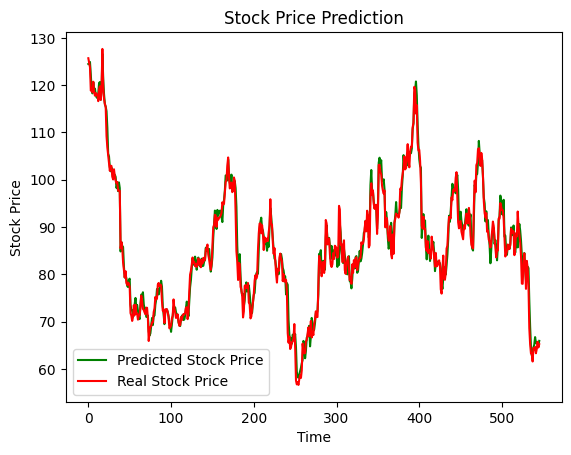

In [163]:
results = test_model(model, test_loader)

# Original Code

In [ ]:
# %% [markdown]
# # Stock Market Prediction using CNN-LSTM model
# This project is about analysis of Stock Market and providing predictions to the stockholders. For this, we used CNN-LSTM approach to create a blank model, then use it to train on stock market data. Further implementation is discussed below...

# %% [code] {"jupyter":{"outputs_hidden":false},"execution":{"iopub.status.busy":"2021-12-21T04:35:47.563443Z","iopub.execute_input":"2021-12-21T04:35:47.56378Z","iopub.status.idle":"2021-12-21T04:35:47.568846Z","shell.execute_reply.started":"2021-12-21T04:35:47.563747Z","shell.execute_reply":"2021-12-21T04:35:47.568215Z"}}
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# %% [markdown]
# # Data Preprocessing and Analysis

# %% [code] {"jupyter":{"outputs_hidden":false},"execution":{"iopub.status.busy":"2021-12-21T04:35:47.579406Z","iopub.execute_input":"2021-12-21T04:35:47.579971Z","iopub.status.idle":"2021-12-21T04:35:47.589144Z","shell.execute_reply.started":"2021-12-21T04:35:47.579926Z","shell.execute_reply":"2021-12-21T04:35:47.588306Z"}}
import math
import seaborn as sns
import datetime as dt
from datetime import datetime
sns.set_style("whitegrid")
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

# %% [markdown]
# Before preprocessing data, a function to fetch real-time stock data (using Alpha Vantage API) is made

# %% [code] {"_kg_hide-input":true,"jupyter":{"outputs_hidden":false},"execution":{"iopub.status.busy":"2021-12-21T04:35:47.590602Z","iopub.execute_input":"2021-12-21T04:35:47.591151Z","iopub.status.idle":"2021-12-21T04:35:47.801833Z","shell.execute_reply.started":"2021-12-21T04:35:47.591118Z","shell.execute_reply":"2021-12-21T04:35:47.801065Z"}}
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
key = user_secrets.get_secret("api")

import requests
import csv
from tqdm import tqdm

def request_stock_price_list(symbol, size, token):
    q_string = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={}&outputsize={}&apikey={}'

    print("Retrieving stock price data from Alpha Vantage (This may take a while)...")
    r = requests.get(q_string.format(symbol, size, token))
    print("Data has been successfully downloaded...")
    date = []
    colnames = list(range(0, 5))
    df = pd.DataFrame(columns = colnames)
    print("Sorting the retrieved data into a dataframe...")
    for i in tqdm(r.json()['Time Series (Daily)'].keys()):
        date.append(i)
        row = pd.DataFrame.from_dict(r.json()['Time Series (Daily)'][i], orient='index').reset_index().T[1:]
        df = pd.concat([df, row], ignore_index=True)
    df.columns = ["open", "high", "low", "close", "volume"]
    df['date'] = date
    return df

# %% [code] {"jupyter":{"outputs_hidden":false},"execution":{"iopub.status.busy":"2021-12-21T04:35:47.803236Z","iopub.execute_input":"2021-12-21T04:35:47.803522Z","iopub.status.idle":"2021-12-21T04:38:02.748172Z","shell.execute_reply.started":"2021-12-21T04:35:47.803495Z","shell.execute_reply":"2021-12-21T04:38:02.746951Z"}}
# UNCOMMENT THE CELL IF DATA IS NEEDED TO BE LOADED FOR 1ST TIME

cv1 = request_stock_price_list('IBM', 'full', key)
print(cv1.head)
cv1.to_csv('data.csv')

# %% [markdown]
# Then the datasets are loaded

# %% [code] {"jupyter":{"outputs_hidden":false},"execution":{"iopub.status.busy":"2021-12-21T04:38:02.750106Z","iopub.execute_input":"2021-12-21T04:38:02.750426Z","iopub.status.idle":"2021-12-21T04:38:02.786025Z","shell.execute_reply.started":"2021-12-21T04:38:02.750394Z","shell.execute_reply":"2021-12-21T04:38:02.785121Z"}}
# For data preprocessing and analysis part
data = pd.read_csv('../input/price-volume-data-for-all-us-stocks-etfs/Stocks/abe.us.txt')
#data = pd.read_csv('../input/nifty50-stock-market-data/COALINDIA.csv')
#data = pd.read_csv('../input/stock-market-data/stock_market_data/nasdaq/csv/ABCO.csv')
#data = pd.read_csv('./data.csv')
# Any CSV or TXT file can be added here....
data.head()

# %% [code] {"jupyter":{"outputs_hidden":false},"execution":{"iopub.status.busy":"2021-12-21T04:38:02.788328Z","iopub.execute_input":"2021-12-21T04:38:02.78856Z","iopub.status.idle":"2021-12-21T04:38:02.803746Z","shell.execute_reply.started":"2021-12-21T04:38:02.788533Z","shell.execute_reply":"2021-12-21T04:38:02.802996Z"}}
data.info()

# %% [code] {"jupyter":{"outputs_hidden":false},"execution":{"iopub.status.busy":"2021-12-21T04:38:02.804952Z","iopub.execute_input":"2021-12-21T04:38:02.805183Z","iopub.status.idle":"2021-12-21T04:38:02.839221Z","shell.execute_reply.started":"2021-12-21T04:38:02.805156Z","shell.execute_reply":"2021-12-21T04:38:02.838306Z"}}
data.describe()

# %% [code] {"jupyter":{"outputs_hidden":false},"execution":{"iopub.status.busy":"2021-12-21T04:38:02.840716Z","iopub.execute_input":"2021-12-21T04:38:02.840993Z","iopub.status.idle":"2021-12-21T04:38:02.851535Z","shell.execute_reply.started":"2021-12-21T04:38:02.840958Z","shell.execute_reply":"2021-12-21T04:38:02.850823Z"}}
data.isnull().sum()

# %% [markdown]
# Filling null columns with mean values....

# %% [code] {"jupyter":{"outputs_hidden":false},"execution":{"iopub.status.busy":"2021-12-21T04:38:02.852917Z","iopub.execute_input":"2021-12-21T04:38:02.853485Z","iopub.status.idle":"2021-12-21T04:38:02.87935Z","shell.execute_reply.started":"2021-12-21T04:38:02.85345Z","shell.execute_reply":"2021-12-21T04:38:02.878453Z"}}
data.reset_index(drop=True, inplace=True)
data.fillna(data.mean(), inplace=True)
data.head()

# %% [code] {"jupyter":{"outputs_hidden":false},"execution":{"iopub.status.busy":"2021-12-21T04:38:02.88105Z","iopub.execute_input":"2021-12-21T04:38:02.882042Z","iopub.status.idle":"2021-12-21T04:38:06.934658Z","shell.execute_reply.started":"2021-12-21T04:38:02.881998Z","shell.execute_reply":"2021-12-21T04:38:06.93371Z"}}
data.plot(legend=True,subplots=True, figsize = (12, 6))
plt.show()
#data['Close'].plot(legend=True, figsize = (12, 6))
#plt.show()
#data['Volume'].plot(legend=True,figsize=(12,7))
#plt.show()

data.shape
data.size
data.describe(include='all').T
data.dtypes
data.nunique()
ma_day = [10,50,100]

for ma in ma_day:
    column_name = "MA for %s days" %(str(ma))
    data[column_name]=pd.DataFrame.rolling(data['Close'],ma).mean()

data['Daily Return'] = data['Close'].pct_change()
# plot the daily return percentage
data['Daily Return'].plot(figsize=(12,5),legend=True,linestyle=':',marker='o')
plt.show()

sns.displot(data['Daily Return'].dropna(),bins=100,color='green')
plt.show()

date=pd.DataFrame(data['Date'])
closing_df1 = pd.DataFrame(data['Close'])
close1  = closing_df1.rename(columns={"Close": "data_close"})
close2=pd.concat([date,close1],axis=1)
close2.head()

data.reset_index(drop=True, inplace=True)
data.fillna(data.mean(), inplace=True)
data.head()

data.nunique()

data.sort_index(axis=1,ascending=True)

cols_plot = ['Open', 'High', 'Low','Close','Volume','MA for 10 days','MA for 50 days','MA for 100 days','Daily Return']
axes = data[cols_plot].plot(marker='.', alpha=0.7, linestyle='None', figsize=(11, 9), subplots=True)
for ax in axes:
    ax.set_ylabel('Daily trade')

plt.plot(data['Close'], label="Close price")
plt.xlabel("Timestamp")
plt.ylabel("Closing price")
df = data
print(df)

data.isnull().sum()

# %% [markdown]
# After that, we'll visualize the data for understanding, this is shown below...

# %% [code] {"jupyter":{"outputs_hidden":false},"execution":{"iopub.status.busy":"2021-12-21T04:38:06.935983Z","iopub.execute_input":"2021-12-21T04:38:06.936236Z","iopub.status.idle":"2021-12-21T04:38:07.764826Z","shell.execute_reply.started":"2021-12-21T04:38:06.936208Z","shell.execute_reply":"2021-12-21T04:38:07.763962Z"}}
cols_plot = ['Open', 'High', 'Low','Close']
axes = data[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True)
for ax in axes:
    ax.set_ylabel('Daily trade')

# %% [markdown]
# Then we'd print the data after making changes and dropping null data

# %% [code] {"jupyter":{"outputs_hidden":false},"execution":{"iopub.status.busy":"2021-12-21T04:38:07.767589Z","iopub.execute_input":"2021-12-21T04:38:07.767945Z","iopub.status.idle":"2021-12-21T04:38:08.111112Z","shell.execute_reply.started":"2021-12-21T04:38:07.767913Z","shell.execute_reply":"2021-12-21T04:38:08.110498Z"}}
plt.plot(data['Close'], label="Close price")
plt.xlabel("Timestamp")
plt.ylabel("Closing price")
df = data
print(df)

df.describe().transpose()

# %% [markdown]
# The data has been analysed but it must be converted into data of shape [100,1] to make it easier for CNN to train on... Else it won't select necessary features and the model will fail

# %% [code] {"jupyter":{"outputs_hidden":false},"execution":{"iopub.status.busy":"2021-12-21T04:38:08.112119Z","iopub.execute_input":"2021-12-21T04:38:08.112695Z","iopub.status.idle":"2021-12-21T04:38:19.32783Z","shell.execute_reply.started":"2021-12-21T04:38:08.112664Z","shell.execute_reply":"2021-12-21T04:38:19.326917Z"}}
from sklearn.model_selection import train_test_split

X = []
Y = []
window_size=100
for i in range(1 , len(df) - window_size -1 , 1):
    first = df.iloc[i,2]
    temp = []
    temp2 = []
    for j in range(window_size):
        temp.append((df.iloc[i + j, 2] - first) / first)
    temp2.append((df.iloc[i + window_size, 2] - first) / first)
    X.append(np.array(temp).reshape(100, 1))
    Y.append(np.array(temp2).reshape(1, 1))

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=True)

train_X = np.array(x_train)
test_X = np.array(x_test)
train_Y = np.array(y_train)
test_Y = np.array(y_test)

train_X = train_X.reshape(train_X.shape[0],1,100,1)
test_X = test_X.reshape(test_X.shape[0],1,100,1)

print(len(train_X))
print(len(test_X))

# %% [markdown]
# # Training part

# %% [markdown]
# This part has 2 subparts: CNN and LSTM
#
# For CNN, the layers are created with sizes 64,128,64 with kernel size = 3. In every layer, TimeDistributed function is added to track the features for every temporal slice of data with respect to time. In between, MaxPooling layers are added.
#
# After that, it's passed to Bi-LSTM layers

# %% [code] {"jupyter":{"outputs_hidden":false},"execution":{"iopub.status.busy":"2021-12-21T04:38:19.328887Z","iopub.execute_input":"2021-12-21T04:38:19.329103Z","iopub.status.idle":"2021-12-21T04:39:24.139033Z","shell.execute_reply.started":"2021-12-21T04:38:19.329078Z","shell.execute_reply":"2021-12-21T04:39:24.138214Z"}}
# For creating model and training
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, Bidirectional, TimeDistributed
from tensorflow.keras.layers import MaxPooling1D, Flatten
from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.metrics import RootMeanSquaredError

model = tf.keras.Sequential()

# Creating the Neural Network model here...
# CNN layers
model.add(TimeDistributed(Conv1D(64, kernel_size=3, activation='relu', input_shape=(None, 100, 1))))
model.add(TimeDistributed(MaxPooling1D(2)))
model.add(TimeDistributed(Conv1D(128, kernel_size=3, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(2)))
model.add(TimeDistributed(Conv1D(64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(2)))
model.add(TimeDistributed(Flatten()))
# model.add(Dense(5, kernel_regularizer=L2(0.01)))

# LSTM layers
model.add(Bidirectional(LSTM(100, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(100, return_sequences=False)))
model.add(Dropout(0.5))

#Final layers
model.add(Dense(1, activation='linear'))
model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])

history = model.fit(train_X, train_Y, validation_data=(test_X,test_Y), epochs=40,batch_size=40, verbose=1, shuffle =True)

# %% [code] {"jupyter":{"outputs_hidden":false},"execution":{"iopub.status.busy":"2021-12-21T04:39:24.142878Z","iopub.execute_input":"2021-12-21T04:39:24.143438Z","iopub.status.idle":"2021-12-21T04:39:24.457427Z","shell.execute_reply.started":"2021-12-21T04:39:24.143401Z","shell.execute_reply":"2021-12-21T04:39:24.456538Z"}}
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()

# %% [code] {"jupyter":{"outputs_hidden":false},"execution":{"iopub.status.busy":"2021-12-21T04:39:24.458694Z","iopub.execute_input":"2021-12-21T04:39:24.458929Z","iopub.status.idle":"2021-12-21T04:39:24.765864Z","shell.execute_reply.started":"2021-12-21T04:39:24.458903Z","shell.execute_reply":"2021-12-21T04:39:24.76517Z"}}
plt.plot(history.history['mse'], label='train mse')
plt.plot(history.history['val_mse'], label='val mse')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()

# %% [code] {"jupyter":{"outputs_hidden":false},"execution":{"iopub.status.busy":"2021-12-21T04:39:24.767204Z","iopub.execute_input":"2021-12-21T04:39:24.767475Z","iopub.status.idle":"2021-12-21T04:39:25.125249Z","shell.execute_reply.started":"2021-12-21T04:39:24.767446Z","shell.execute_reply":"2021-12-21T04:39:25.124392Z"}}
plt.plot(history.history['mae'], label='train mae')
plt.plot(history.history['val_mae'], label='val mae')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()

# %% [code] {"jupyter":{"outputs_hidden":false},"execution":{"iopub.status.busy":"2021-12-21T04:39:25.126549Z","iopub.execute_input":"2021-12-21T04:39:25.126793Z","iopub.status.idle":"2021-12-21T04:39:25.406779Z","shell.execute_reply.started":"2021-12-21T04:39:25.126766Z","shell.execute_reply":"2021-12-21T04:39:25.405778Z"}}
# After the model has been constructed, we'll summarise it
from tensorflow.keras.utils import plot_model
print(model.summary())
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

# %% [code] {"jupyter":{"outputs_hidden":false},"execution":{"iopub.status.busy":"2021-12-21T04:39:25.408492Z","iopub.execute_input":"2021-12-21T04:39:25.408783Z","iopub.status.idle":"2021-12-21T04:39:25.603139Z","shell.execute_reply.started":"2021-12-21T04:39:25.408745Z","shell.execute_reply":"2021-12-21T04:39:25.602561Z"}}
model.evaluate(test_X, test_Y)

# %% [code] {"jupyter":{"outputs_hidden":false},"execution":{"iopub.status.busy":"2021-12-21T04:39:25.604095Z","iopub.execute_input":"2021-12-21T04:39:25.604823Z","iopub.status.idle":"2021-12-21T04:39:27.157648Z","shell.execute_reply.started":"2021-12-21T04:39:25.604787Z","shell.execute_reply":"2021-12-21T04:39:27.156796Z"}}
from sklearn.metrics import explained_variance_score, mean_poisson_deviance, mean_gamma_deviance
from sklearn.metrics import r2_score
from sklearn.metrics import max_error

# predict probabilities for test set
yhat_probs = model.predict(test_X, verbose=0)
# reduce to 1d array
yhat_probs = yhat_probs[:, 0]

var = explained_variance_score(test_Y.reshape(-1,1), yhat_probs)
print('Variance: %f' % var)

r2 = r2_score(test_Y.reshape(-1,1), yhat_probs)
print('R2 Score: %f' % var)

var2 = max_error(test_Y.reshape(-1,1), yhat_probs)
print('Max Error: %f' % var2)

# %% [code] {"jupyter":{"outputs_hidden":false},"execution":{"iopub.status.busy":"2021-12-21T04:39:27.159335Z","iopub.execute_input":"2021-12-21T04:39:27.160388Z","iopub.status.idle":"2021-12-21T04:39:27.682411Z","shell.execute_reply.started":"2021-12-21T04:39:27.160351Z","shell.execute_reply":"2021-12-21T04:39:27.681563Z"}}
predicted  = model.predict(test_X)
test_label = test_Y.reshape(-1,1)
predicted = np.array(predicted[:,0]).reshape(-1,1)
len_t = len(train_X)
for j in range(len_t , len_t + len(test_X)):
    temp = data.iloc[j,3]
    test_label[j - len_t] = test_label[j - len_t] * temp + temp
    predicted[j - len_t] = predicted[j - len_t] * temp + temp
plt.plot(predicted, color = 'green', label = 'Predicted  Stock Price')
plt.plot(test_label, color = 'red', label = 'Real Stock Price')
plt.title(' Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel(' Stock Price')
plt.legend()
plt.show()

# %% [markdown]
# # Testing part

# %% [markdown]
# In this part, the model is saved and loaded back again. Then, it's made to train again but with different data to check it's loss and prediction

# %% [code] {"jupyter":{"outputs_hidden":false},"execution":{"iopub.status.busy":"2021-12-21T04:39:27.684065Z","iopub.execute_input":"2021-12-21T04:39:27.684368Z","iopub.status.idle":"2021-12-21T04:39:27.774175Z","shell.execute_reply.started":"2021-12-21T04:39:27.684329Z","shell.execute_reply":"2021-12-21T04:39:27.773153Z"}}
# First we need to save a model
model.save("model.h5")

# %% [code] {"jupyter":{"outputs_hidden":false},"execution":{"iopub.status.busy":"2021-12-21T04:39:27.775944Z","iopub.execute_input":"2021-12-21T04:39:27.776253Z","iopub.status.idle":"2021-12-21T04:39:29.045776Z","shell.execute_reply.started":"2021-12-21T04:39:27.776215Z","shell.execute_reply":"2021-12-21T04:39:29.044992Z"}}
# Load model
new_model = tf.keras.models.load_model("./model.h5")

# %% [code] {"jupyter":{"outputs_hidden":false},"execution":{"iopub.status.busy":"2021-12-21T04:39:29.047094Z","iopub.execute_input":"2021-12-21T04:39:29.047319Z","iopub.status.idle":"2021-12-21T04:39:29.059186Z","shell.execute_reply.started":"2021-12-21T04:39:29.047294Z","shell.execute_reply":"2021-12-21T04:39:29.056578Z"}}
new_model.summary()

# %% [code] {"jupyter":{"outputs_hidden":false},"execution":{"iopub.status.busy":"2021-12-21T04:39:29.060545Z","iopub.execute_input":"2021-12-21T04:39:29.060811Z","iopub.status.idle":"2021-12-21T04:39:49.022632Z","shell.execute_reply.started":"2021-12-21T04:39:29.060783Z","shell.execute_reply":"2021-12-21T04:39:49.021546Z"}}
# For data preprocessing and analysis part
#data2 = pd.read_csv('../input/price-volume-data-for-all-us-stocks-etfs/Stocks/aaoi.us.txt')
#data2 = pd.read_csv('../input/nifty50-stock-market-data/SBIN.csv')
#data2 = pd.read_csv('../input/stock-market-data/stock_market_data/nasdaq/csv/ACTG.csv')
data2 = pd.read_csv('./data.csv')
# Any CSV or TXT file can be added here....
data2.dropna(inplace=True)
data2.head()

data2.reset_index(drop=True, inplace=True)
data2.fillna(data.mean(), inplace=True)
data2.head()
df2 = data2.drop('date', axis=1)

print(df2)

X = []
Y = []
window_size=100
for i in range(1 , len(df2) - window_size -1 , 1):
    first = df2.iloc[i,4]
    temp = []
    temp2 = []
    for j in range(window_size):
        temp.append((df2.iloc[i + j, 4] - first) / first)
    # for j in range(week):
    temp2.append((df2.iloc[i + window_size, 4] - first) / first)
    # X.append(np.array(stock.iloc[i:i+window_size,4]).reshape(50,1))
    # Y.append(np.array(stock.iloc[i+window_size,4]).reshape(1,1))
    # print(stock2.iloc[i:i+window_size,4])
    X.append(np.array(temp).reshape(100, 1))
    Y.append(np.array(temp2).reshape(1, 1))

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)

train_X = np.array(x_train)
test_X = np.array(x_test)
train_Y = np.array(y_train)
test_Y = np.array(y_test)

train_X = train_X.reshape(train_X.shape[0],1,100,1)
test_X = test_X.reshape(test_X.shape[0],1,100,1)

print(len(train_X))
print(len(test_X))

# %% [code] {"execution":{"iopub.status.busy":"2021-12-21T04:39:49.023842Z","iopub.execute_input":"2021-12-21T04:39:49.024067Z","iopub.status.idle":"2021-12-21T04:39:49.291965Z","shell.execute_reply.started":"2021-12-21T04:39:49.024041Z","shell.execute_reply":"2021-12-21T04:39:49.291234Z"}}
model.evaluate(test_X, test_Y)

# %% [code] {"jupyter":{"outputs_hidden":false},"execution":{"iopub.status.busy":"2021-12-21T04:39:49.293123Z","iopub.execute_input":"2021-12-21T04:39:49.293364Z","iopub.status.idle":"2021-12-21T04:39:49.872487Z","shell.execute_reply.started":"2021-12-21T04:39:49.293337Z","shell.execute_reply":"2021-12-21T04:39:49.8719Z"}}
predicted  = model.predict(test_X)
test_label = test_Y.reshape(-1,1)
predicted = np.array(predicted[:,0]).reshape(-1,1)
len_t = len(train_X)
for j in range(len_t , len_t + len(test_X)):
    temp = data2.iloc[j,3]
    test_label[j - len_t] = test_label[j - len_t] * temp + temp
    predicted[j - len_t] = predicted[j - len_t] * temp + temp
plt.plot(predicted, color = 'green', label = 'Predicted  Stock Price')
plt.plot(test_label, color = 'red', label = 'Real Stock Price')
plt.title(' Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel(' Stock Price')
plt.legend()
plt.show()

# %% [code] {"execution":{"iopub.status.busy":"2021-12-21T04:39:49.873683Z","iopub.execute_input":"2021-12-21T04:39:49.874074Z","iopub.status.idle":"2021-12-21T04:40:02.588984Z","shell.execute_reply.started":"2021-12-21T04:39:49.87403Z","shell.execute_reply":"2021-12-21T04:40:02.587937Z"}}
# Converting model from HDF5 format to TFJS format...
!pip install tensorflowjs[wizard]
# Need to be done on a CLI and not in notebook
!tensorflowjs_converter --input_format=keras /kaggle/working/model.h5 /kaggle/working/model-tjs

# %% [markdown]
# # EDA

# %% [markdown]
# This section is exploratory data analysis on the dataset collected. This is just for analysing the data...

# %% [code] {"jupyter":{"outputs_hidden":false},"execution":{"iopub.status.busy":"2021-12-21T04:40:02.590615Z","iopub.execute_input":"2021-12-21T04:40:02.590901Z","iopub.status.idle":"2021-12-21T04:40:02.634536Z","shell.execute_reply.started":"2021-12-21T04:40:02.590871Z","shell.execute_reply":"2021-12-21T04:40:02.633915Z"}}
dataX = pd.read_csv('./data.csv')
dataY = pd.read_csv('./data.csv')
dataX.info()

# %% [code] {"jupyter":{"outputs_hidden":false},"execution":{"iopub.status.busy":"2021-12-21T04:40:02.639954Z","iopub.execute_input":"2021-12-21T04:40:02.640224Z","iopub.status.idle":"2021-12-21T04:40:02.658405Z","shell.execute_reply.started":"2021-12-21T04:40:02.640195Z","shell.execute_reply":"2021-12-21T04:40:02.657623Z"}}
dataX.head()

# %% [code] {"jupyter":{"outputs_hidden":false},"execution":{"iopub.status.busy":"2021-12-21T04:40:02.65954Z","iopub.execute_input":"2021-12-21T04:40:02.659803Z","iopub.status.idle":"2021-12-21T04:40:02.695784Z","shell.execute_reply.started":"2021-12-21T04:40:02.659774Z","shell.execute_reply":"2021-12-21T04:40:02.694856Z"}}
start_date = '2020-01-01'
end_date = '2021-11-29'

start = '2018-01-01'
end = '2020-01-01'

fill = (dataX['date']>=start_date) & (dataX['date']<=end_date)
dataX = dataX.loc[fill]
dataX

# %% [code] {"jupyter":{"outputs_hidden":false},"execution":{"iopub.status.busy":"2021-12-21T04:40:02.69779Z","iopub.execute_input":"2021-12-21T04:40:02.69812Z","iopub.status.idle":"2021-12-21T04:40:02.731473Z","shell.execute_reply.started":"2021-12-21T04:40:02.698079Z","shell.execute_reply":"2021-12-21T04:40:02.730836Z"}}
fill2 = (dataY['date']>=start) & (dataY['date']<=end)
dataY = dataY.loc[fill2]
dataY

# %% [code] {"jupyter":{"outputs_hidden":false},"execution":{"iopub.status.busy":"2021-12-21T04:40:02.732625Z","iopub.execute_input":"2021-12-21T04:40:02.732904Z","iopub.status.idle":"2021-12-21T04:40:02.771293Z","shell.execute_reply.started":"2021-12-21T04:40:02.732876Z","shell.execute_reply":"2021-12-21T04:40:02.770398Z"}}
dataX.describe()

# %% [code] {"jupyter":{"outputs_hidden":false},"execution":{"iopub.status.busy":"2021-12-21T04:40:02.772861Z","iopub.execute_input":"2021-12-21T04:40:02.77334Z","iopub.status.idle":"2021-12-21T04:40:02.809578Z","shell.execute_reply.started":"2021-12-21T04:40:02.773299Z","shell.execute_reply":"2021-12-21T04:40:02.808936Z"}}
dataY.describe()

# %% [code] {"jupyter":{"outputs_hidden":false},"execution":{"iopub.status.busy":"2021-12-21T04:40:02.811199Z","iopub.execute_input":"2021-12-21T04:40:02.811788Z","iopub.status.idle":"2021-12-21T04:40:03.215199Z","shell.execute_reply.started":"2021-12-21T04:40:02.81171Z","shell.execute_reply":"2021-12-21T04:40:03.214249Z"}}
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.metrics import r2_score,mean_squared_error

sns_plot = sns.distplot(dataX['close'])
sns_plot2 = sns.distplot(dataY['close'])

# %% [code] {"jupyter":{"outputs_hidden":false},"execution":{"iopub.status.busy":"2021-12-21T04:40:03.218469Z","iopub.execute_input":"2021-12-21T04:40:03.218744Z","iopub.status.idle":"2021-12-21T04:40:05.820017Z","shell.execute_reply.started":"2021-12-21T04:40:03.21869Z","shell.execute_reply":"2021-12-21T04:40:05.819097Z"}}
fig, ax = plt.subplots(4, 2, figsize = (15, 13))
sns.boxplot(x= dataX["close"], ax = ax[0,0])
sns.distplot(dataX['close'], ax = ax[0,1])
sns.boxplot(x= dataX["open"], ax = ax[1,0])
sns.distplot(dataX['open'], ax = ax[1,1])
sns.boxplot(x= dataX["high"], ax = ax[2,0])
sns.distplot(dataX['high'], ax = ax[2,1])
sns.boxplot(x= dataX["low"], ax = ax[3,0])
sns.distplot(dataX['low'], ax = ax[3,1])
plt.tight_layout()

# %% [code] {"jupyter":{"outputs_hidden":false},"execution":{"iopub.status.busy":"2021-12-21T04:40:05.821397Z","iopub.execute_input":"2021-12-21T04:40:05.821638Z","iopub.status.idle":"2021-12-21T04:40:08.100887Z","shell.execute_reply.started":"2021-12-21T04:40:05.821613Z","shell.execute_reply":"2021-12-21T04:40:08.099988Z"}}
fig, ax = plt.subplots(4, 2, figsize = (15, 13))
sns.boxplot(x= dataY["close"], ax = ax[0,0])
sns.distplot(dataY['close'], ax = ax[0,1])
sns.boxplot(x= dataY["open"], ax = ax[1,0])
sns.distplot(dataY['open'], ax = ax[1,1])
sns.boxplot(x= dataY["high"], ax = ax[2,0])
sns.distplot(dataY['high'], ax = ax[2,1])
sns.boxplot(x= dataY["low"], ax = ax[3,0])
sns.distplot(dataY['low'], ax = ax[3,1])
plt.tight_layout()

# %% [code] {"jupyter":{"outputs_hidden":false},"execution":{"iopub.status.busy":"2021-12-21T04:40:08.1021Z","iopub.execute_input":"2021-12-21T04:40:08.10234Z","iopub.status.idle":"2021-12-21T04:40:08.852576Z","shell.execute_reply.started":"2021-12-21T04:40:08.102312Z","shell.execute_reply":"2021-12-21T04:40:08.851707Z"}}
plt.figure(figsize=(10,6))
sns.heatmap(dataX.corr(),cmap=plt.cm.Reds,annot=True)
plt.title('Heatmap displaying the relationship between the features of the data (During COVID)',
         fontsize=13)
plt.show()

# %% [code] {"jupyter":{"outputs_hidden":false},"execution":{"iopub.status.busy":"2021-12-21T04:40:08.853701Z","iopub.execute_input":"2021-12-21T04:40:08.854219Z","iopub.status.idle":"2021-12-21T04:40:09.522562Z","shell.execute_reply.started":"2021-12-21T04:40:08.854166Z","shell.execute_reply":"2021-12-21T04:40:09.521652Z"}}
plt.figure(figsize=(10,6))
sns.heatmap(dataY.corr(),cmap=plt.cm.Blues,annot=True)
plt.title('Heatmap displaying the relationship between the features of the data (Before COVID)',
         fontsize=13)
plt.show()

# %% [code] {"jupyter":{"outputs_hidden":false},"execution":{"iopub.status.busy":"2021-12-21T04:40:09.523955Z","iopub.execute_input":"2021-12-21T04:40:09.524501Z","iopub.status.idle":"2021-12-21T04:41:28.796626Z","shell.execute_reply.started":"2021-12-21T04:40:09.524457Z","shell.execute_reply":"2021-12-21T04:41:28.795613Z"}}
# For other company....

# UNCOMMENT IF NEEDED...
cv2 = request_stock_price_list('RELIANCE.BSE', 'full', key)
print(cv2.head)
cv2.to_csv('data2.csv')

dataX = pd.read_csv('./data2.csv')
dataY = pd.read_csv('./data2.csv')
dataX.info()

# %% [code] {"execution":{"iopub.status.busy":"2021-12-21T04:41:28.798149Z","iopub.execute_input":"2021-12-21T04:41:28.798509Z","iopub.status.idle":"2021-12-21T04:41:28.828654Z","shell.execute_reply.started":"2021-12-21T04:41:28.798476Z","shell.execute_reply":"2021-12-21T04:41:28.827766Z"}}
start_date = '2020-01-01'
end_date = '2021-11-29'

start = '2018-01-01'
end = '2020-01-01'

fill = (dataX['date']>=start_date) & (dataX['date']<=end_date)
dataX = dataX.loc[fill]
dataX

# %% [code] {"execution":{"iopub.status.busy":"2021-12-21T04:41:28.829858Z","iopub.execute_input":"2021-12-21T04:41:28.830483Z","iopub.status.idle":"2021-12-21T04:41:28.864628Z","shell.execute_reply.started":"2021-12-21T04:41:28.830447Z","shell.execute_reply":"2021-12-21T04:41:28.863737Z"}}
fill2 = (dataY['date']>=start) & (dataY['date']<=end)
dataY = dataY.loc[fill2]
dataY

# %% [code] {"execution":{"iopub.status.busy":"2021-12-21T04:41:28.865927Z","iopub.execute_input":"2021-12-21T04:41:28.866195Z","iopub.status.idle":"2021-12-21T04:41:28.906445Z","shell.execute_reply.started":"2021-12-21T04:41:28.866158Z","shell.execute_reply":"2021-12-21T04:41:28.9055Z"}}
dataX.describe()

# %% [code] {"execution":{"iopub.status.busy":"2021-12-21T04:41:28.907836Z","iopub.execute_input":"2021-12-21T04:41:28.908282Z","iopub.status.idle":"2021-12-21T04:41:28.944283Z","shell.execute_reply.started":"2021-12-21T04:41:28.90825Z","shell.execute_reply":"2021-12-21T04:41:28.94341Z"}}
dataY.describe()

# %% [code] {"execution":{"iopub.status.busy":"2021-12-21T04:41:28.947389Z","iopub.execute_input":"2021-12-21T04:41:28.947953Z","iopub.status.idle":"2021-12-21T04:41:29.329513Z","shell.execute_reply.started":"2021-12-21T04:41:28.947918Z","shell.execute_reply":"2021-12-21T04:41:29.328893Z"}}
sns_plot = sns.distplot(dataX['close'])
sns_plot2 = sns.distplot(dataY['close'])

# %% [code] {"execution":{"iopub.status.busy":"2021-12-21T04:41:29.330517Z","iopub.execute_input":"2021-12-21T04:41:29.331083Z","iopub.status.idle":"2021-12-21T04:41:31.918911Z","shell.execute_reply.started":"2021-12-21T04:41:29.331048Z","shell.execute_reply":"2021-12-21T04:41:31.918041Z"}}
fig, ax = plt.subplots(4, 2, figsize = (15, 13))
sns.boxplot(x= dataX["close"], ax = ax[0,0])
sns.distplot(dataX['close'], ax = ax[0,1])
sns.boxplot(x= dataX["open"], ax = ax[1,0])
sns.distplot(dataX['open'], ax = ax[1,1])
sns.boxplot(x= dataX["high"], ax = ax[2,0])
sns.distplot(dataX['high'], ax = ax[2,1])
sns.boxplot(x= dataX["low"], ax = ax[3,0])
sns.distplot(dataX['low'], ax = ax[3,1])
plt.tight_layout()

# %% [code] {"execution":{"iopub.status.busy":"2021-12-21T04:41:31.920248Z","iopub.execute_input":"2021-12-21T04:41:31.920576Z","iopub.status.idle":"2021-12-21T04:41:33.999393Z","shell.execute_reply.started":"2021-12-21T04:41:31.920529Z","shell.execute_reply":"2021-12-21T04:41:33.99855Z"}}
fig, ax = plt.subplots(4, 2, figsize = (15, 13))
sns.boxplot(x= dataY["close"], ax = ax[0,0])
sns.distplot(dataY['close'], ax = ax[0,1])
sns.boxplot(x= dataY["open"], ax = ax[1,0])
sns.distplot(dataY['open'], ax = ax[1,1])
sns.boxplot(x= dataY["high"], ax = ax[2,0])
sns.distplot(dataY['high'], ax = ax[2,1])
sns.boxplot(x= dataY["low"], ax = ax[3,0])
sns.distplot(dataY['low'], ax = ax[3,1])
plt.tight_layout()

# %% [code] {"execution":{"iopub.status.busy":"2021-12-21T04:41:34.000619Z","iopub.execute_input":"2021-12-21T04:41:34.001084Z","iopub.status.idle":"2021-12-21T04:41:34.749598Z","shell.execute_reply.started":"2021-12-21T04:41:34.001053Z","shell.execute_reply":"2021-12-21T04:41:34.74867Z"}}
plt.figure(figsize=(10,6))
sns.heatmap(dataX.corr(),cmap=plt.cm.Reds,annot=True)
plt.title('Heatmap displaying the relationship between the features of the data (During COVID)',
         fontsize=13)
plt.show()

# %% [code] {"execution":{"iopub.status.busy":"2021-12-21T04:41:34.75088Z","iopub.execute_input":"2021-12-21T04:41:34.751248Z","iopub.status.idle":"2021-12-21T04:41:35.426433Z","shell.execute_reply.started":"2021-12-21T04:41:34.751213Z","shell.execute_reply":"2021-12-21T04:41:35.425818Z"}}
plt.figure(figsize=(10,6))
sns.heatmap(dataY.corr(),cmap=plt.cm.Blues,annot=True)
plt.title('Heatmap displaying the relationship between the features of the data (Before COVID)',
         fontsize=13)
plt.show()

# %% [code]


ModuleNotFoundError: No module named 'kaggle_secrets'